In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
adata = sc.read_h5ad(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_pCRC_annotations.h5ad"))
adata.shape

(246779, 2000)

In [4]:
adata.obs.cell_source.value_counts()

Pelka    129560
Che       43490
SMC       41319
Wu        26484
KUL        5926
Name: cell_source, dtype: int64

In [5]:
### need to rremove Wu dataset as it contains only immune cells!!
adata = adata[adata.obs.cell_source!="Wu"].copy()
adata.shape

(220295, 2000)

In [6]:
# pick a dataset:
cell_source = "SMC"#"Che"#"all" #"Pelka"
if cell_source == "all":
    adata = adata.copy()
else:
    adata = adata[adata.obs.cell_source==cell_source].copy()
adata.shape

(41319, 2000)

In [46]:
len(adata.obs.Patient.unique())

23

In [7]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       16027
Epithelial     13542
Myeloid         5688
B               2025
Plasma          1875
Stromal         1546
Endothelial      607
Mast               9
Name: Annotation_scVI, dtype: int64

In [8]:
adata.obs.Annotation_scVI_detailed.value_counts() 
# enough cells per cell type so we don't need to exclude any subsets

CD4 Tn               2984
Intermediate         2381
pEMT                 2232
Stem                 2066
B                    2025
CD8 Tex              1934
Stem (NOTUM high)    1922
CD8 Tem              1885
Plasma               1875
Treg                 1785
CD4 Th17             1625
Treg HSP             1137
SPP1 Mac             1123
Hypoxia              1028
CD4 Th HSP            850
C1QC Mac              806
TA1                   779
HSP Mono              773
CD4 Th                761
Goblet                751
NLRP3 Mac             741
IL1B Mac              719
gdT                   597
Colonocyte            596
CD8 Tem HSP           586
TA2                   507
CD4 Tfh               483
NK2                   469
T cycling             462
UPR                   436
FCN1 Mono             430
GREM1 HSP CAF         361
Pericyte              309
cDC2                  297
HLA high              288
ipEMT                 282
Stalk-like endo       271
pDC                   270
MMP CAF     

In [9]:
# maybe create a new column where we have cancer cell states and general TME annot?
adata.obs["Annot_majorTME_cancer_states"] = np.where(
    adata.obs["Annotation_scVI"]=="Epithelial",
    adata.obs["Annotation_scVI_detailed"],  
    adata.obs["Annotation_scVI"])

In [10]:
# get subtypes of TME and cancer cell states that have at least nbcells cells
nbcells = 20
subsets2keep = adata.obs.Annotation_scVI_detailed.value_counts()[
    adata.obs.Annotation_scVI_detailed.value_counts()>nbcells].index.values

# only retains subtypes thaat have enough cells "barcodes" to actually look at correlation
adata = adata[adata.obs.Annotation_scVI_detailed.isin(subsets2keep)].copy()

In [11]:
# group by patient and compute fraction 
def proportions_cells_patient(df, groupby_cols):
    prop_df = df.groupby(groupby_cols).size().groupby(level=0).apply(lambda x: x*100/x.sum()).unstack()
    return prop_df

In [12]:
temp = adata.obs.groupby(
    ["Sample", "Annotation_scVI"]).size().groupby(level=0).apply(lambda x: x*100/x.sum()).unstack()
temp

Annotation_scVI          B  Endothelial  Epithelial    Myeloid     Plasma  \
Sample                                                                      
SMC01-T           2.431248     1.355122   36.747708   6.018334   2.431248   
SMC02-T           4.390564     2.293578   19.200524  37.090433   1.245085   
SMC03-T           9.330144     1.614833   32.476077  15.909091   8.373206   
SMC04-T           5.344418     3.919240   14.133017  46.377672   0.593824   
SMC05-T          11.885895     0.475436    0.000000   2.377179   5.071315   
SMC06-T           2.258292     0.352858   10.091743  13.832040   5.645730   
SMC07-T           7.819840     1.878972   10.113291   7.847472  14.672561   
SMC08-T           8.725910     1.124197   12.044968  14.453961   7.173448   
SMC09-T           0.255827     0.454804   47.697555  10.403638   0.341103   
SMC10-T           1.333333     2.121212   11.333333  30.545455   5.454545   
SMC11-T           3.807740     1.248439   16.729089   4.119850  12.047441   
SMC14-T           2.513966     4.888268    0.000000  38.756983   1.466480   
SMC15-T          14.800655     3.276898   14.472966   6.936100   5.734571   
SMC16-T           0.290592     0.290592   91.936070   1.380312   0.145296   
SMC17-T           1.470588     7.486631    0.000000  44.117647   4.278075   
SMC18-T           2.000000     0.176471   76.588235   4.058824   1.470588   
SMC19-T          18.181818     0.318979   11.004785   2.153110   7.655502   
SMC20-T           2.240717     1.344430   30.345711  20.614597   3.457106   
SMC21-T           2.252874     0.000000   72.459770   2.298851   0.689655   
SMC22-T           0.860010     0.430005   79.216436   3.201147   0.238892   
SMC23-T           2.512563     0.753769   20.100503  18.509213   7.202680   
SMC24-T           8.992023     1.377810   13.995649  25.453227   2.610587   
SMC25-T          10.997963     1.221996   20.502376   4.480652   6.381534   

Annotation_scVI    Stromal   T-NK-ILC  
Sample                                 
SMC01-T           3.108808  47.907533  
SMC02-T           3.145478  32.634338  
SMC03-T           4.545455  27.751196  
SMC04-T           3.028504  26.603325  
SMC05-T           2.060222  78.129952  
SMC06-T           4.375441  63.443896  
SMC07-T           2.321083  55.346781  
SMC08-T           6.156317  50.321199  
SMC09-T           0.568505  40.278567  
SMC10-T           5.878788  43.333333  
SMC11-T           1.685393  60.362047  
SMC14-T          10.474860  41.899441  
SMC15-T           9.666849  45.111961  
SMC16-T           0.581184   5.375954  
SMC17-T          14.037433  28.609626  
SMC18-T           0.058824  15.647059  
SMC19-T           1.993620  58.692185  
SMC20-T          20.678617  21.318822  
SMC21-T           0.137931  22.160920  
SMC22-T           0.286670  15.766842  
SMC23-T           1.256281  49.664992  
SMC24-T           2.102973  45.467730  
SMC25-T           0.339443  56.076035

In [13]:
# proportions major cell types
prop_major = proportions_cells_patient(df=adata.obs, groupby_cols=["Sample", "Annotation_scVI"])
prop_major

Annotation_scVI          B  Endothelial  Epithelial    Myeloid     Plasma  \
Sample                                                                      
SMC01-T           2.431248     1.355122   36.747708   6.018334   2.431248   
SMC02-T           4.390564     2.293578   19.200524  37.090433   1.245085   
SMC03-T           9.330144     1.614833   32.476077  15.909091   8.373206   
SMC04-T           5.344418     3.919240   14.133017  46.377672   0.593824   
SMC05-T          11.885895     0.475436    0.000000   2.377179   5.071315   
SMC06-T           2.258292     0.352858   10.091743  13.832040   5.645730   
SMC07-T           7.819840     1.878972   10.113291   7.847472  14.672561   
SMC08-T           8.725910     1.124197   12.044968  14.453961   7.173448   
SMC09-T           0.255827     0.454804   47.697555  10.403638   0.341103   
SMC10-T           1.333333     2.121212   11.333333  30.545455   5.454545   
SMC11-T           3.807740     1.248439   16.729089   4.119850  12.047441   
SMC14-T           2.513966     4.888268    0.000000  38.756983   1.466480   
SMC15-T          14.800655     3.276898   14.472966   6.936100   5.734571   
SMC16-T           0.290592     0.290592   91.936070   1.380312   0.145296   
SMC17-T           1.470588     7.486631    0.000000  44.117647   4.278075   
SMC18-T           2.000000     0.176471   76.588235   4.058824   1.470588   
SMC19-T          18.181818     0.318979   11.004785   2.153110   7.655502   
SMC20-T           2.240717     1.344430   30.345711  20.614597   3.457106   
SMC21-T           2.252874     0.000000   72.459770   2.298851   0.689655   
SMC22-T           0.860010     0.430005   79.216436   3.201147   0.238892   
SMC23-T           2.512563     0.753769   20.100503  18.509213   7.202680   
SMC24-T           8.992023     1.377810   13.995649  25.453227   2.610587   
SMC25-T          10.997963     1.221996   20.502376   4.480652   6.381534   

Annotation_scVI    Stromal   T-NK-ILC  
Sample                                 
SMC01-T           3.108808  47.907533  
SMC02-T           3.145478  32.634338  
SMC03-T           4.545455  27.751196  
SMC04-T           3.028504  26.603325  
SMC05-T           2.060222  78.129952  
SMC06-T           4.375441  63.443896  
SMC07-T           2.321083  55.346781  
SMC08-T           6.156317  50.321199  
SMC09-T           0.568505  40.278567  
SMC10-T           5.878788  43.333333  
SMC11-T           1.685393  60.362047  
SMC14-T          10.474860  41.899441  
SMC15-T           9.666849  45.111961  
SMC16-T           0.581184   5.375954  
SMC17-T          14.037433  28.609626  
SMC18-T           0.058824  15.647059  
SMC19-T           1.993620  58.692185  
SMC20-T          20.678617  21.318822  
SMC21-T           0.137931  22.160920  
SMC22-T           0.286670  15.766842  
SMC23-T           1.256281  49.664992  
SMC24-T           2.102973  45.467730  
SMC25-T           0.339443  56.076035

In [14]:
# prop major TME and cancer subsets
prop_majorTME_cancer_states = proportions_cells_patient(df=adata.obs, 
                                         groupby_cols=["Sample", "Annot_majorTME_cancer_states"])
prop_majorTME_cancer_states

Annot_majorTME_cancer_states          B  Colonocyte  Endothelial  \
Sample                                                             
SMC01-T                        2.431248    1.793543     1.355122   
SMC02-T                        4.390564    0.065531     2.293578   
SMC03-T                        9.330144    0.059809     1.614833   
SMC04-T                        5.344418    0.237530     3.919240   
SMC05-T                       11.885895    0.000000     0.475436   
SMC06-T                        2.258292    0.352858     0.352858   
SMC07-T                        7.819840    0.165792     1.878972   
SMC08-T                        8.725910    0.053533     1.124197   
SMC09-T                        0.255827    2.586697     0.454804   
SMC10-T                        1.333333    0.606061     2.121212   
SMC11-T                        3.807740    1.061174     1.248439   
SMC14-T                        2.513966    0.000000     4.888268   
SMC15-T                       14.800655    0.273075     3.276898   
SMC16-T                        0.290592    2.361061     0.290592   
SMC17-T                        1.470588    0.000000     7.486631   
SMC18-T                        2.000000    4.647059     0.176471   
SMC19-T                       18.181818    0.956938     0.318979   
SMC20-T                        2.240717    0.000000     1.344430   
SMC21-T                        2.252874    3.862069     0.000000   
SMC22-T                        0.860010    5.112279     0.430005   
SMC23-T                        2.512563    1.758794     0.753769   
SMC24-T                        8.992023    0.290065     1.377810   
SMC25-T                       10.997963    2.579769     1.221996   

Annot_majorTME_cancer_states  Enteroendocrine     Goblet  HLA high    Hypoxia  \
Sample                                                                          
SMC01-T                              0.119570   0.159426  1.833400   2.192108   
SMC02-T                              0.327654   0.000000  0.655308   0.196592   
SMC03-T                              0.478469   0.657895  0.239234   3.767943   
SMC04-T                              0.000000   0.296912  0.237530   0.534442   
SMC05-T                              0.000000   0.000000  0.000000   0.000000   
SMC06-T                              0.000000   0.000000  0.282287   0.211715   
SMC07-T                              0.221056   0.248687  0.055264   0.193424   
SMC08-T                              0.000000   0.000000  0.000000   0.267666   
SMC09-T                              0.426379   0.653781  1.478113   2.814099   
SMC10-T                              0.121212   0.303030  0.363636   1.636364   
SMC11-T                              0.124844   0.124844  0.374532   0.749064   
SMC14-T                              0.000000   0.000000  0.000000   0.000000   
SMC15-T                              0.109230   0.054615  0.218460   0.327690   
SMC16-T                              1.961497   8.245550  1.961497  11.986923   
SMC17-T                              0.000000   0.000000  0.000000   0.000000   
SMC18-T                              1.588235   2.529412  0.294118   4.294118   
SMC19-T                              0.079745   2.073365  0.000000   0.000000   
SMC20-T                              2.304738  17.605634  0.000000   1.216389   
SMC21-T                              0.459770   0.873563  2.666667   3.862069   
SMC22-T                              0.860010   1.194458  0.907788  10.033445   
SMC23-T                              0.083752   1.088777  0.000000   0.837521   
SMC24-T                              0.797679   4.496012  0.797679   0.290065   
SMC25-T                              0.000000   0.067889  0.203666   0.610998   

Annot_majorTME_cancer_states  Intermediate    Myeloid     Plasma       Stem  \
Sample                                                                        
SMC01-T                           6.496612   6.018334   2.431248   7.891590   
SMC02-T                           4.

In [15]:
# prop subsets
prop_subsets = proportions_cells_patient(df=adata.obs, 
                                         groupby_cols=["Sample", "Annotation_scVI_detailed"])
prop_subsets

Annotation_scVI_detailed          B  C1QC Mac   C3 iCAF   CD4 Tfh    CD4 Th  \
Sample                                                                        
SMC01-T                    2.431248  1.355122  0.000000  2.351534  1.155839   
SMC02-T                    4.390564  2.490170  0.131062  0.655308  0.720839   
SMC03-T                    9.330144  4.066986  0.299043  0.478469  0.239234   
SMC04-T                    5.344418  3.622328  0.118765  0.356295  1.425178   
SMC05-T                   11.885895  0.792393  0.792393  4.595880  2.694136   
SMC06-T                    2.258292  1.411433  0.000000  1.058574  6.210303   
SMC07-T                    7.819840  1.602653  0.000000  1.547389  3.315833   
SMC08-T                    8.725910  3.907923  0.267666  1.659529  1.713062   
SMC09-T                    0.255827  1.790790  0.000000  1.392837  1.051734   
SMC10-T                    1.333333  4.424242  0.363636  0.666667  0.969697   
SMC11-T                    3.807740  1.310861  0.000000  4.619226  1.622971   
SMC14-T                    2.513966  4.259777  0.279330  0.349162  3.421788   
SMC15-T                   14.800655  1.310759  0.546150  1.638449  1.092299   
SMC16-T                    0.290592  0.108972  0.000000  0.000000  0.363240   
SMC17-T                    1.470588  1.604278  0.000000  0.802139  4.010695   
SMC18-T                    2.000000  0.352941  0.058824  0.176471  0.588235   
SMC19-T                   18.181818  0.318979  0.000000  0.797448  5.741627   
SMC20-T                    2.240717  3.072983  0.192061  0.064020  1.920615   
SMC21-T                    2.252874  0.505747  0.000000  0.137931  1.241379   
SMC22-T                    0.860010  0.860010  0.000000  0.143335  1.194458   
SMC23-T                    2.512563  5.360134  0.000000  1.256281  1.842546   
SMC24-T                    8.992023  2.030457  0.072516  3.118202  2.465555   
SMC25-T                   10.997963  0.882553  0.000000  1.086219  1.900883   

Annotation_scVI_detailed   CD4 Th17  CD4 Th HSP     CD4 Tn    CD8 Tem  \
Sample                                                                  
SMC01-T                    3.108808    4.463930   3.746513   4.105221   
SMC02-T                    1.965924    5.963303   2.948886   1.245085   
SMC03-T                    0.000000    1.255981   6.818182   3.528708   
SMC04-T                    2.137767    0.415677   7.185273   3.978622   
SMC05-T                    1.426307    0.158479  17.591125  16.640254   
SMC06-T                    0.282287    5.998589   0.705716   0.352858   
SMC07-T                    5.415861    0.276319  17.380492   7.819840   
SMC08-T                    3.586724   10.813704   5.406852   9.850107   
SMC09-T                    0.994883    0.000000   1.876066   3.354179   
SMC10-T                    3.151515    0.181818   5.272727  10.000000   
SMC11-T                   16.479401    0.124844   7.865169   6.117353   
SMC14-T                    2.583799    1.326816   7.681564  10.125698   
SMC15-T                    2.839978   12.069907   5.297652   2.512288   
SMC16-T                    1.017072    0.036324   1.343988   0.290592   
SMC17-T                    1.871658    0.000000   6.283422   1.604278   
SMC18-T                    3.411765    0.000000   3.470588   1.941176   
SMC19-T                    6.379585    0.318979  31.818182   6.140351   
SMC20-T                    0.896287    0.128041   6.658131   2.752881   
SMC21-T                    9.195402    0.643678   2.390805   1.333333   
SMC22-T                    4.586718    1.003344   1.337793   1.003344   
SMC23-T                    7.286432    0.167504  18.927973   5.611390   
SMC24-T                    0.580131    2.248006   6.744017   6.163887   
SMC25-T                   12.219959    0.067889  15.478615   7.671419   

Annotation_scVI_detailed  CD8 Tem HSP  ...       Treg   Treg HSP      Tuft  \
Sample                                 ...                                   
SMC01-T                      3.427660  ...

In [16]:
prop_subsets.sum(axis=1)

Sample
SMC01-T    100.0
SMC02-T    100.0
SMC03-T    100.0
SMC04-T    100.0
SMC05-T    100.0
SMC06-T    100.0
SMC07-T    100.0
SMC08-T    100.0
SMC09-T    100.0
SMC10-T    100.0
SMC11-T    100.0
SMC14-T    100.0
SMC15-T    100.0
SMC16-T    100.0
SMC17-T    100.0
SMC18-T    100.0
SMC19-T    100.0
SMC20-T    100.0
SMC21-T    100.0
SMC22-T    100.0
SMC23-T    100.0
SMC24-T    100.0
SMC25-T    100.0
dtype: float64

In [17]:
prop_subsets.to_csv(DIR2SAVE.joinpath(f"{cell_source}_subsets_proportions_df.csv"))

In [18]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt')

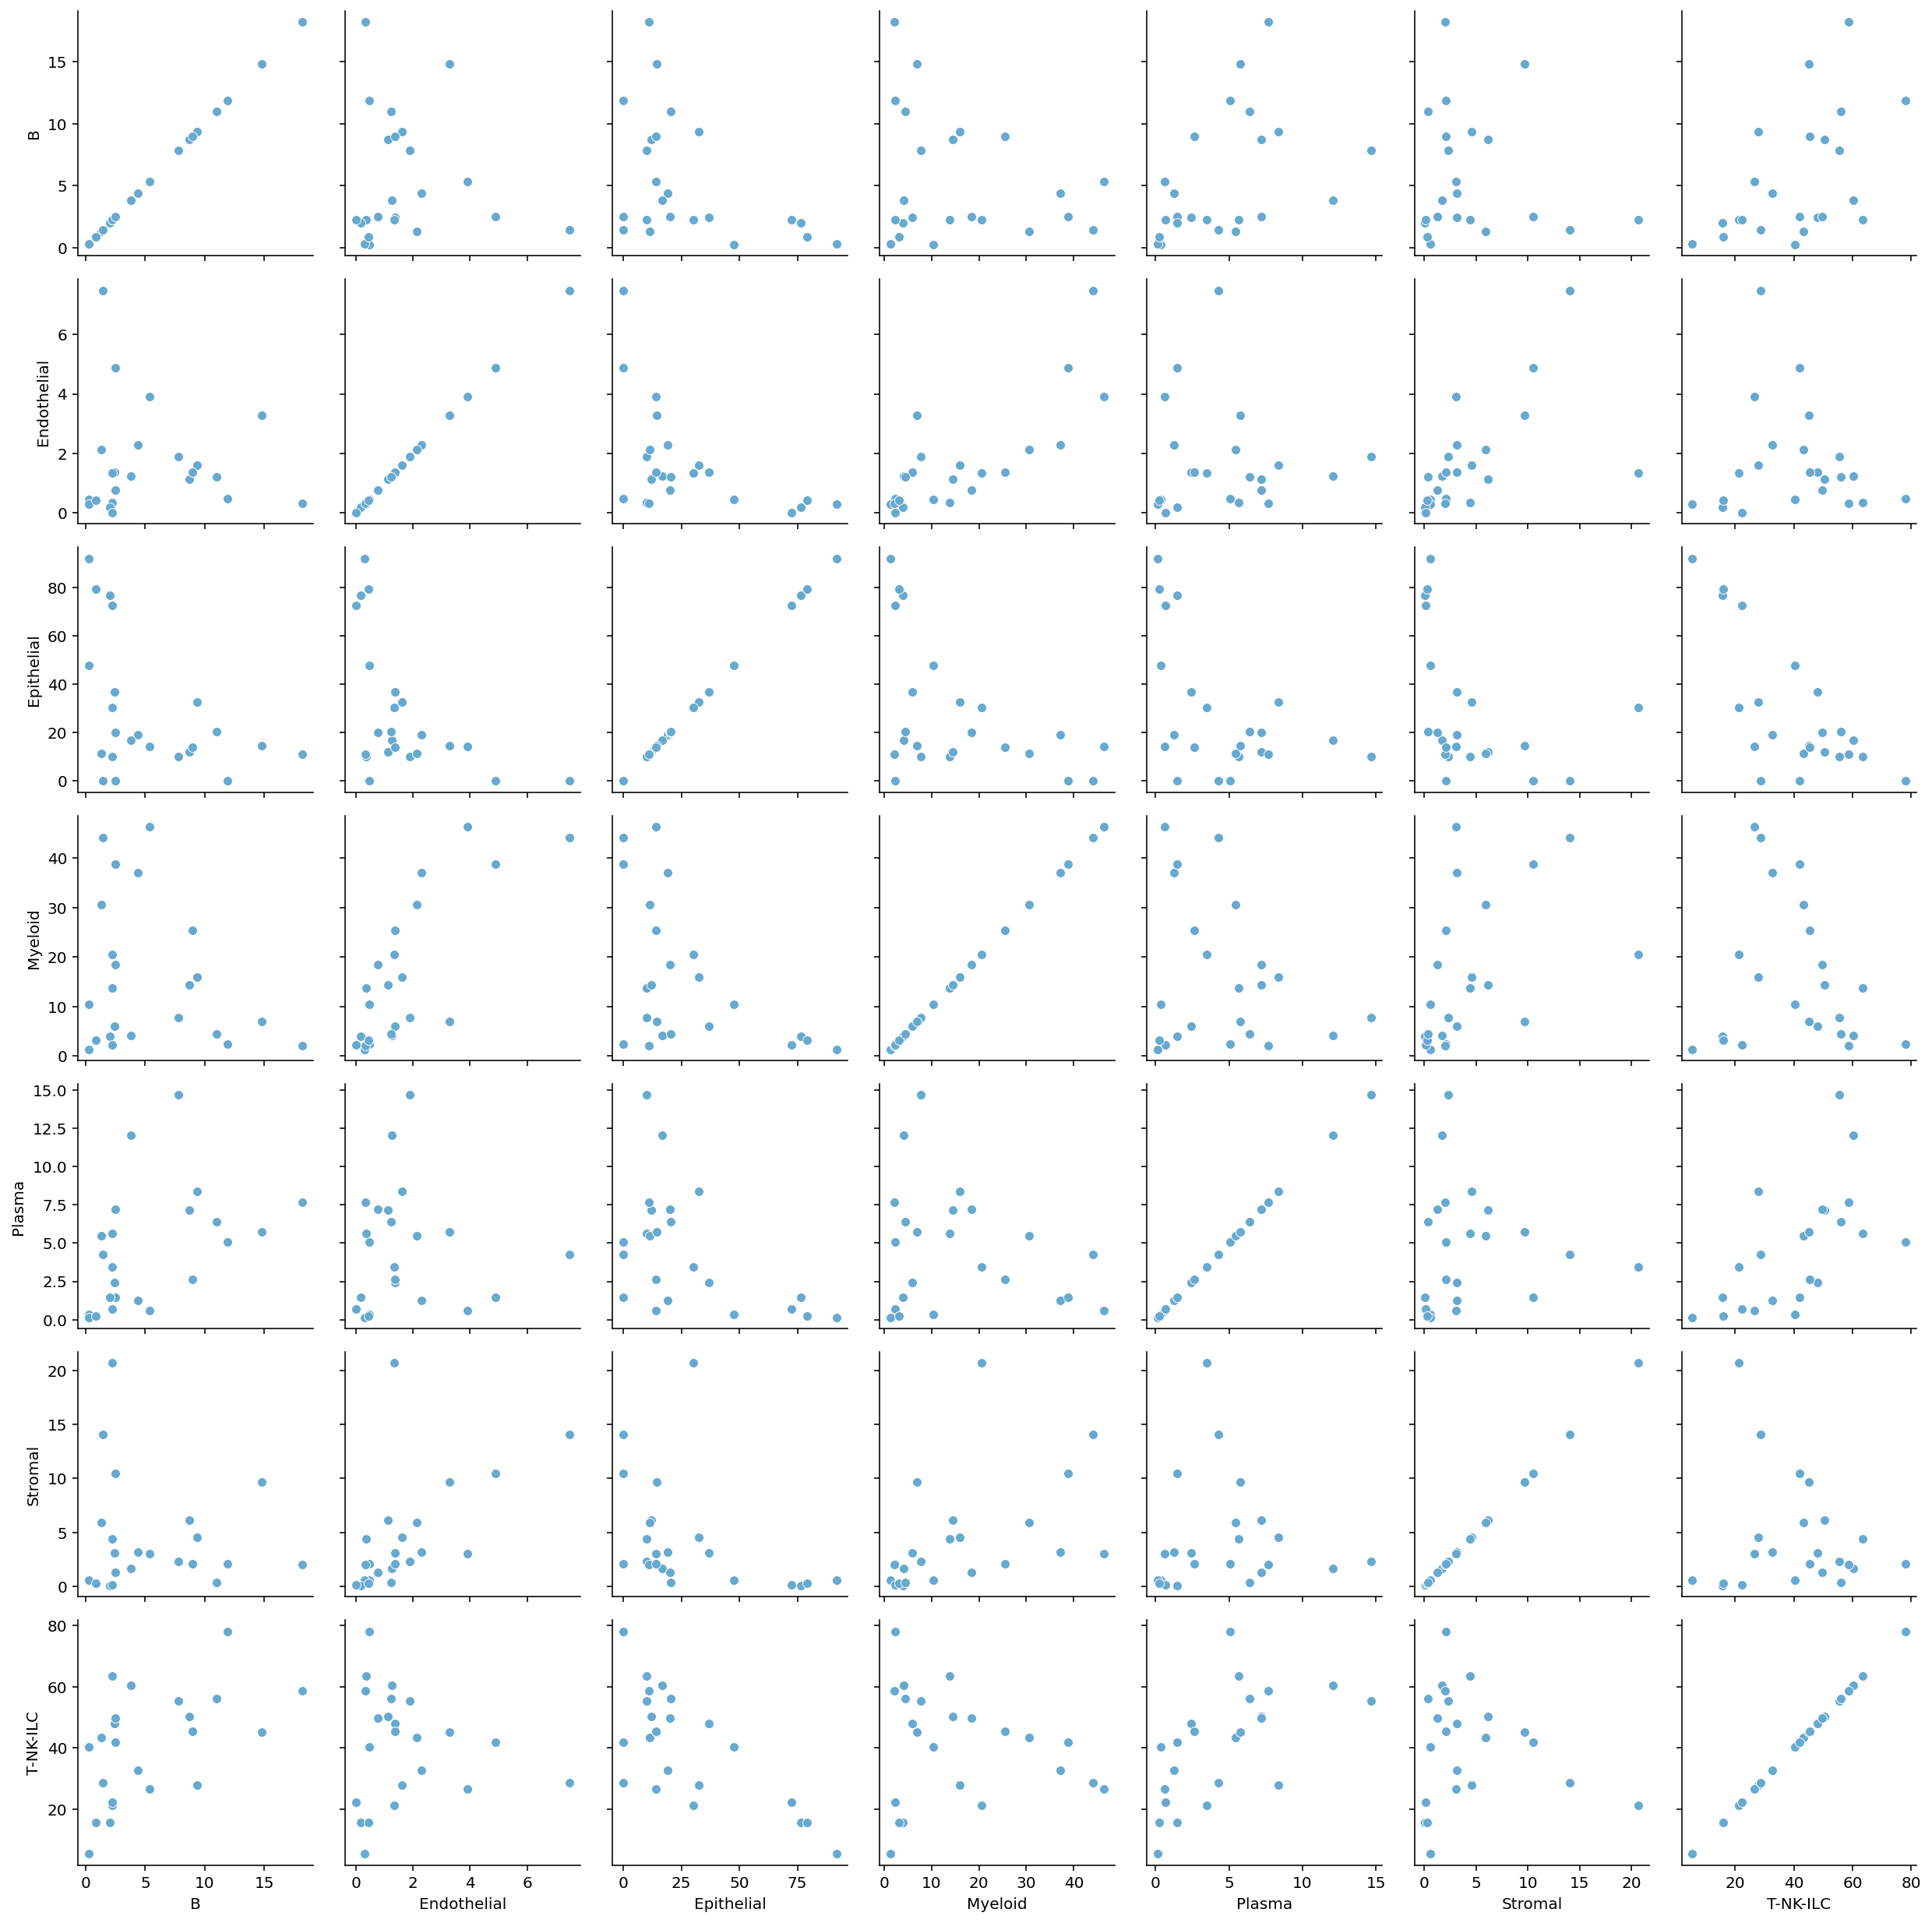

In [19]:
# plot scatterpplot to show relationship between variables
def scatterplot_celltype(df, name2save):
    g = sns.PairGrid(df)
    g.map(sns.scatterplot, color="#67A9CF")
    g.savefig(FIG2SAVE.joinpath(f"scatterplot_proportions_{name2save}.pdf"), 
                    dpi=DPI, 
                    format="pdf",
                    bbox_inches="tight")

scatterplot_celltype(prop_major, f"{cell_source}_major_celltypes")

In [20]:
def plot_correlation_heatmap(df, corr_method, name2save, figsize=(5,5)):
    corr_df = df.corr(method=corr_method)
    
    # we want to make a triangular heatmap
    # create a mask for upper triangle
    # generate a mask of ones with same shape as corr_df, converts to True with bool type
    # apply triangular, upper part is true, lower is false
    mask = np.triu(np.ones_like(a=corr_df, dtype=bool))
    
    fig, ax = plt.subplots(nrows=1,
                           ncols=1, 
                           sharey=False,
                           sharex=False,
                           dpi=DPI,
                           figsize=figsize
                          )
    sns.heatmap(data=corr_df, 
            mask=mask, 
            cmap="vlag", 
            robust=True,
            cbar_kws={'label': f'{corr_method} correlation'}, 
            square=True, 
            linewidths=.5,
            ax=ax
           )
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    fig.savefig(FIG2SAVE.joinpath(f"{corr_method}_correlation_heatmap_{name2save}.pdf"), 
                dpi=DPI, 
                format="pdf",
                bbox_inches="tight")

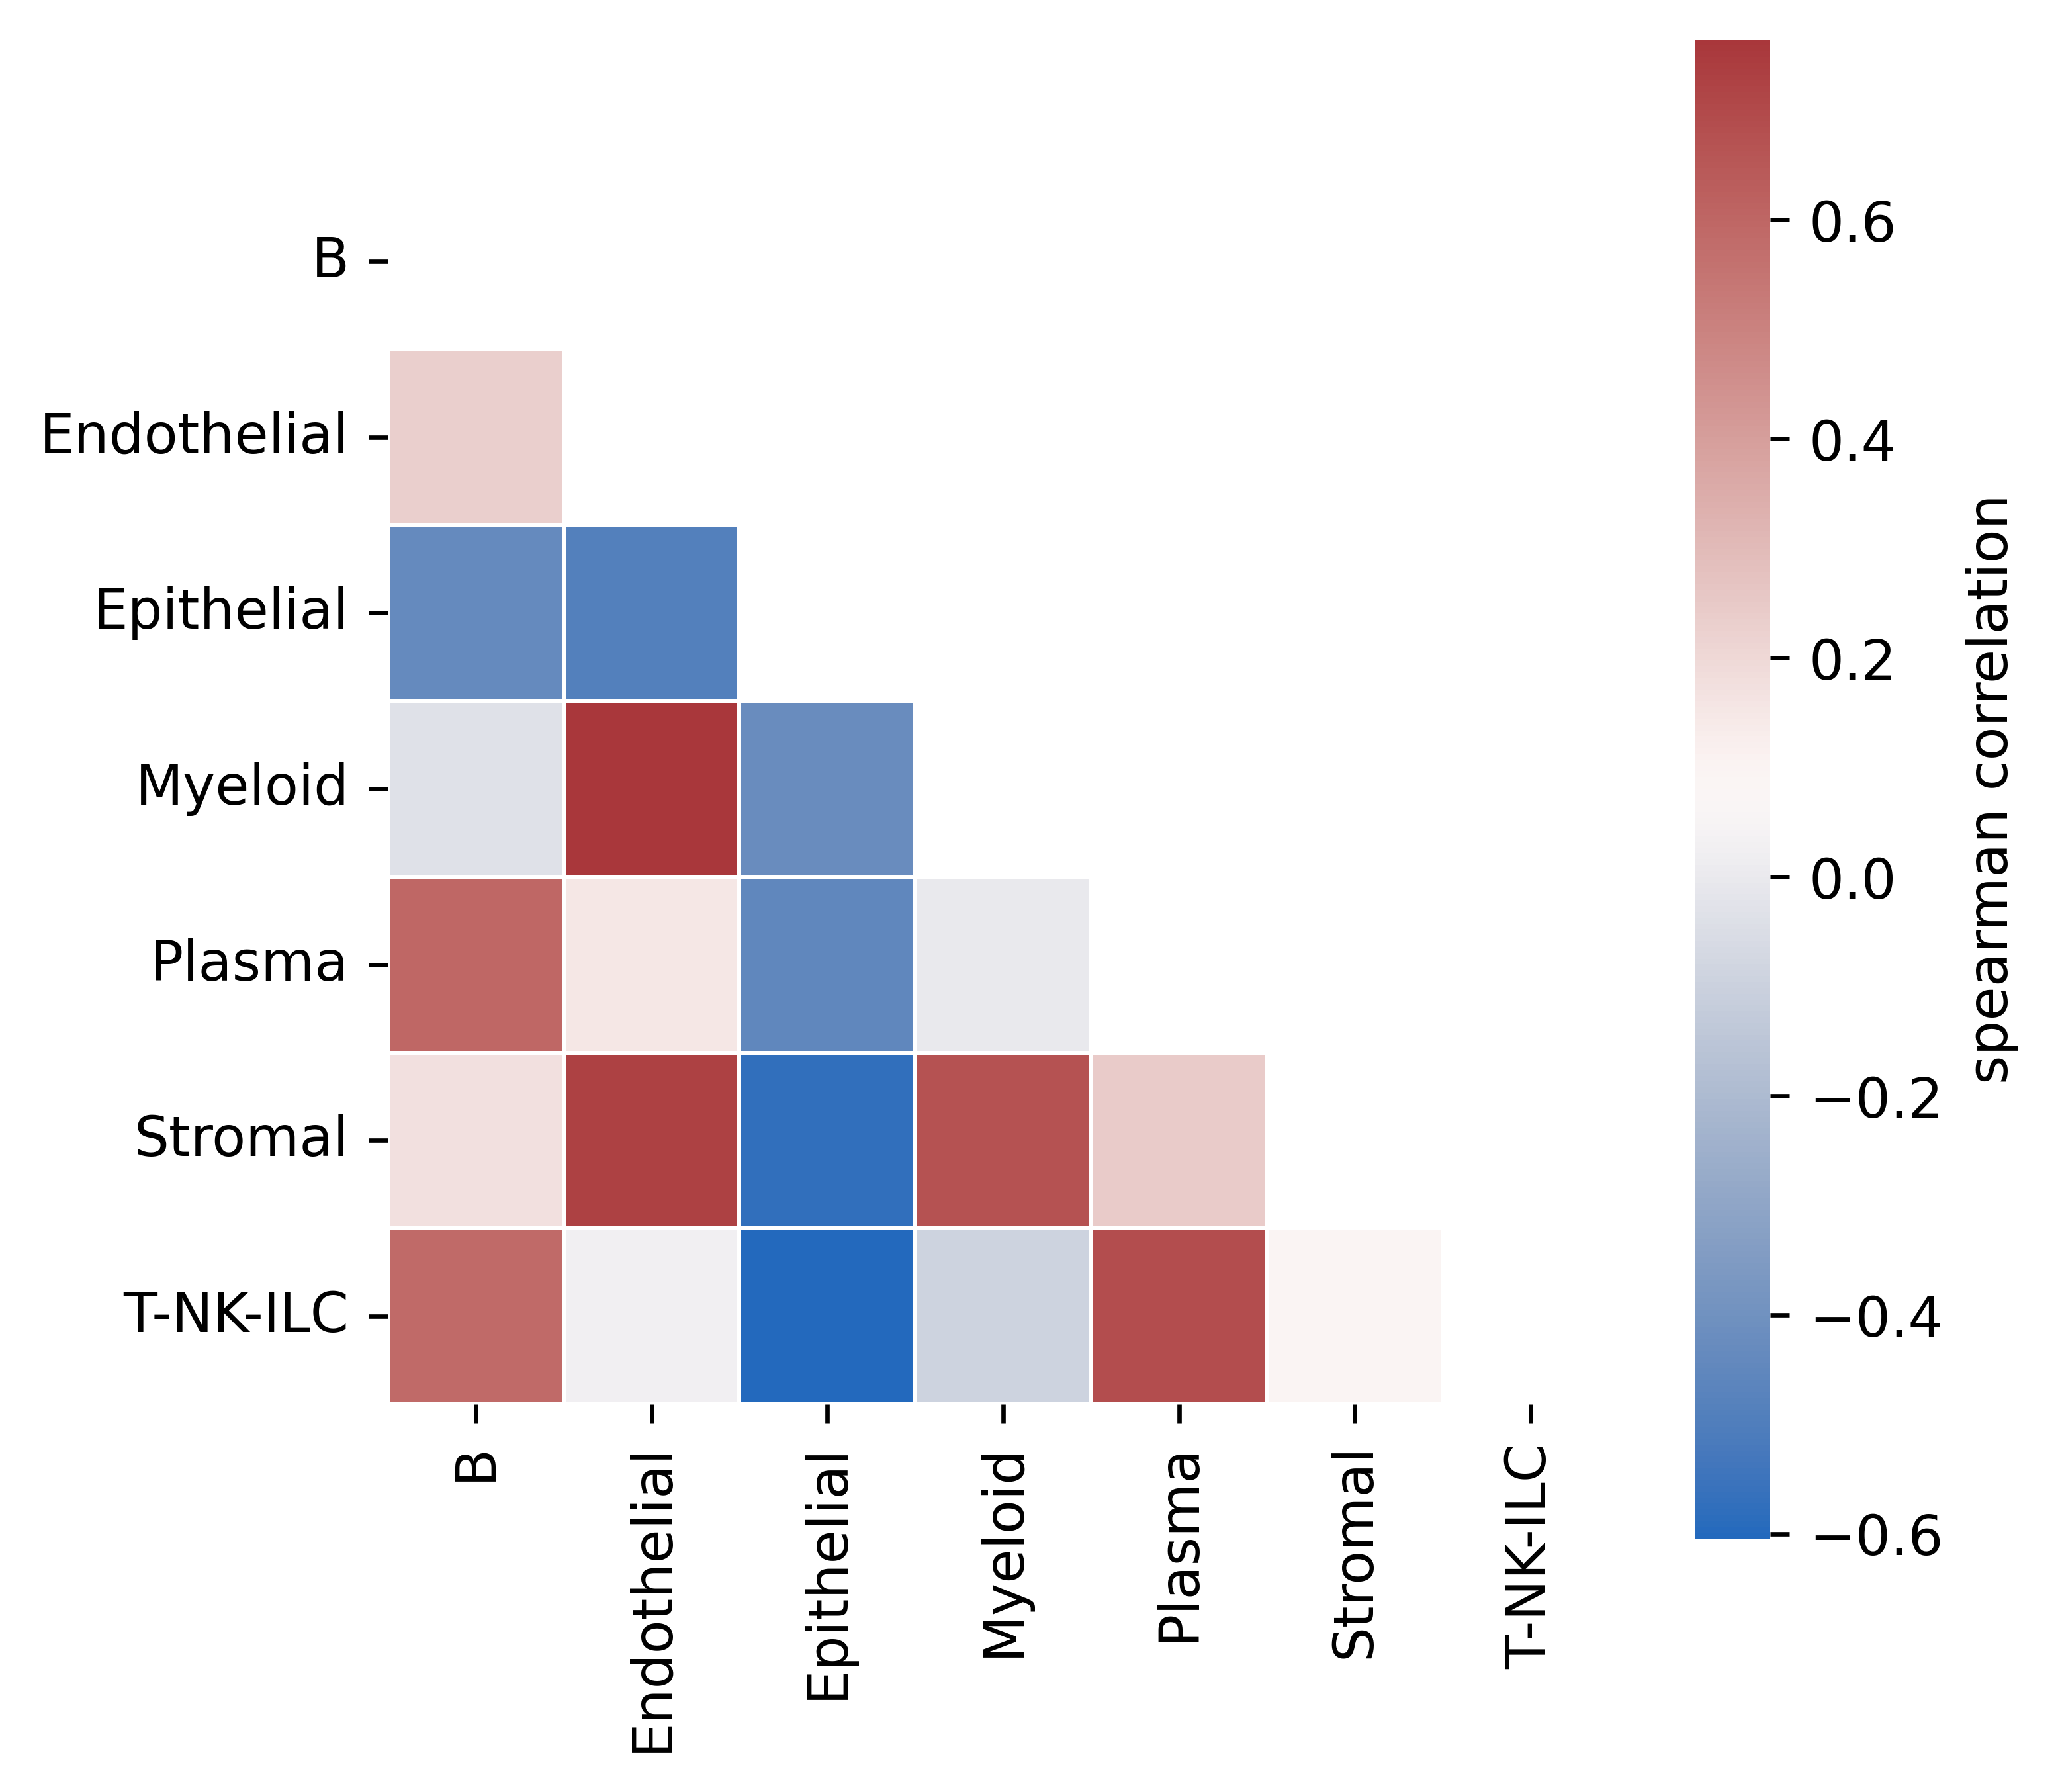

In [21]:
plot_correlation_heatmap(df=prop_major, 
                         corr_method="spearman", 
                         name2save=f"{cell_source}_major_celltypes")

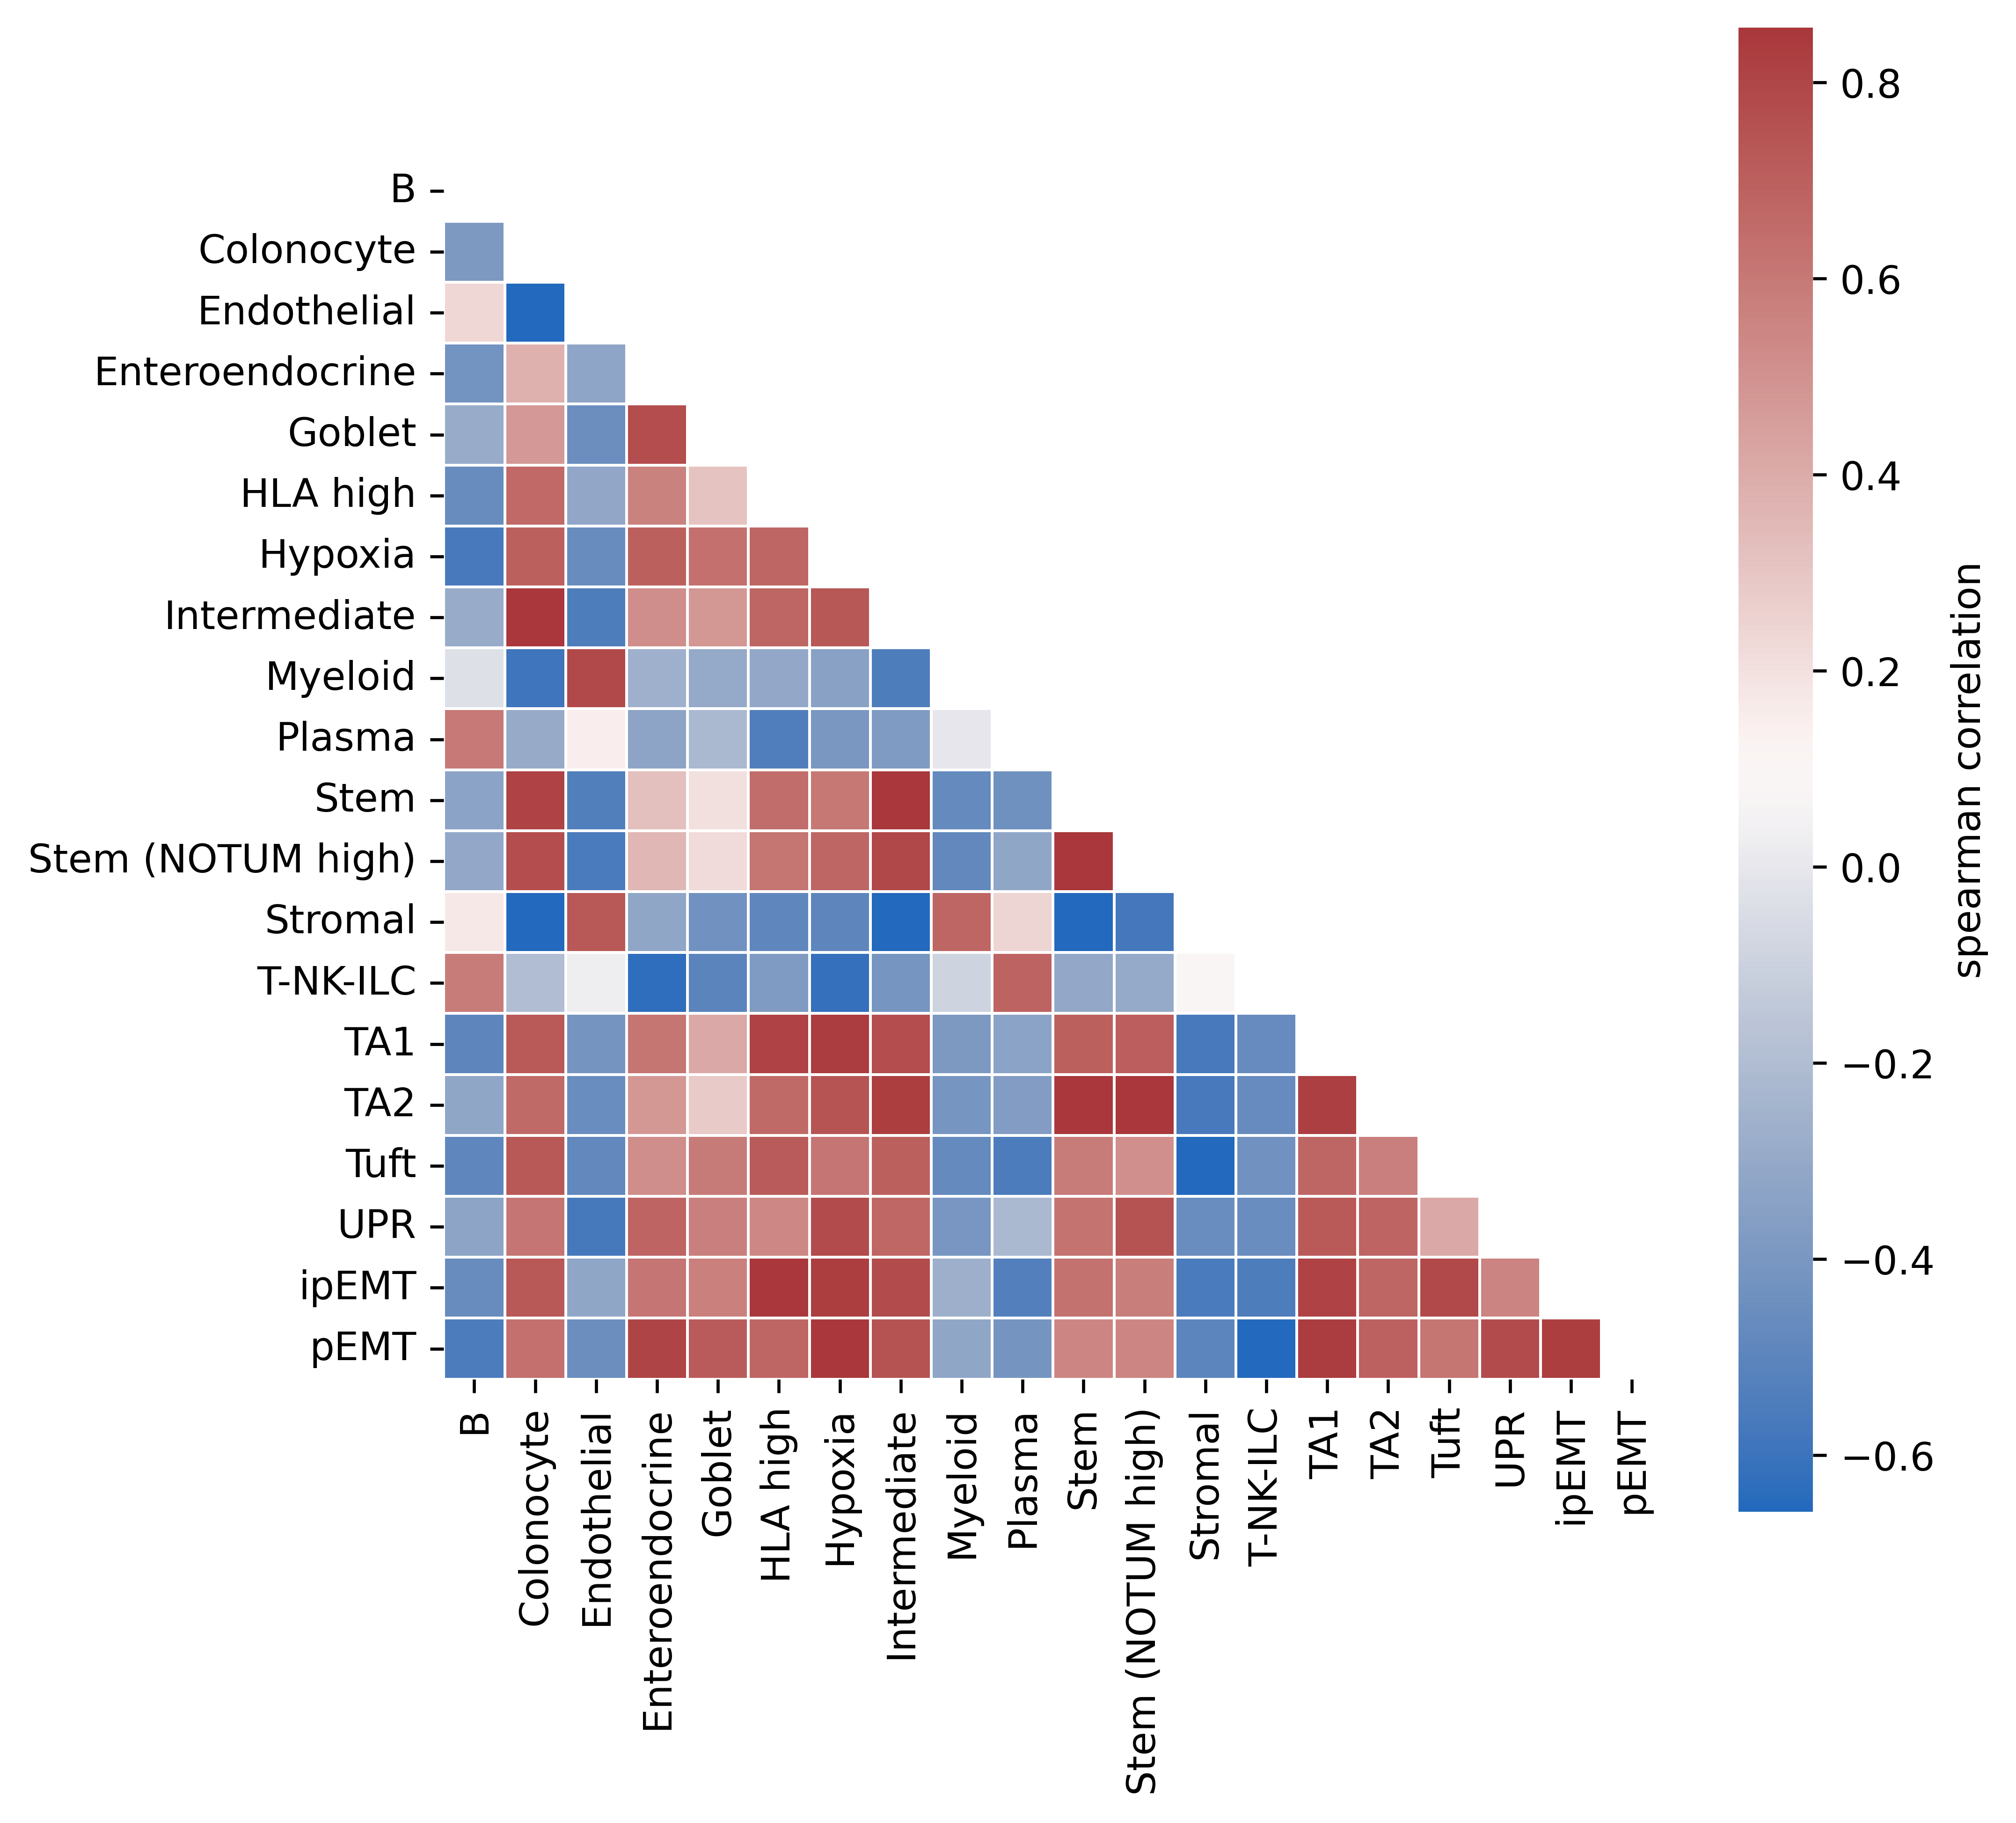

In [22]:
plot_correlation_heatmap(df=prop_majorTME_cancer_states, 
                         corr_method="spearman", 
                         name2save=f"{cell_source}_major_TME_cancer_states", 
                         figsize=(7,7))

In [23]:
plot_correlation_heatmap(df=prop_subsets, 
                         corr_method="spearman", 
                         name2save=f"{cell_source}_subsets", 
                         figsize=(15,15))

In [24]:
corr_df = prop_subsets.corr(method="spearman")

In [25]:
corr_df

Annotation_scVI_detailed         B  C1QC Mac   C3 iCAF   CD4 Tfh    CD4 Th  \
Annotation_scVI_detailed                                                     
B                         1.000000 -0.008893  0.359893  0.480237  0.302372   
C1QC Mac                 -0.008893  1.000000  0.398815  0.078063  0.021739   
C3 iCAF                   0.359893  0.398815  1.000000  0.028258 -0.192476   
CD4 Tfh                   0.480237  0.078063  0.028258  1.000000  0.284585   
CD4 Th                    0.302372  0.021739 -0.192476  0.284585  1.000000   
CD4 Th17                  0.132411 -0.240119 -0.368957  0.122530  0.071146   
CD4 Th HSP                0.424333  0.250247  0.340502  0.174085  0.049456   
CD4 Tn                    0.671937  0.195652  0.144490  0.377470  0.472332   
CD8 Tem                   0.504941  0.347826  0.374289  0.523715  0.345850   
CD8 Tem HSP               0.317979  0.217800  0.218634  0.238235  0.060306   
CD8 Tex                   0.112648 -0.011858  0.004799  0.739130  0.158103   
CXCL14 BMP CAF            0.137488  0.113749 -0.057640  0.009891 -0.057369   
Colonocyte               -0.389798 -0.499259 -0.607990 -0.155523 -0.400695   
Endo cycling             -0.031289  0.584894  0.281556  0.083268  0.155938   
Enteric glial             0.135814  0.340140  0.361827  0.062450  0.183106   
Enteroendocrine          -0.425894 -0.201423 -0.094083 -0.422887 -0.565186   
FCGR3A Mono               0.166031  0.529887  0.129341  0.306830  0.191769   
FCN1 Mono                 0.180830  0.691700  0.264455  0.127470  0.172925   
GREM1 HSP CAF             0.156514  0.605747  0.558282  0.218426  0.203071   
Goblet                   -0.291065 -0.201852 -0.228584 -0.444074 -0.295551   
HLA high                 -0.461969 -0.316664 -0.322803 -0.154324 -0.612285   
HSP Mono                 -0.028409  0.578641  0.342339 -0.060805 -0.052830   
Hypoxia                  -0.565133 -0.179793 -0.211661 -0.429422 -0.752355   
IL1B Mac                 -0.268775  0.780632  0.383353 -0.247036  0.008893   
ILC3                      0.299904  0.113209 -0.027327  0.411127  0.608746   
Intermediate             -0.288823 -0.486647 -0.517158 -0.280910 -0.602374   
Lymphatic endo            0.009420  0.019887  0.324732  0.001047 -0.130833   
MMP CAF                   0.037118  0.632041  0.501257 -0.097951  0.212914   
Myeloid cycling          -0.231282  0.548060  0.073863 -0.128984  0.085990   
Myofibroblast             0.218458  0.571198  0.648849  0.021044  0.200421   
NK1                       0.343958  0.343464  0.334917  0.347912  0.267853   
NK2                       0.531621  0.380435  0.259656  0.363636  0.449605   
NKT                       0.317194  0.385375  0.280983  0.273715  0.488142   
NLRP3 Mac                -0.124506  0.769763  0.306576 -0.027668 -0.001976   
Neutrophil                0.214870  0.285249  0.079689 -0.000533  0.263388   
PLTP LYVE1 Mac            0.072268  0.804416  0.403384  0.011463 -0.037380   
Pericyte                  0.098839  0.485792  0.426379  0.268841  0.347418   
Plasma                    0.598814  0.180830  0.062915  0.532609  0.351779   
SMC                       0.266073  0.427300  0.428030  0.125618  0.472799   
SPP1 Mac                 -0.122530  0.770751  0.411611 -0.118577  0.025692   
Stalk-like endo           0.392292  0.575099  0.475059  0.129447  0.093874   
Stem                     -0.338287 -0.427936 -0.454055 -0.168401 -0.520556   
Stem (NOTUM high)        -0.306627 -0.391692 -0.362384 -0.124629 -0.553907   
T cycling                -0.011858  0.350791  0.028258  0.522727  0.000000   
TA1                      -0.497527 -0.270030 -0.328227 -0.326410 -0.765579   
TA2                      -0.317508 -0.306627 -0.301542 -0.266073 -0.692384   
Tip-like endo             0.101310  0.550037  0.291452  0.144799  0.085990   
Treg                     -0.028663  0.488263  0.038131  0.454164  0.211021   
Treg HSP                  0.498024  0.344862  0.460130  0.507905  0.215415   
Tuft                  

In [26]:
corr_df.to_csv(DIR2SAVE.joinpath(f"{cell_source}_subsets_spearman_correlation_df.csv"))

In [27]:
corr_df.loc['pEMT', 'Tip-like endo']

-0.3764532325020119

In [28]:
from scipy.stats import spearmanr

def s_pvalues(df):
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    coeff = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            res = spearmanr(tmp[r], tmp[c])
            p[r][c] = round(res[1], 4)
            coeff[r][c] = round(res[0], 2)
    return p, coeff

In [29]:
pval, spearman_r = s_pvalues(prop_subsets)

In [30]:
pval.to_csv(DIR2SAVE.joinpath(f"{cell_source}_subsets_spearman_correlation_df_pvalues.csv"))

In [31]:
spearman_r.to_csv(DIR2SAVE.joinpath(f"{cell_source}_subsets_spearman_correlation_df_pvalues_spearcorr.csv"))

In [32]:
f"{cell_source}_subsets_spearman_correlation_df_pvalues_spearcorr.csv"

'SMC_subsets_spearman_correlation_df_pvalues_spearcorr.csv'

In [33]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt')

In [34]:
pval.loc['ipEMT', 'CD8 Tex']

0.6159

In [35]:
pval.loc['ipEMT', 'SPP1 Mac']

0.3444

In [36]:
pval.loc['pEMT', 'SPP1 Mac']

0.2553

In [37]:
pval.loc['pEMT', 'Tip-like endo']

0.0766

In [38]:
pval.loc['pEMT', 'SMC']

0.0007

In [39]:
pval.loc['pEMT', 'MMP CAF']

0.0717

In [40]:
spearman_r.loc['ipEMT', 'SPP1 Mac']

-0.21

In [41]:
spearman_r.loc['Stem (NOTUM high)', 'Plasma']

-0.32

In [42]:
pval.loc['Stem (NOTUM high)', 'Plasma']

0.1399

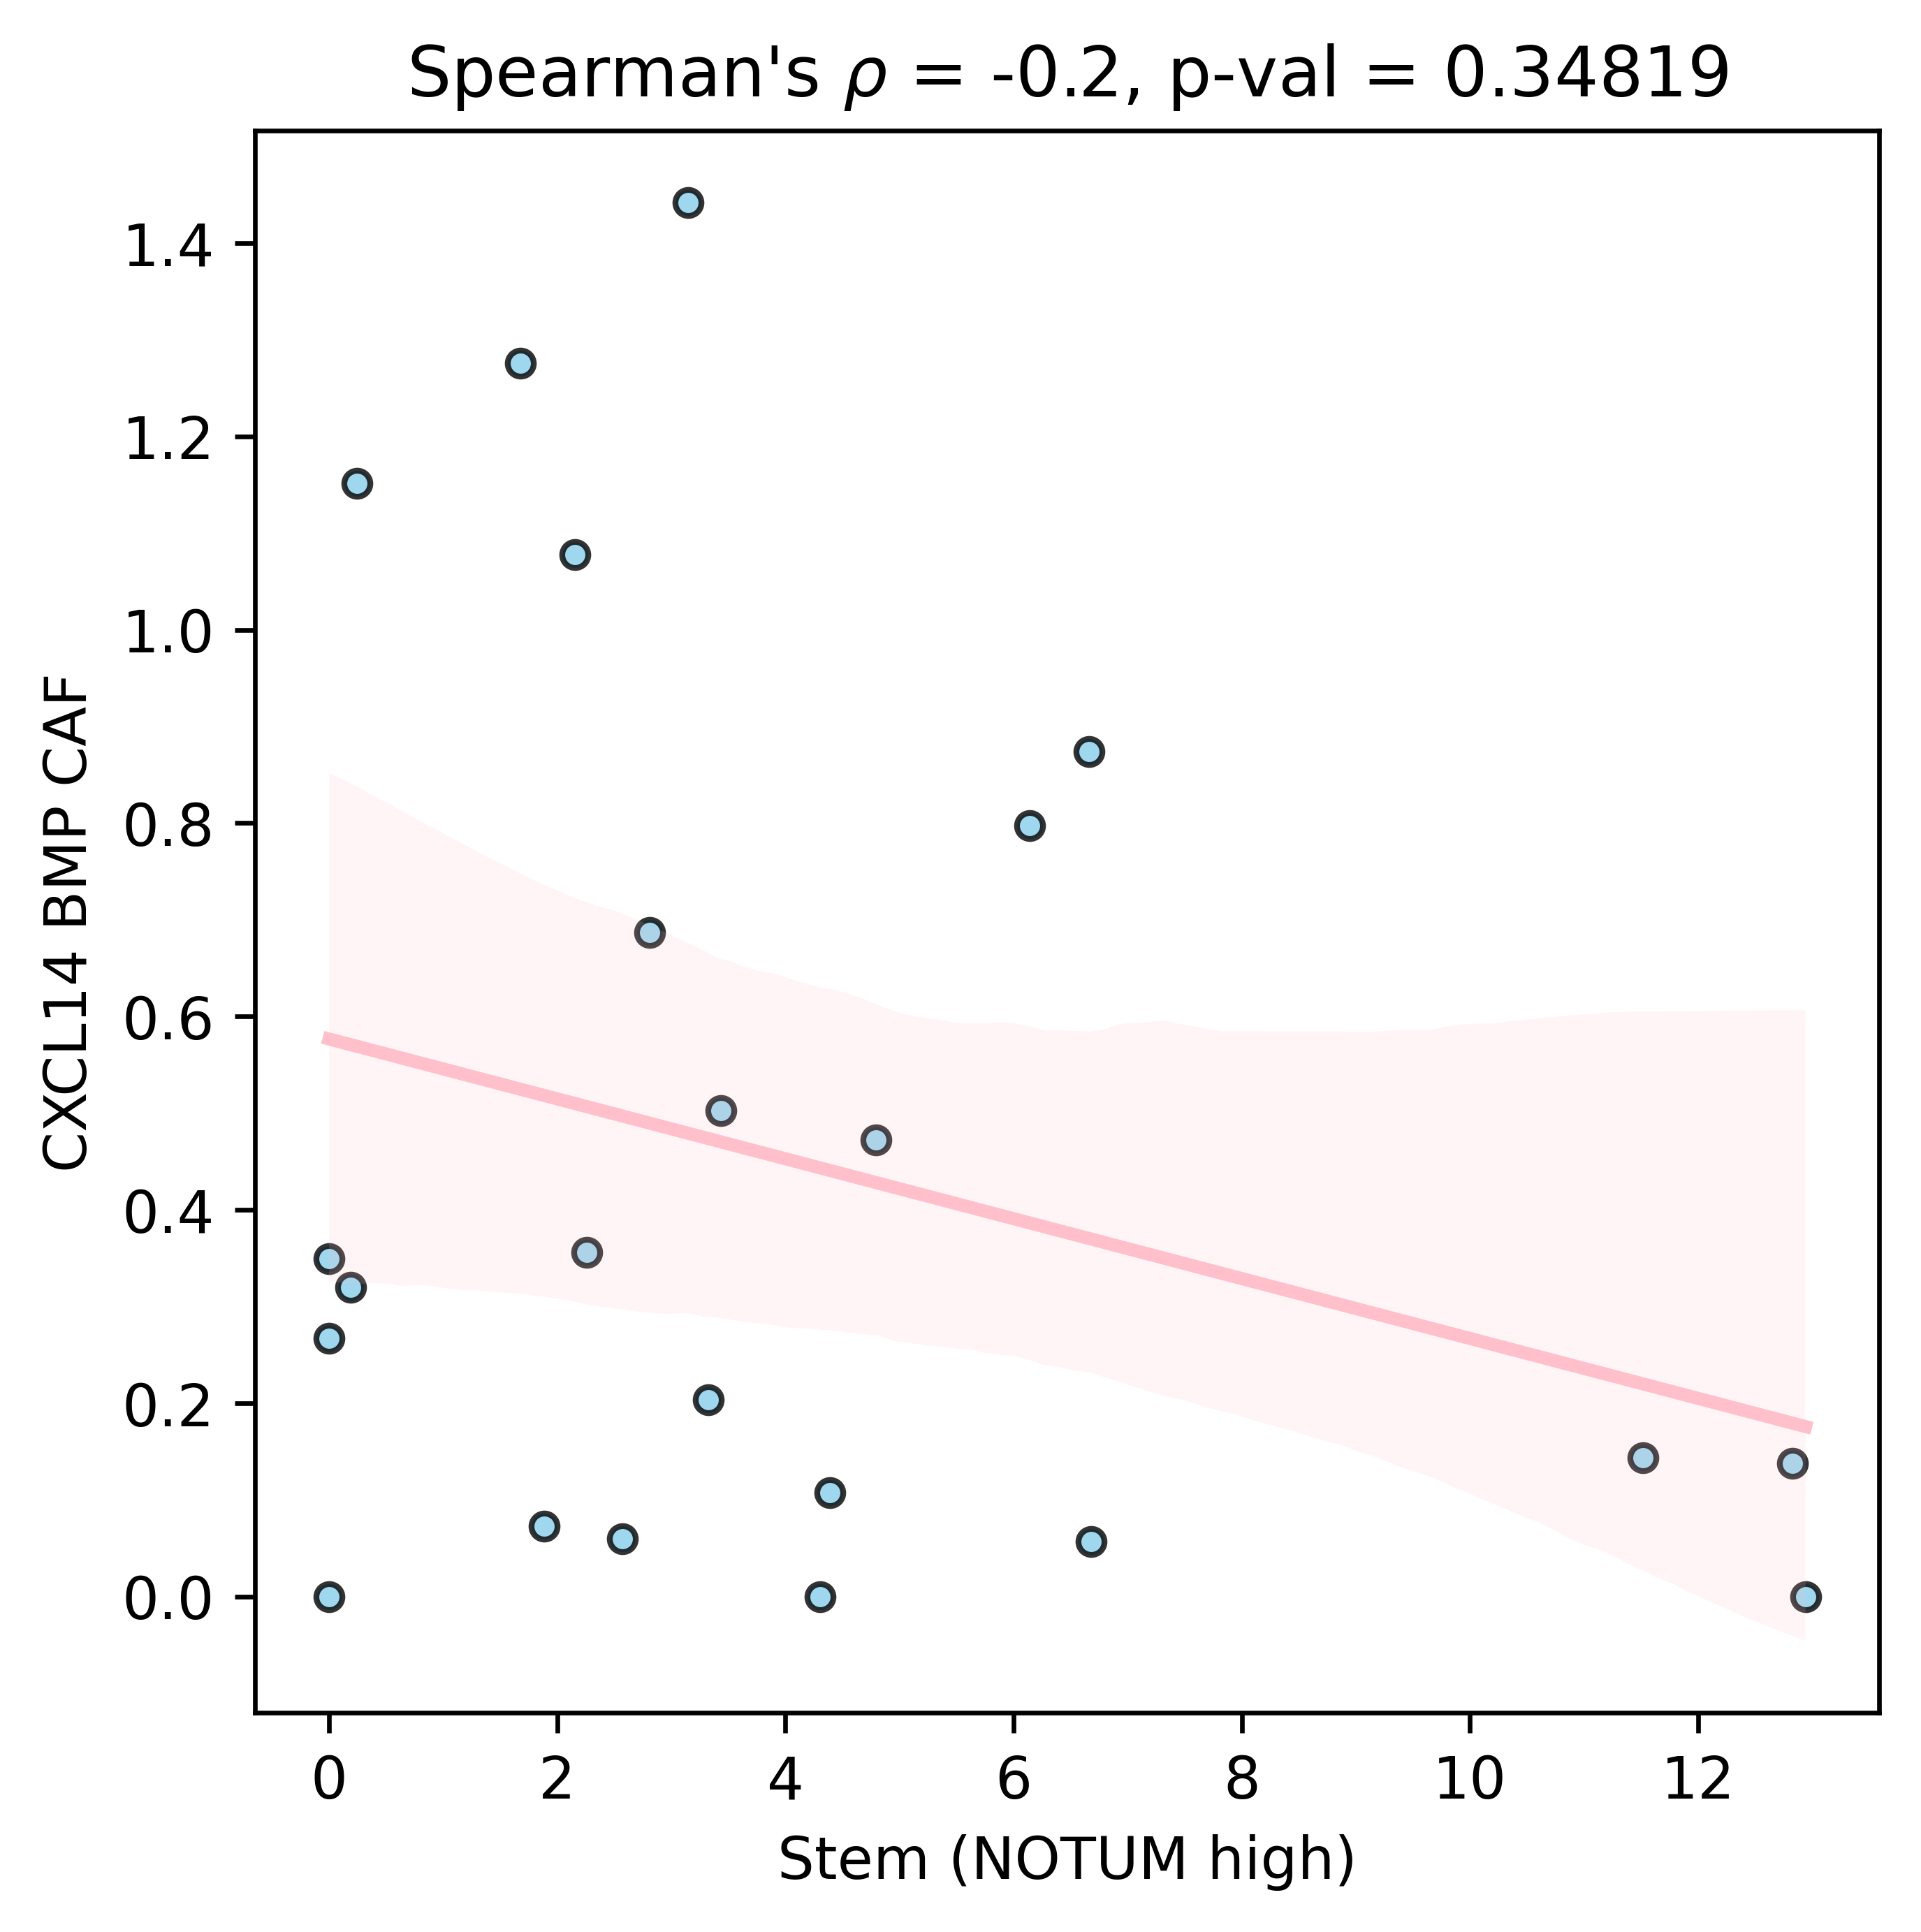

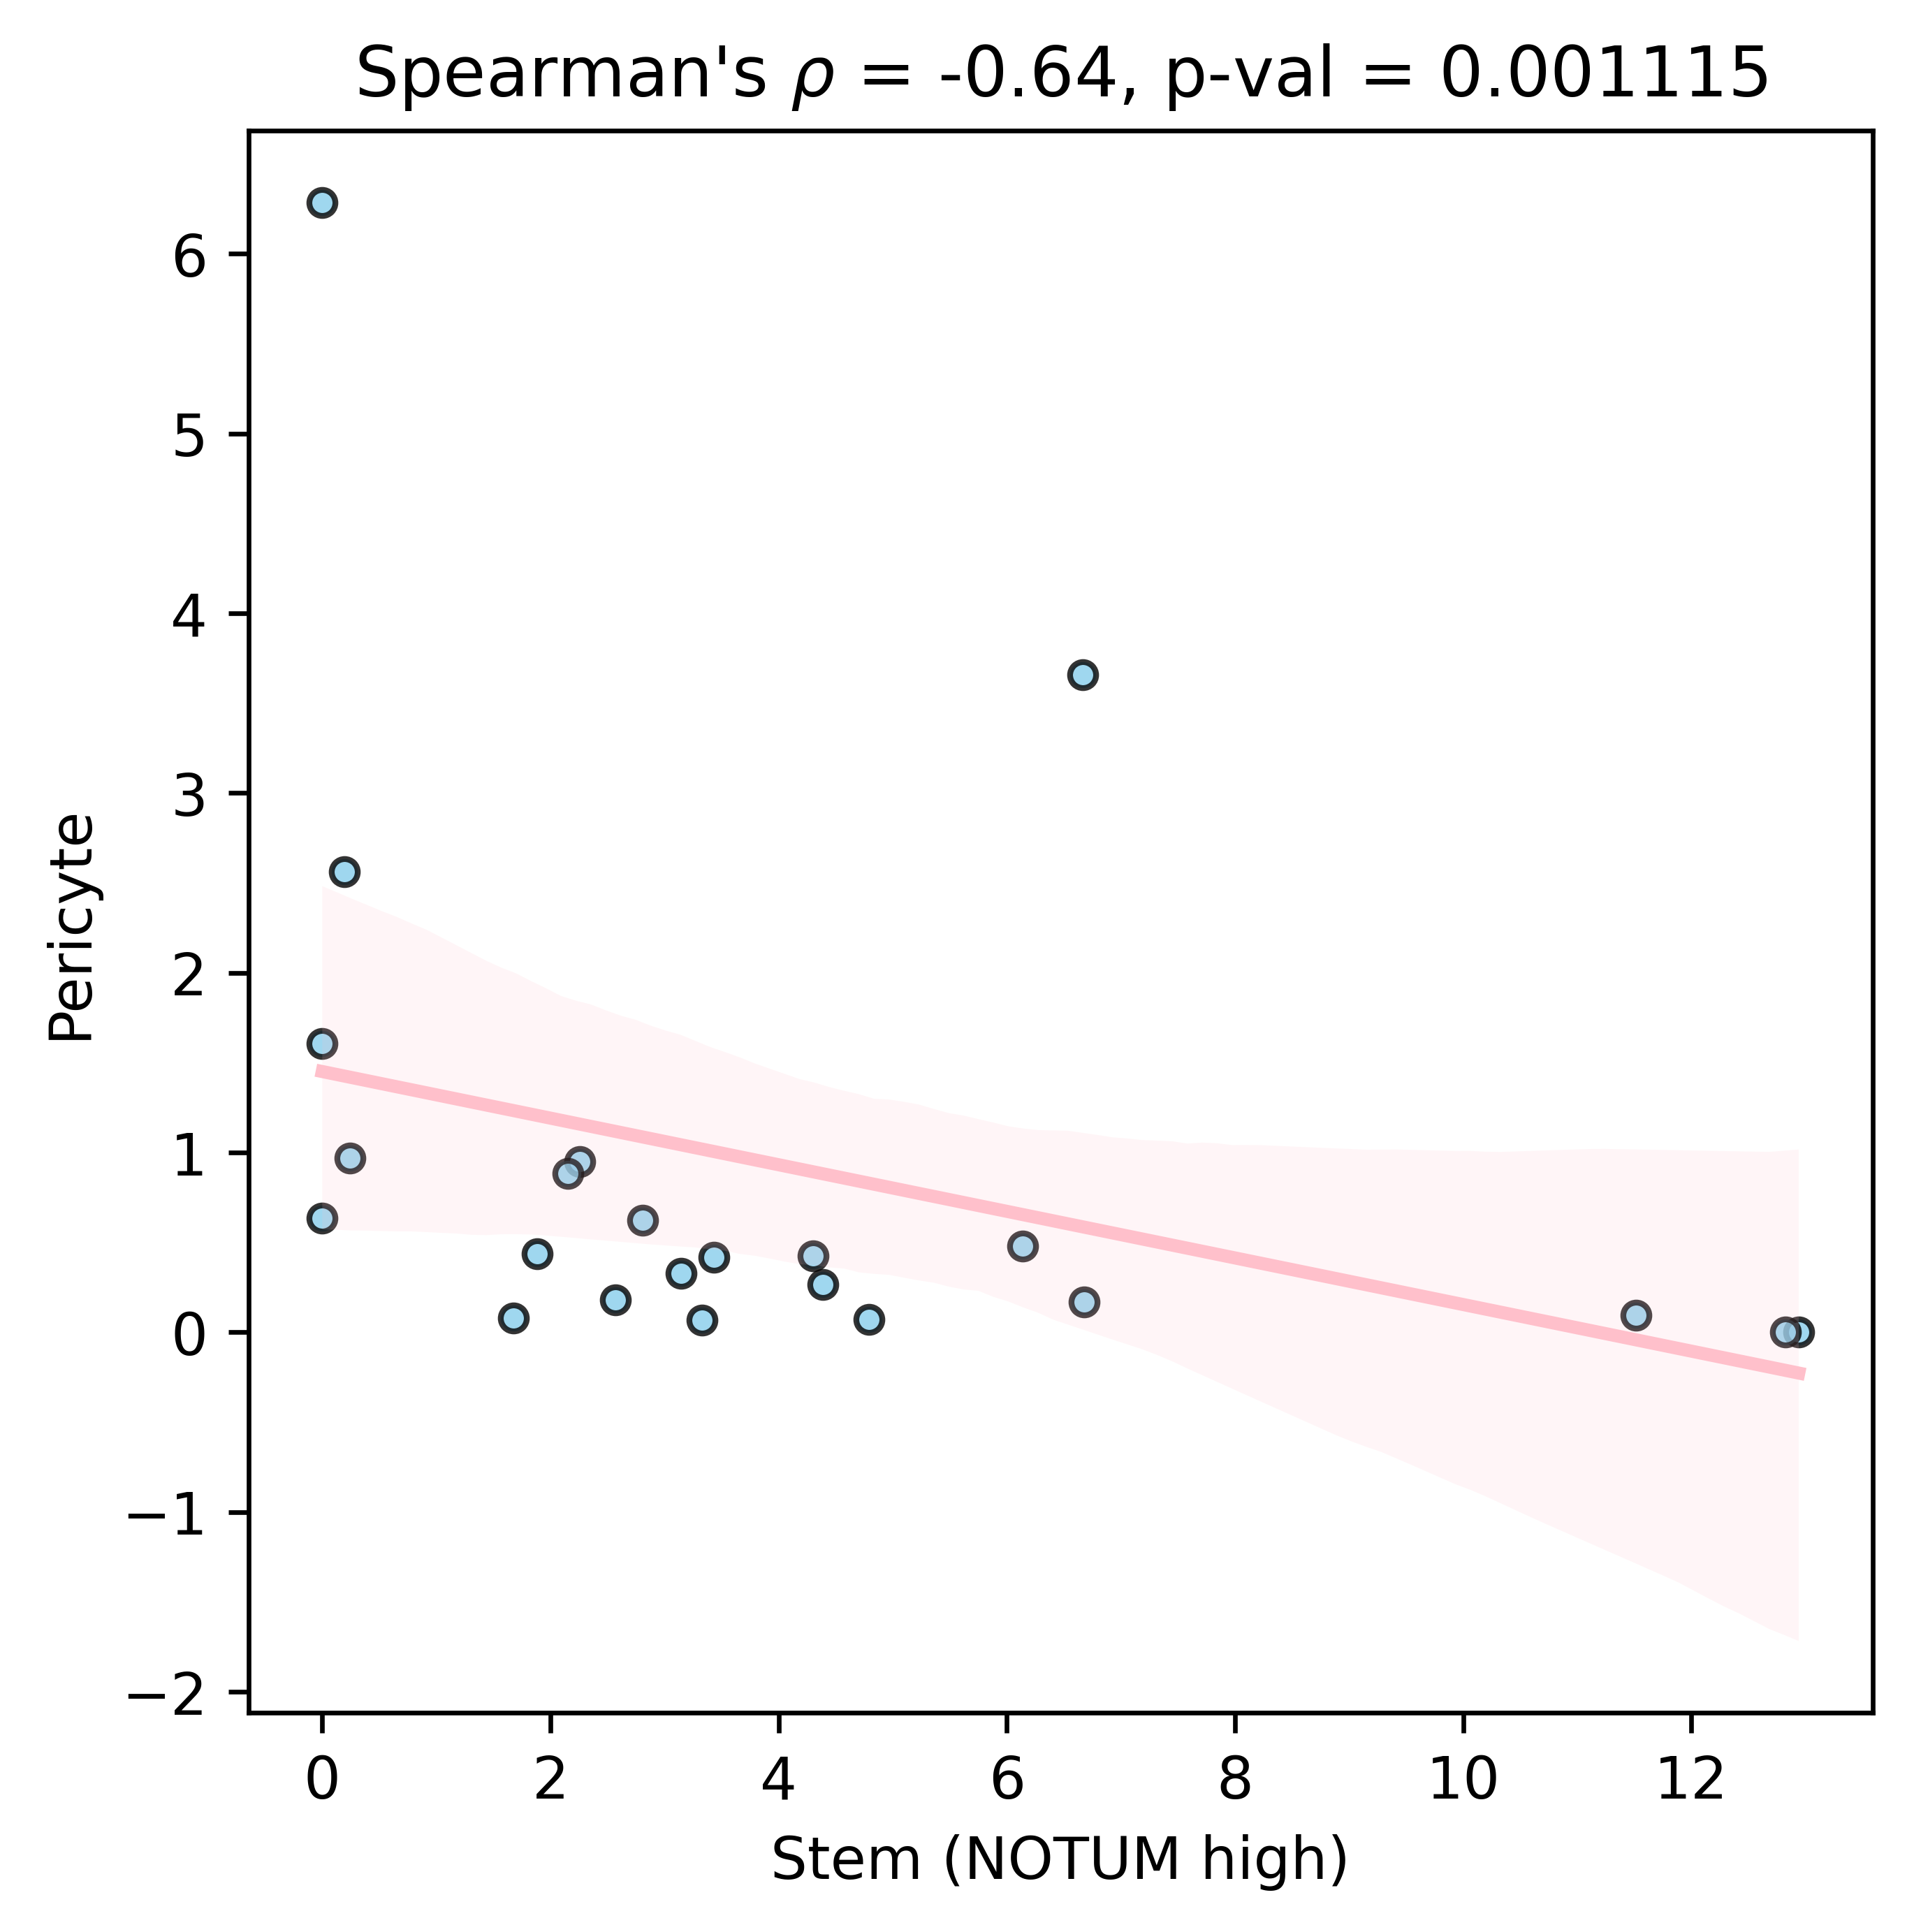

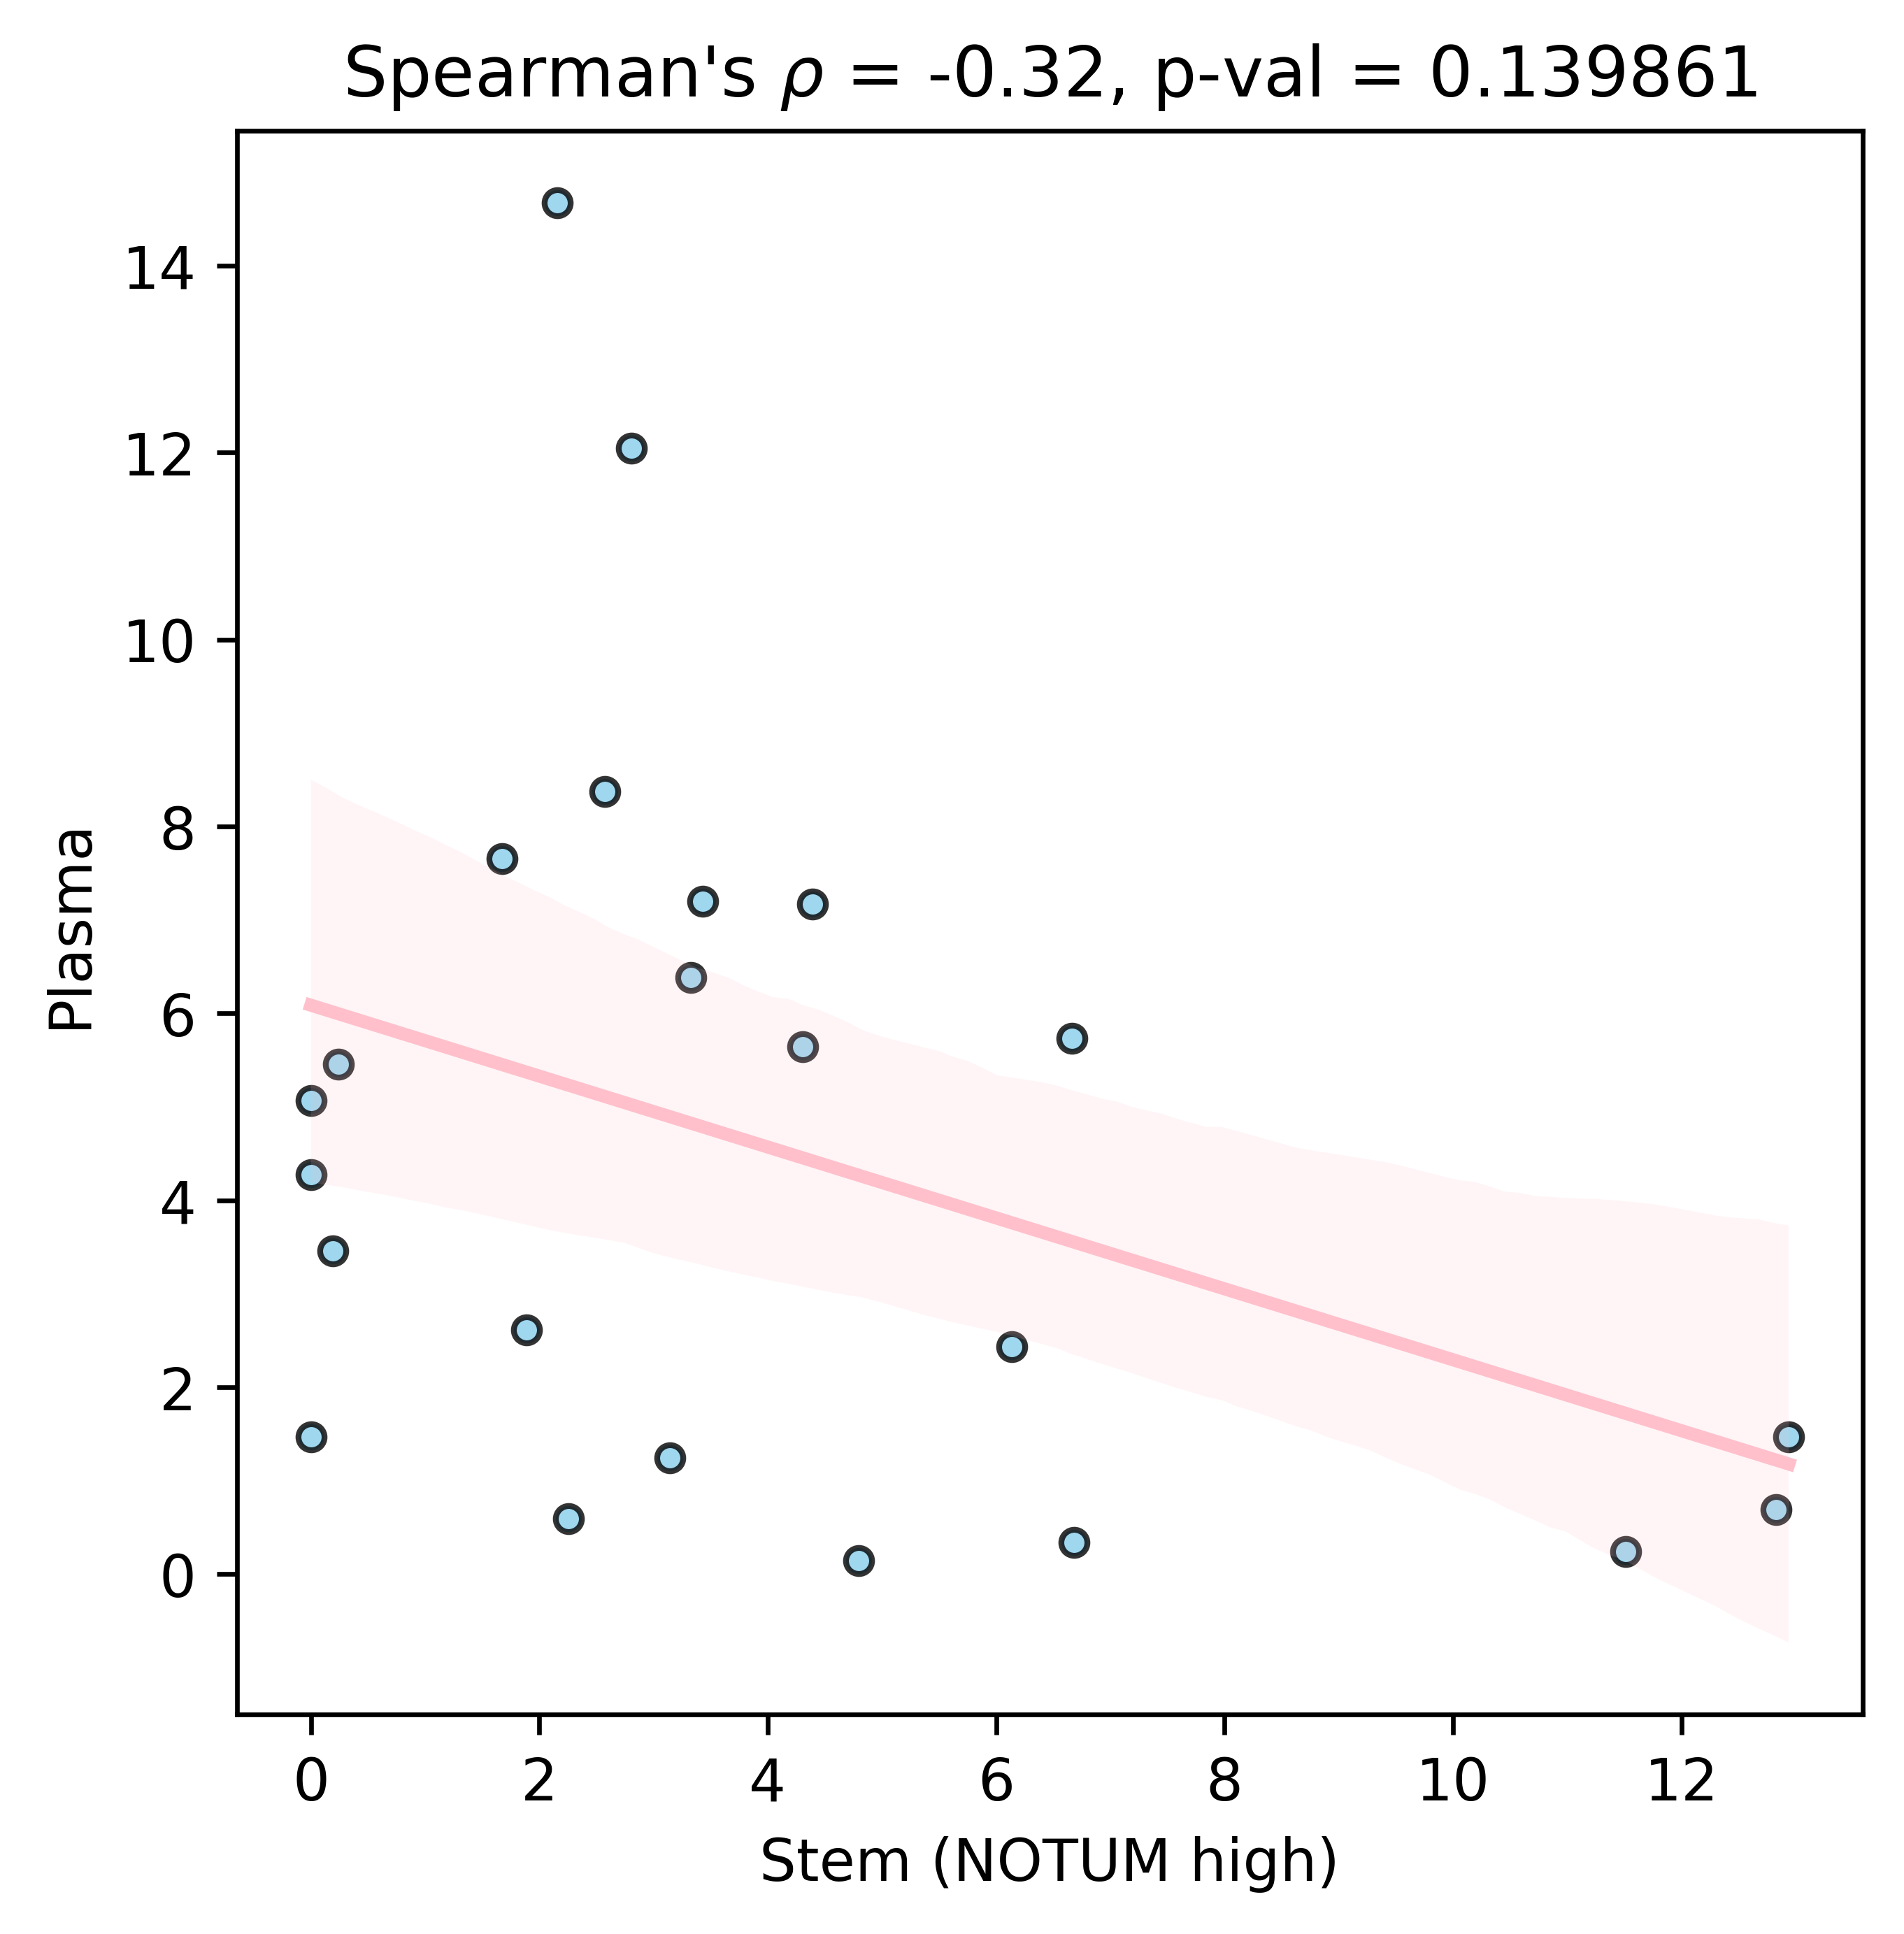

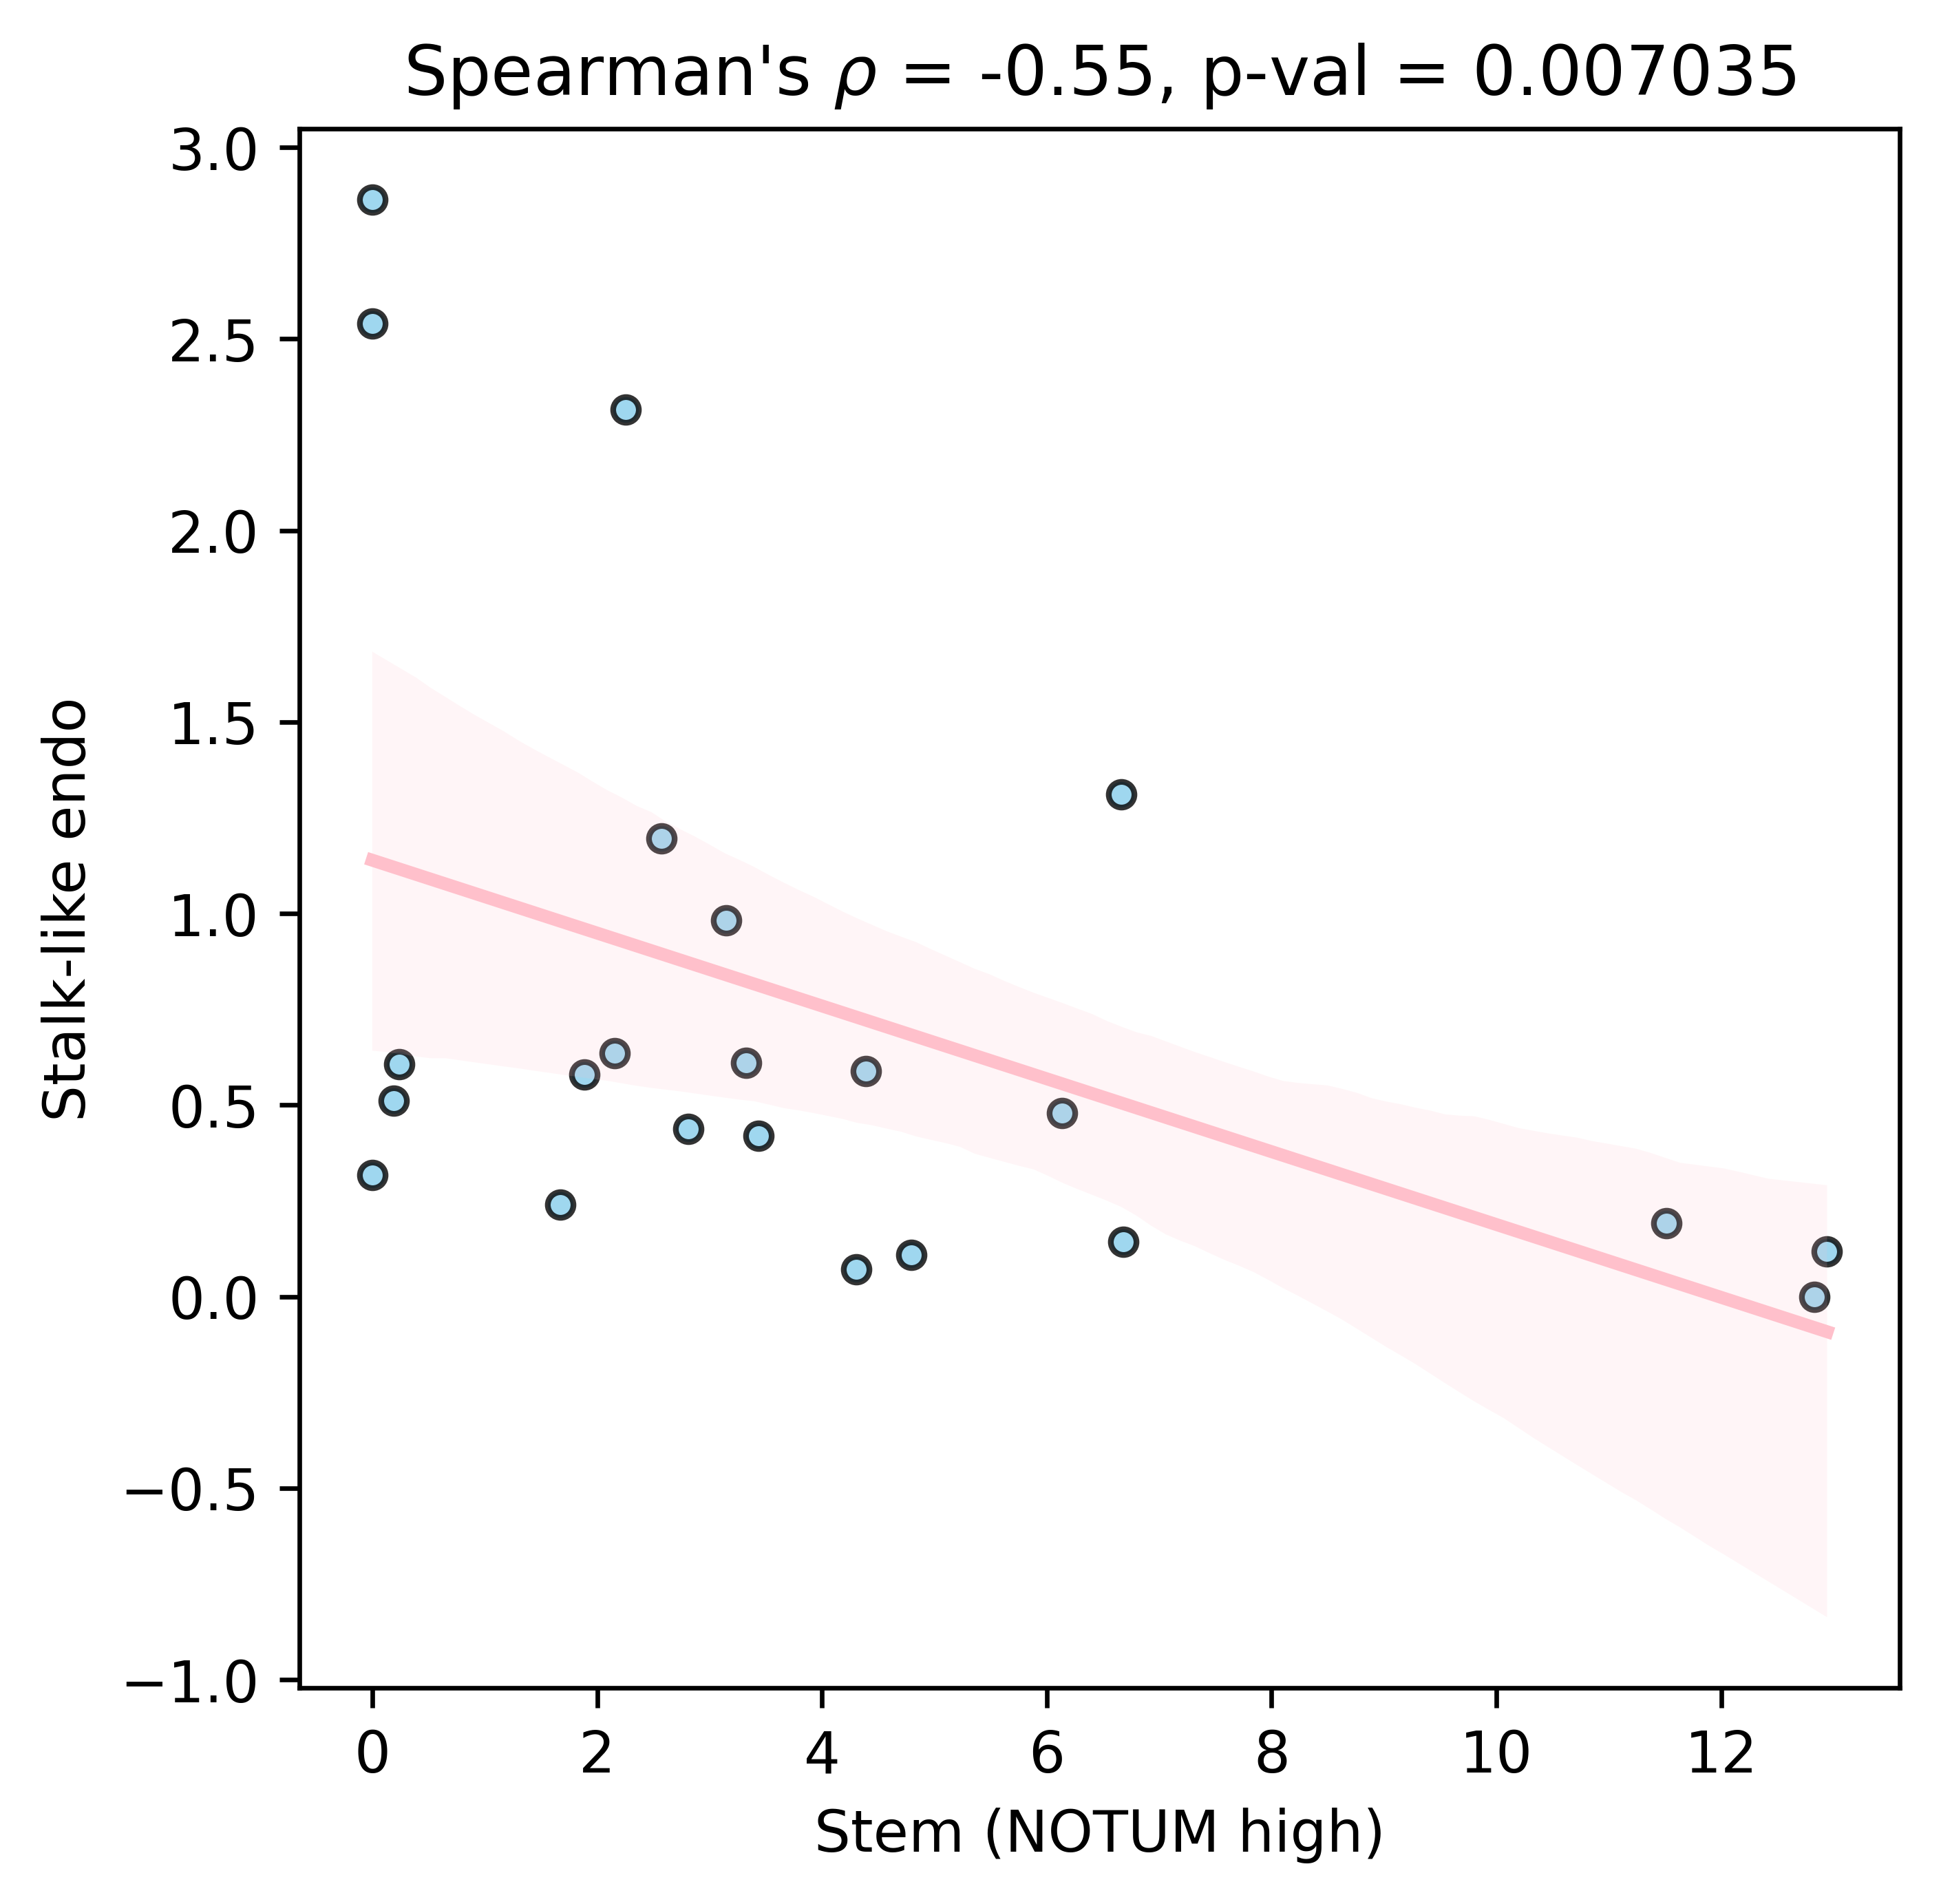

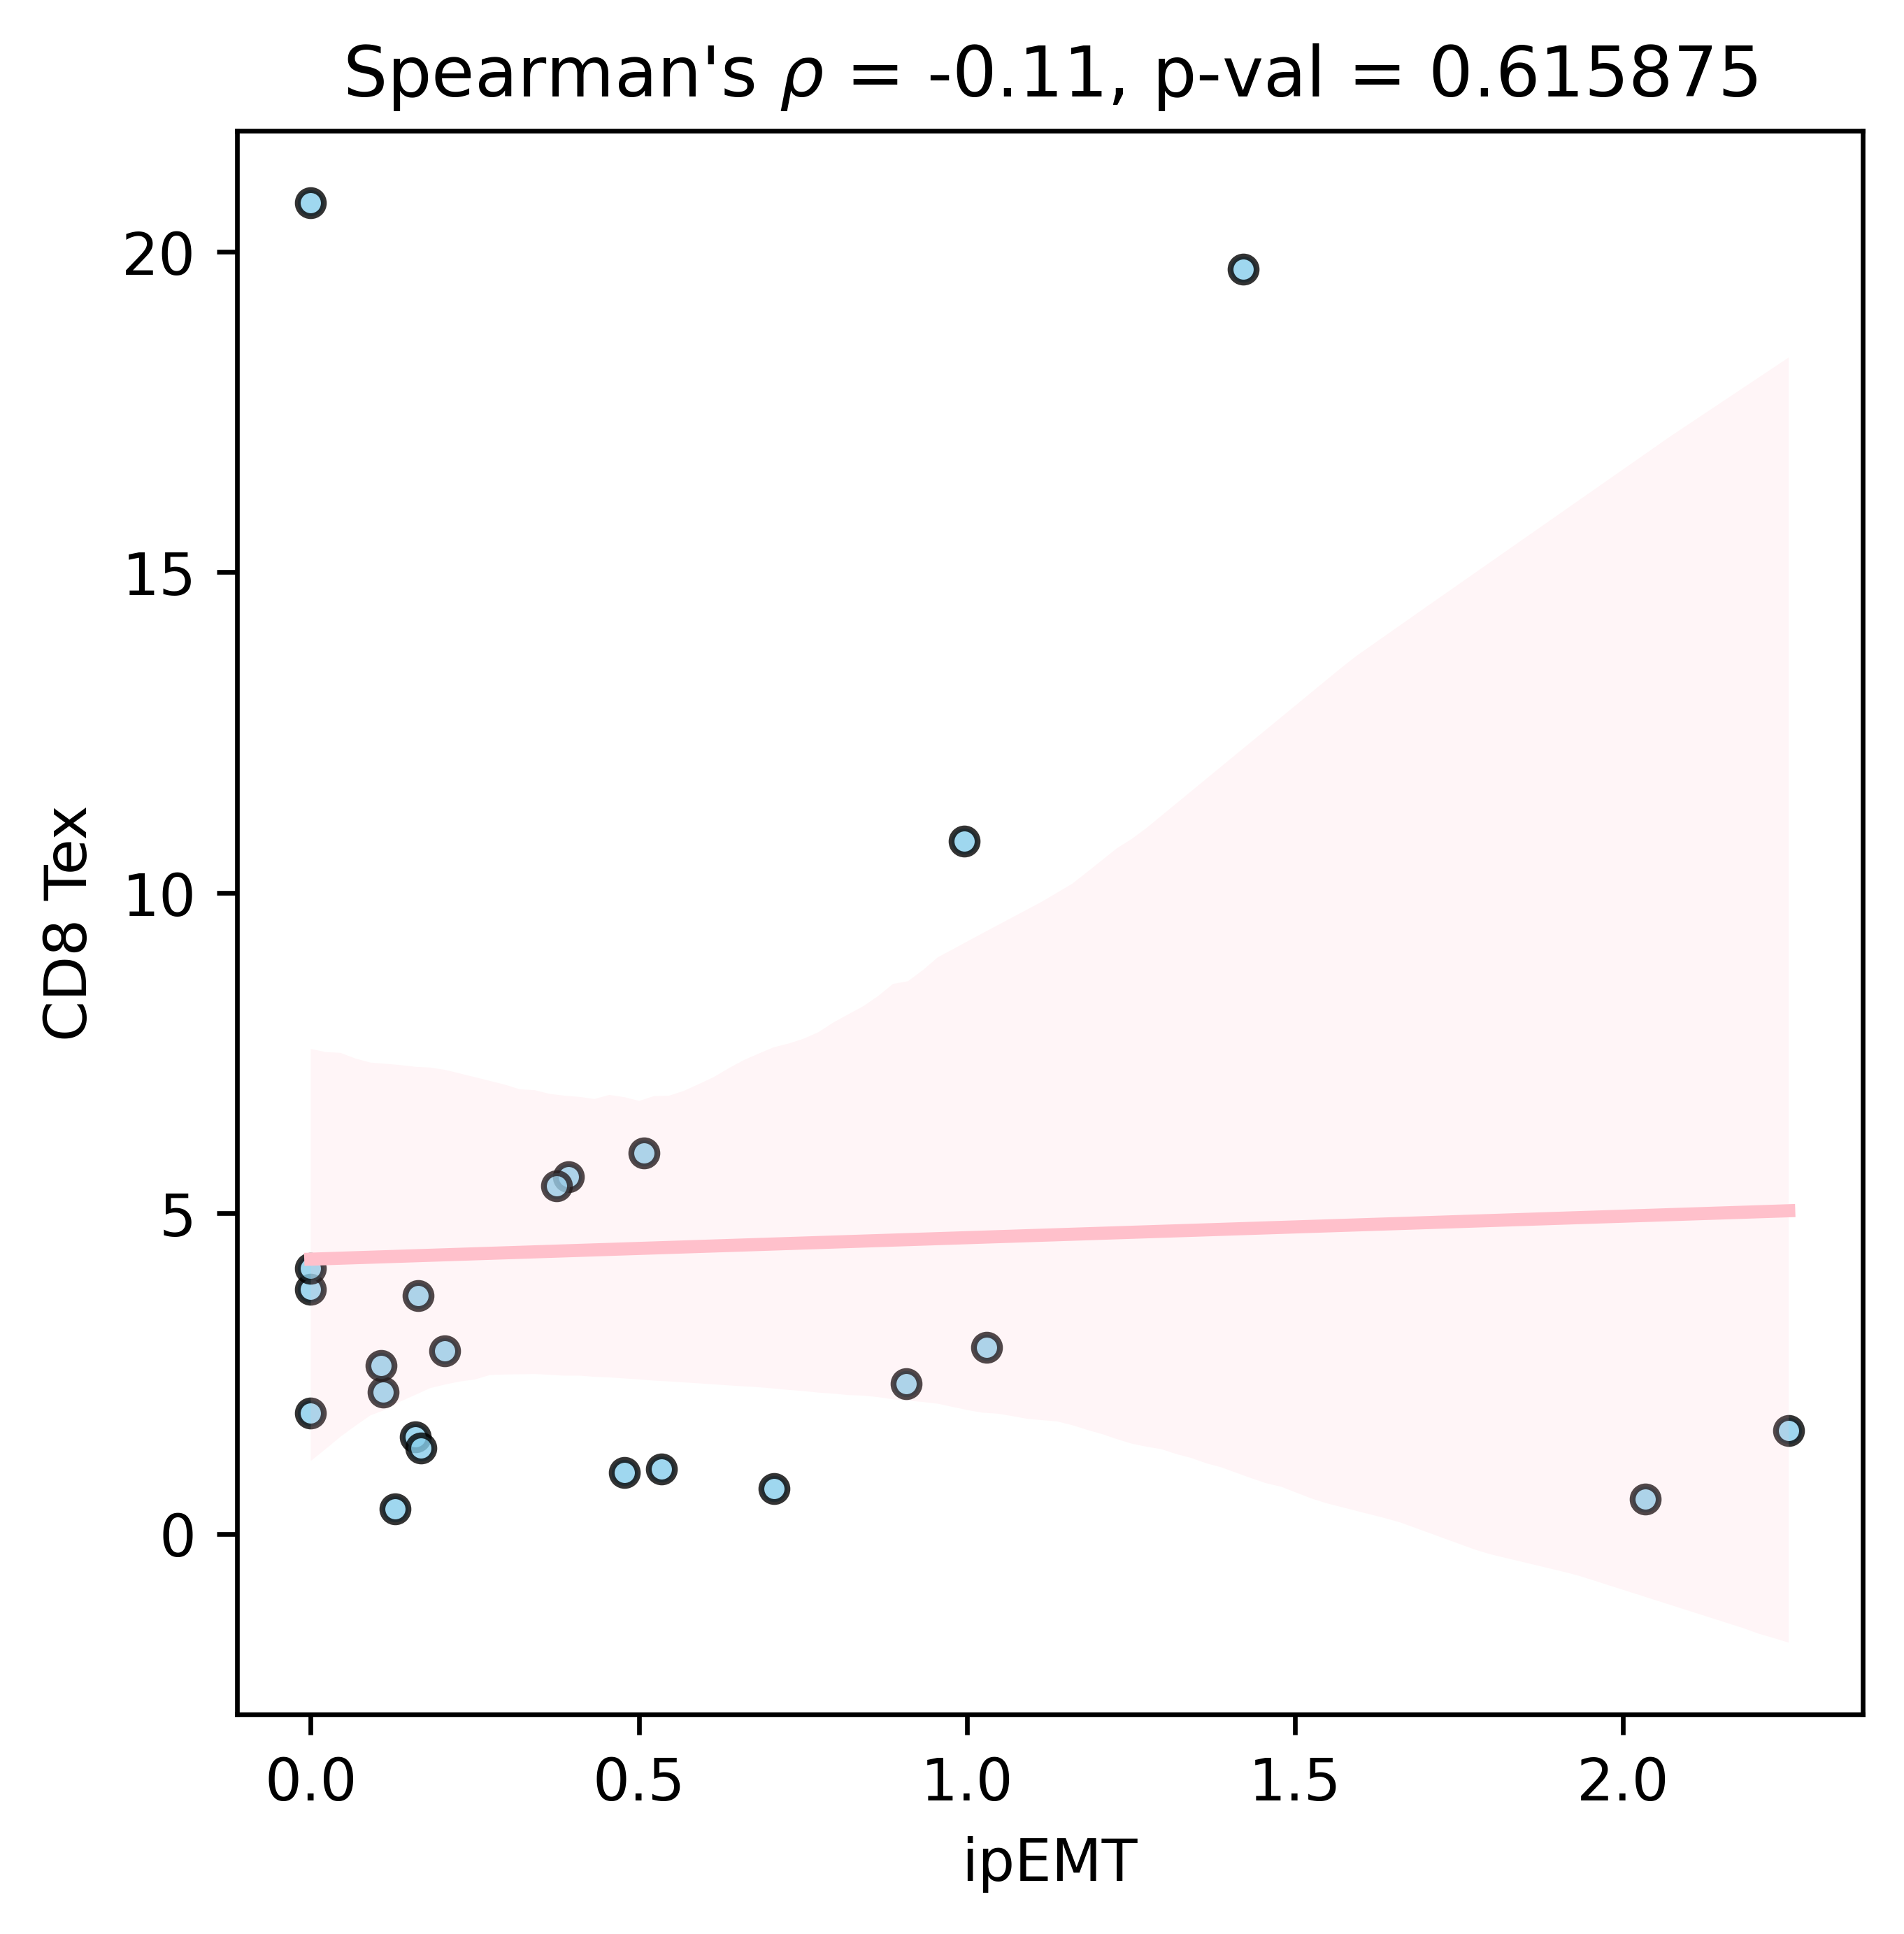

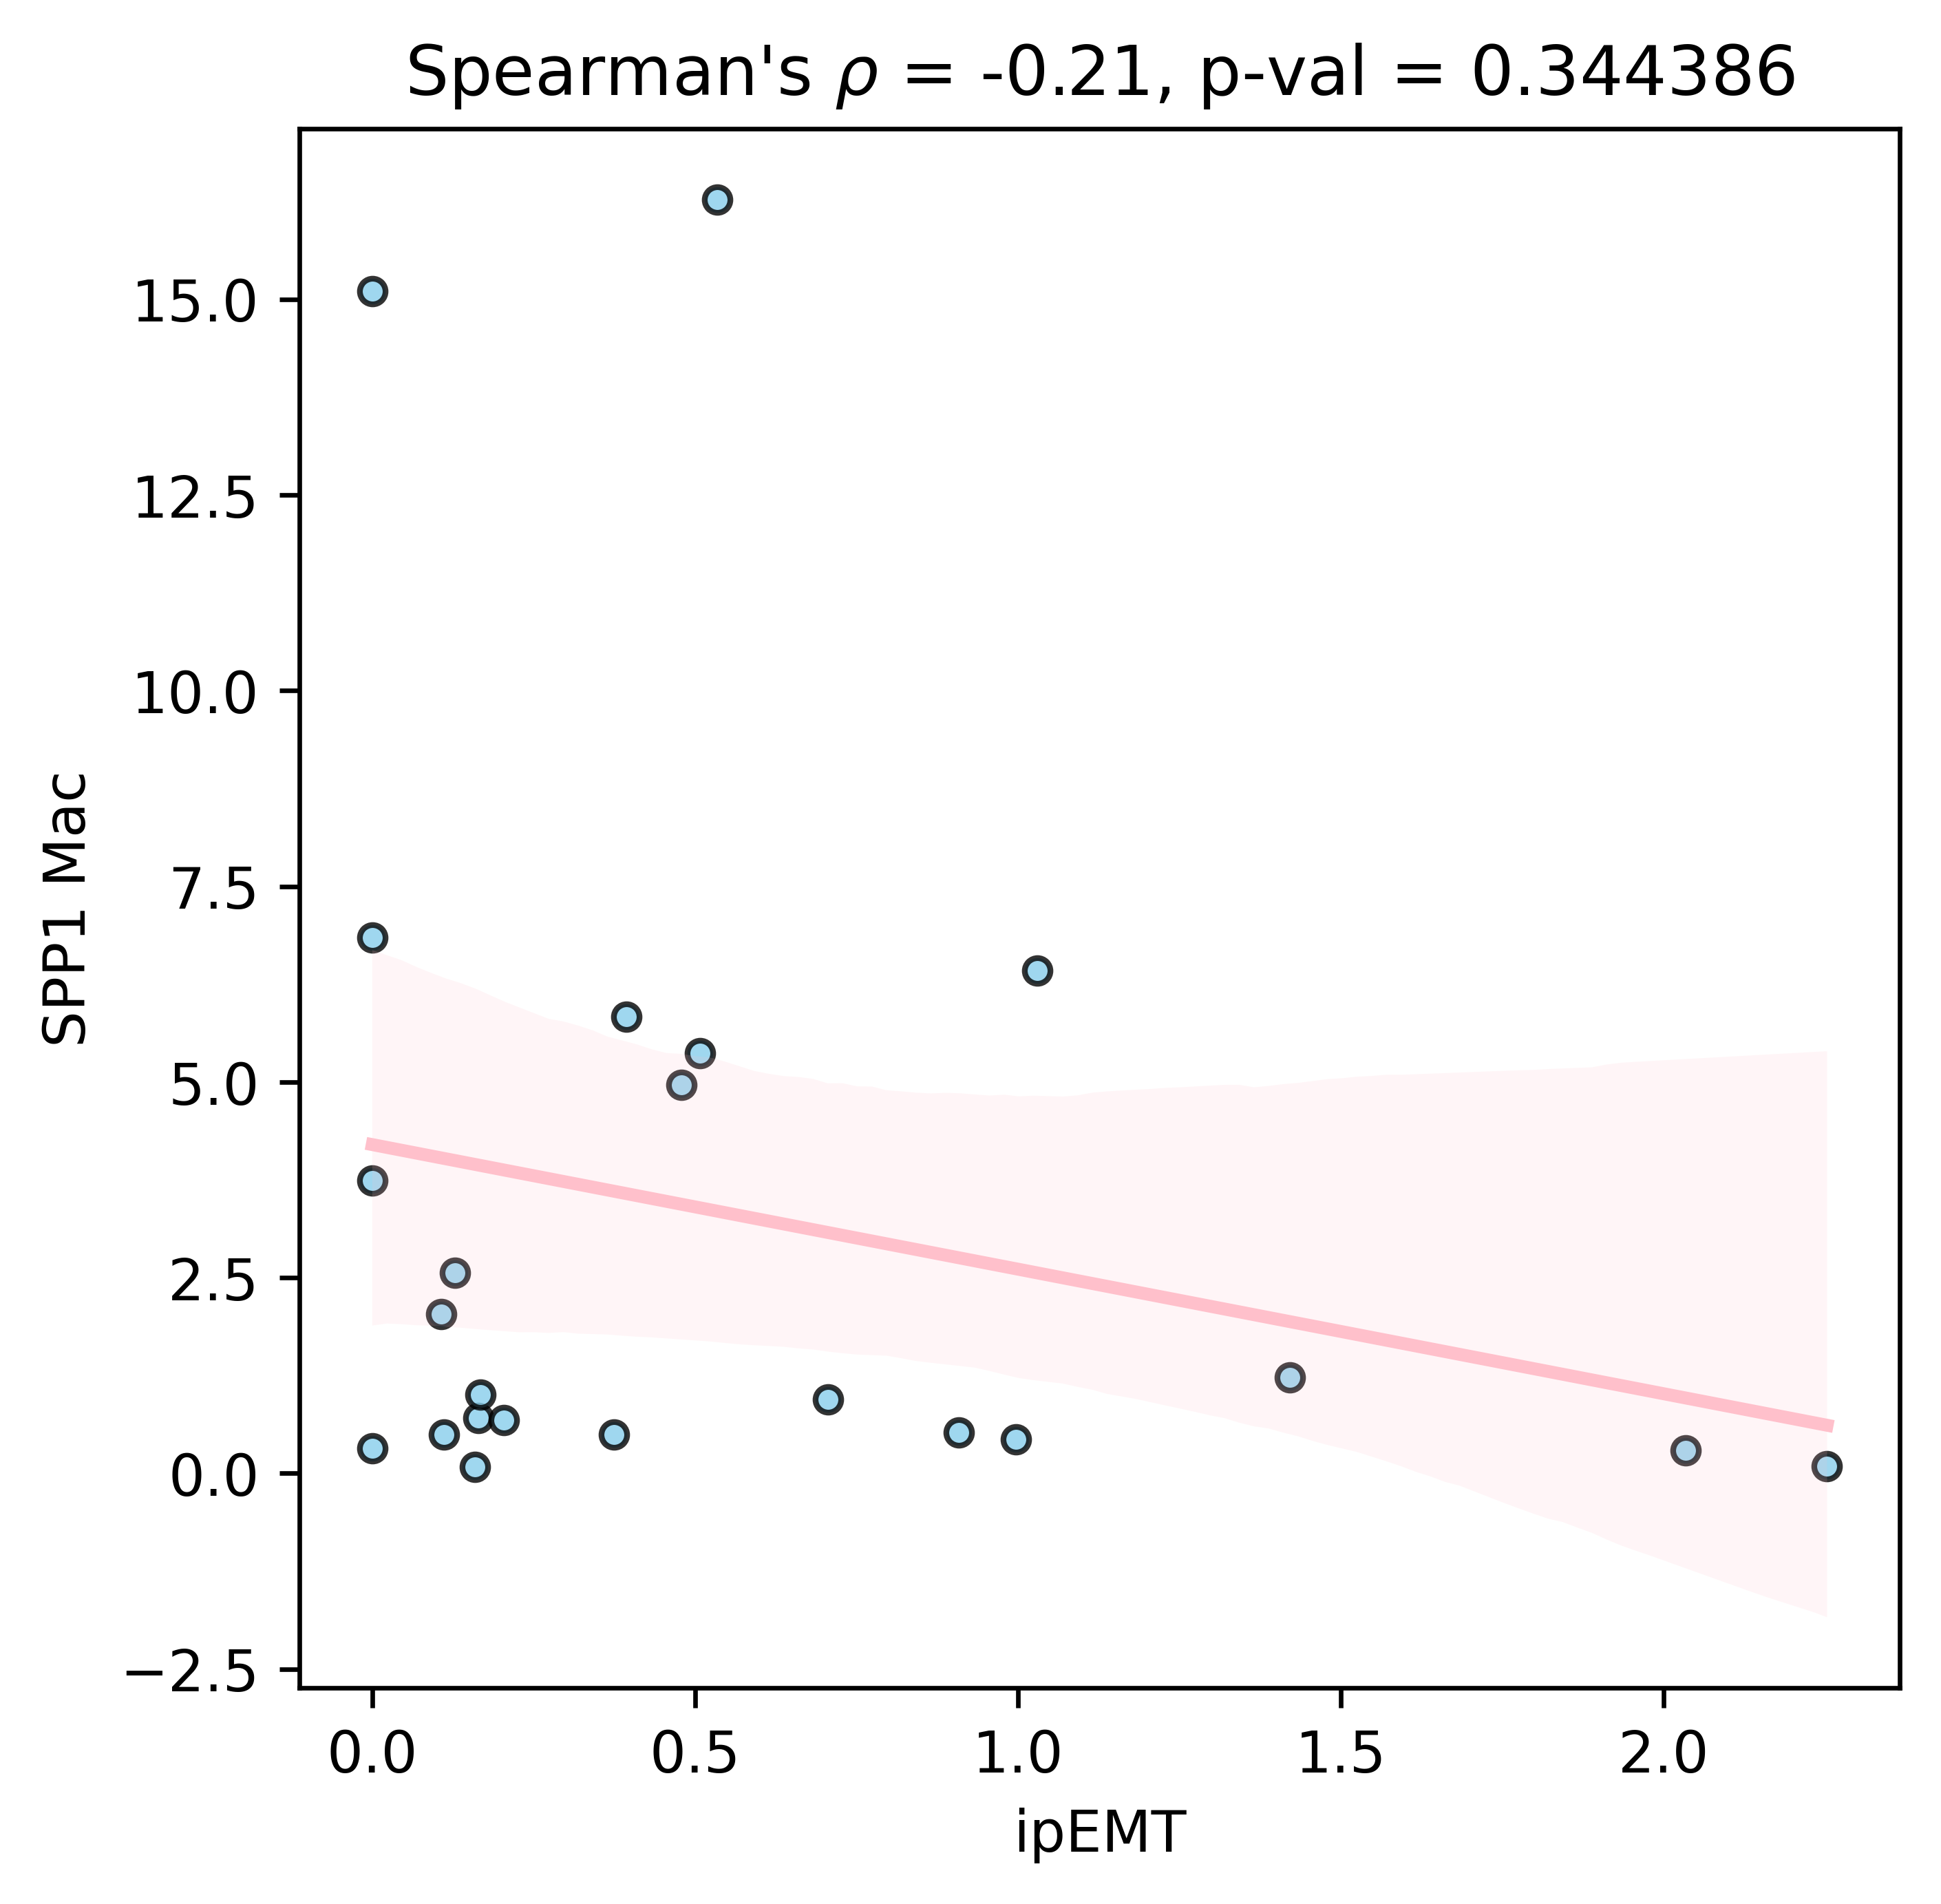

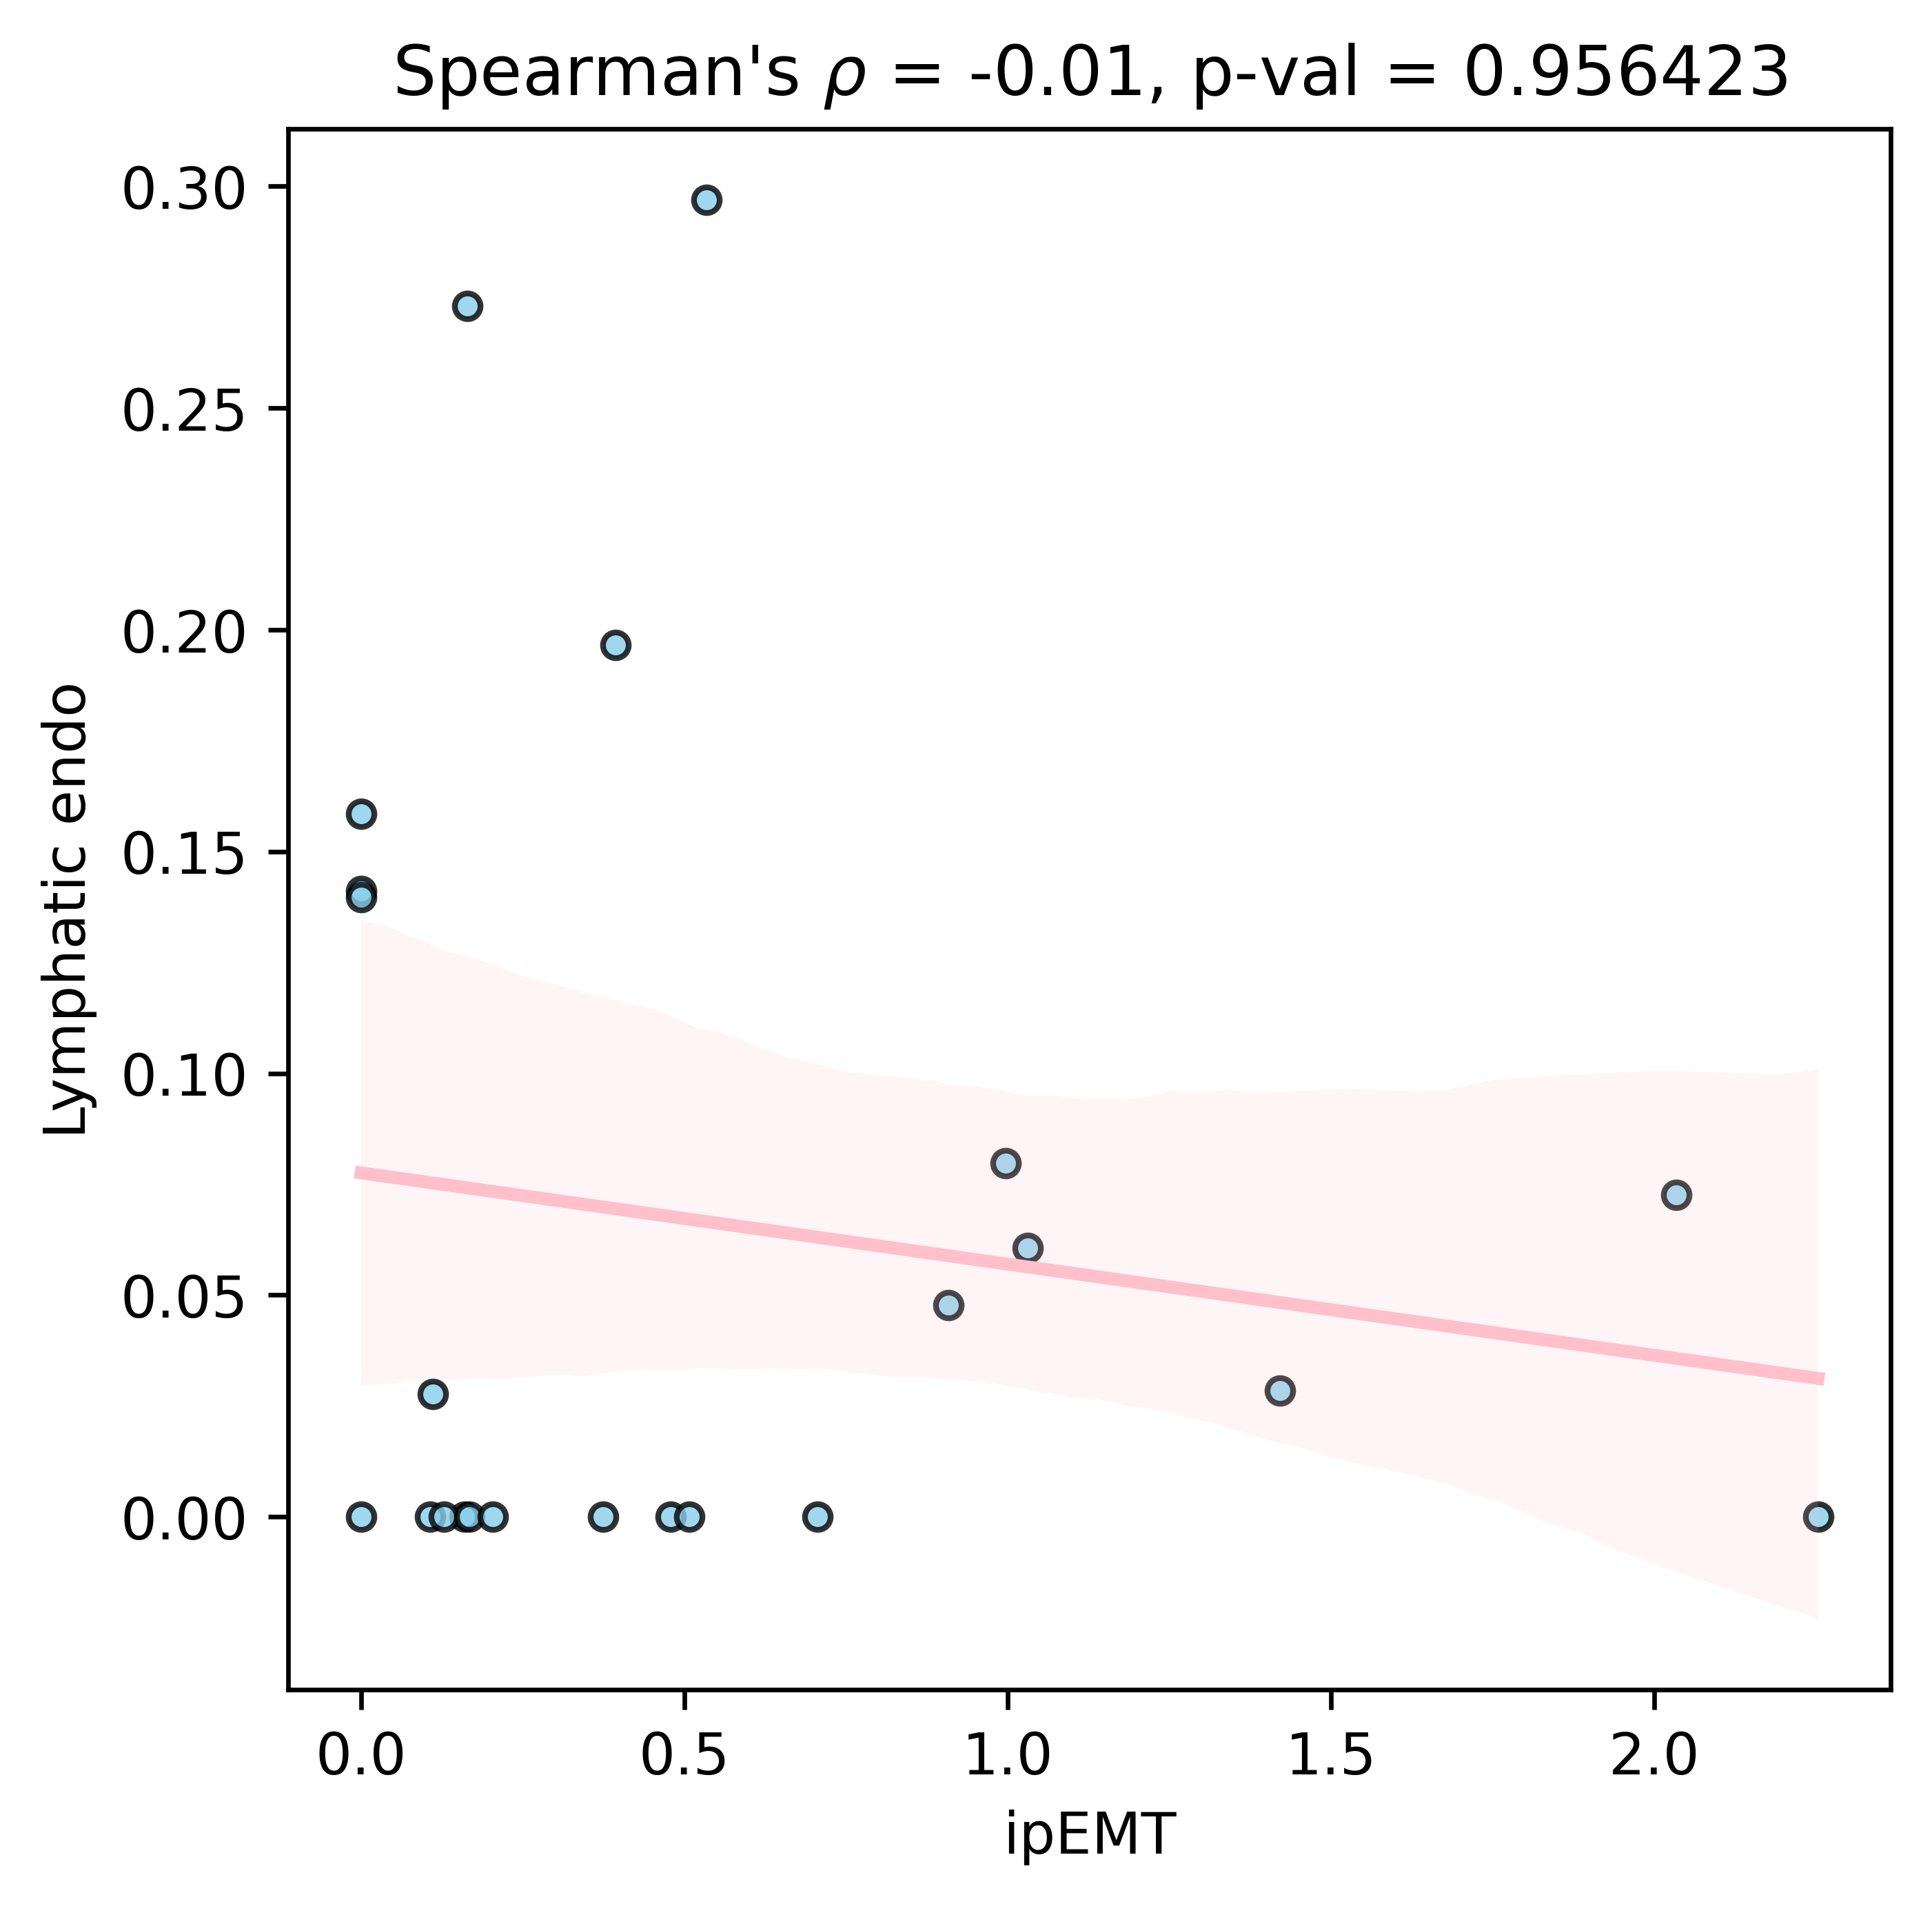

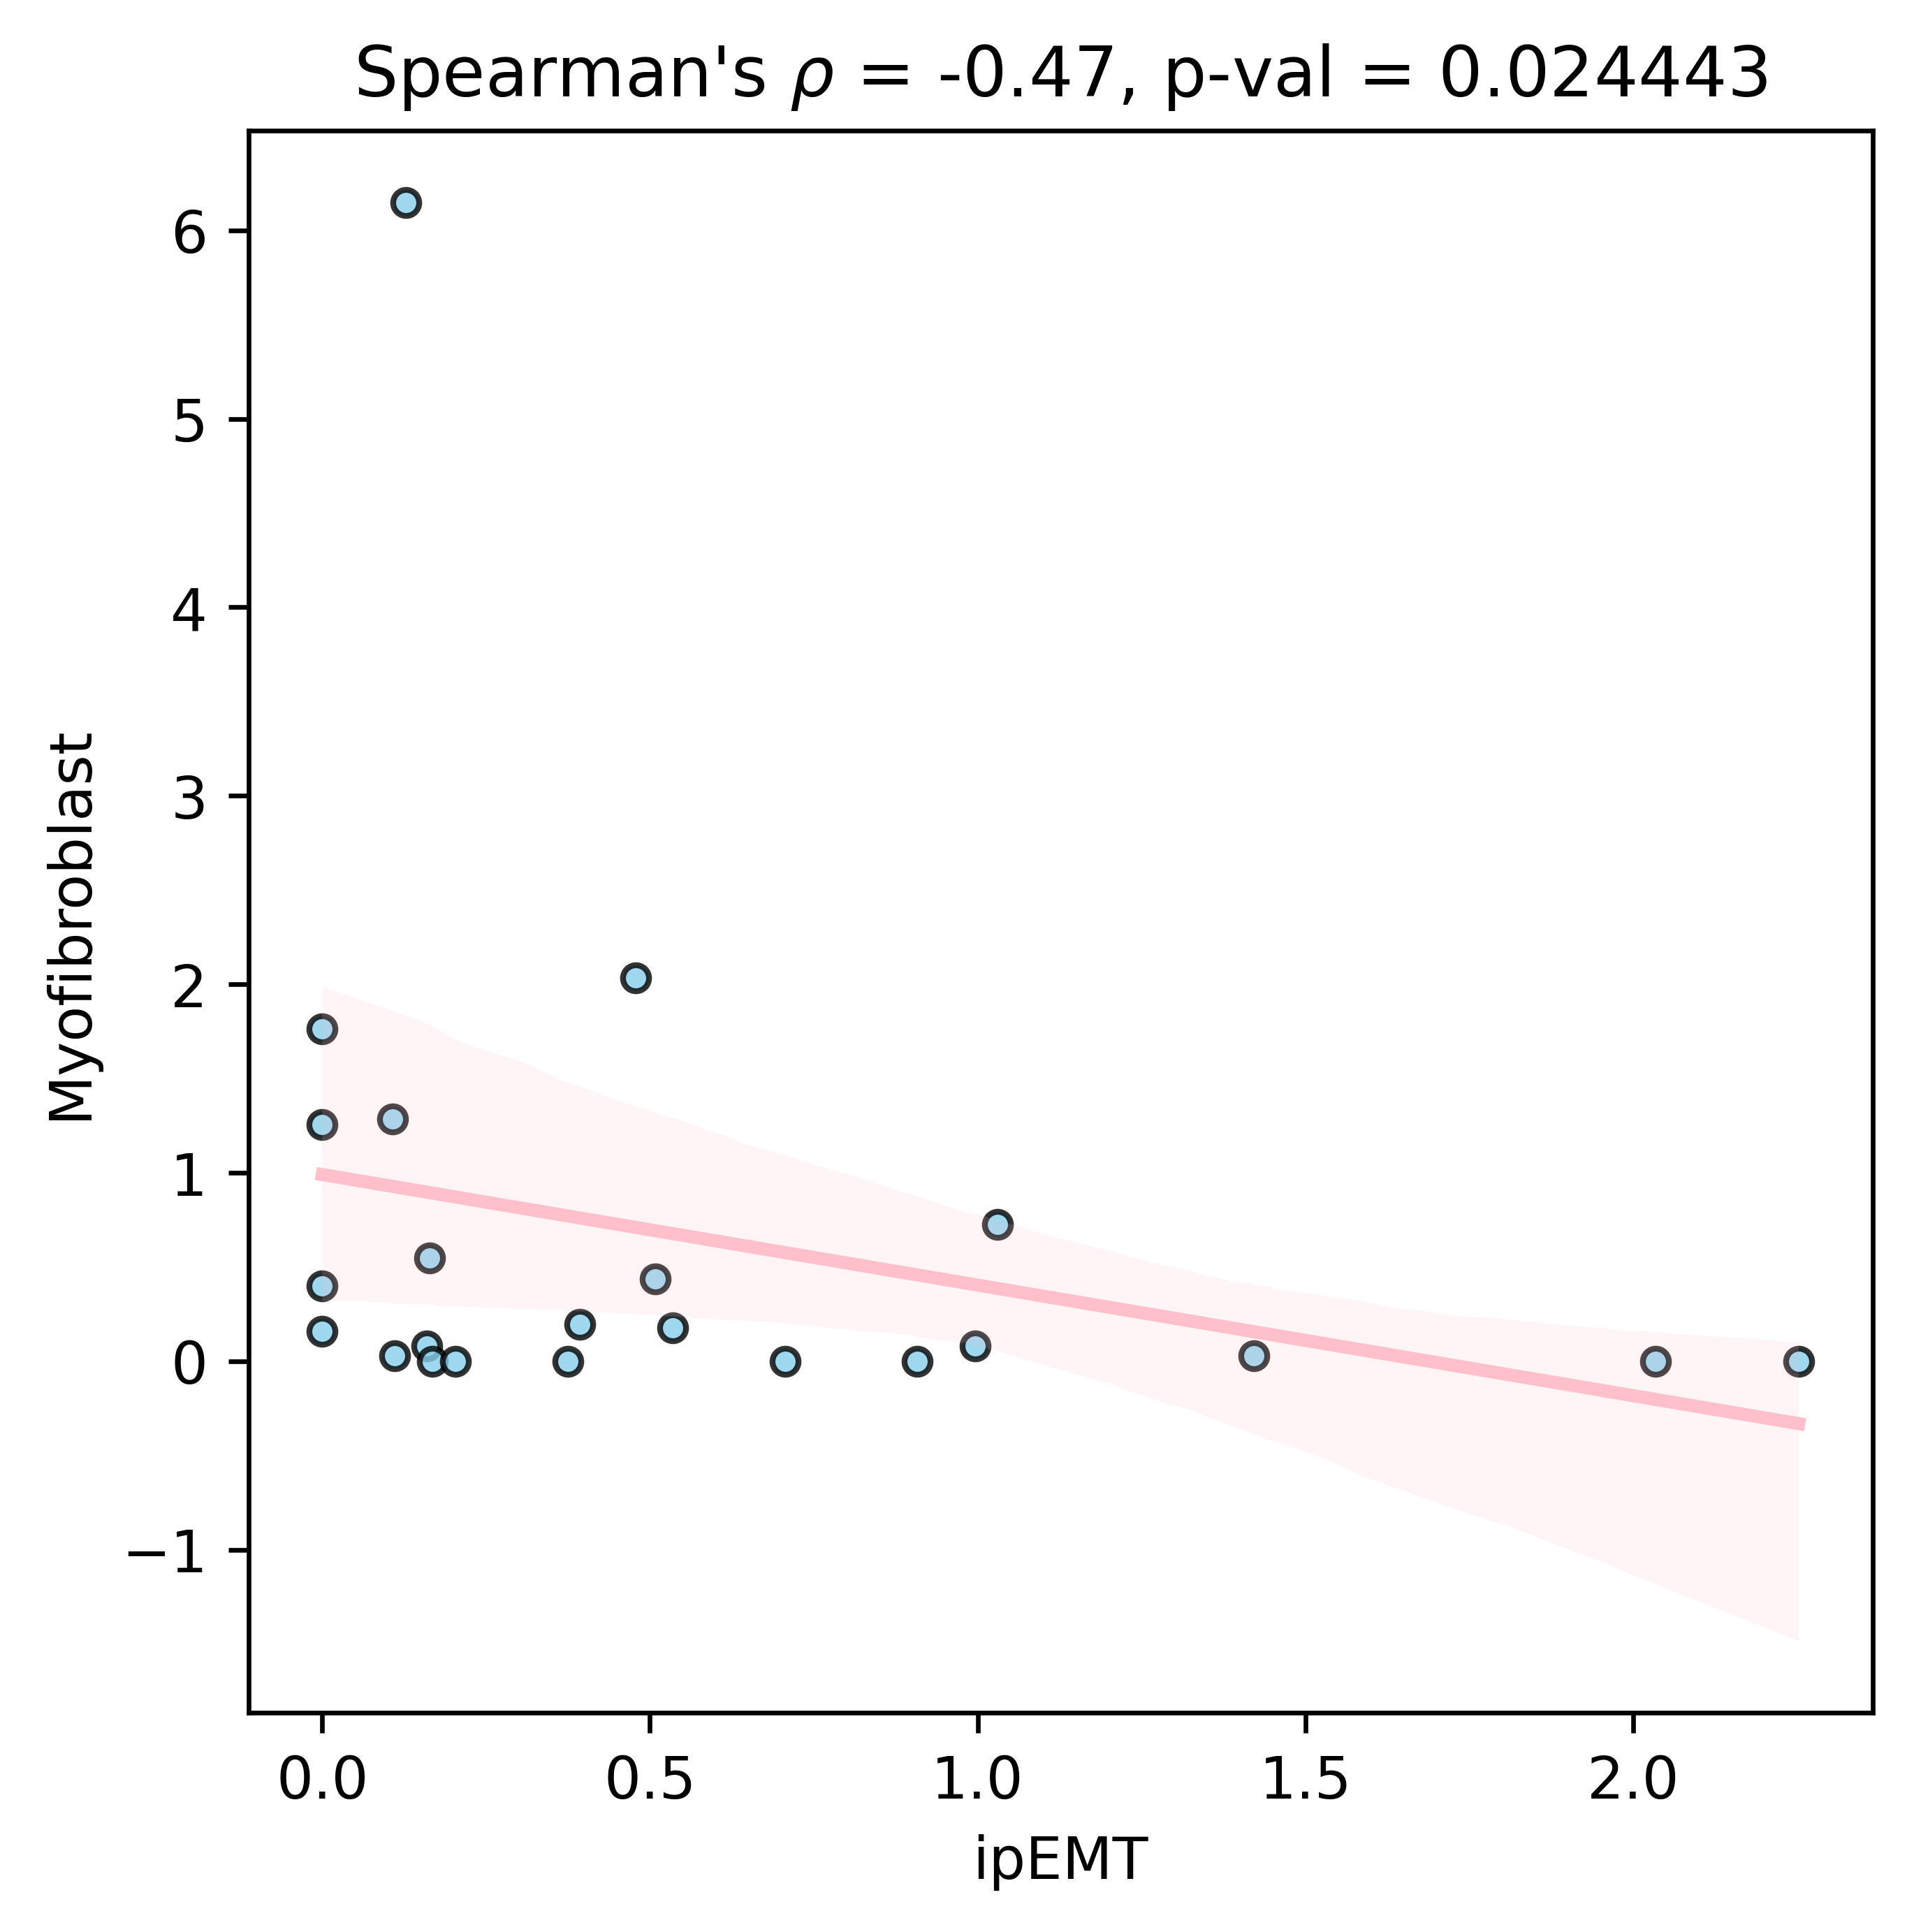

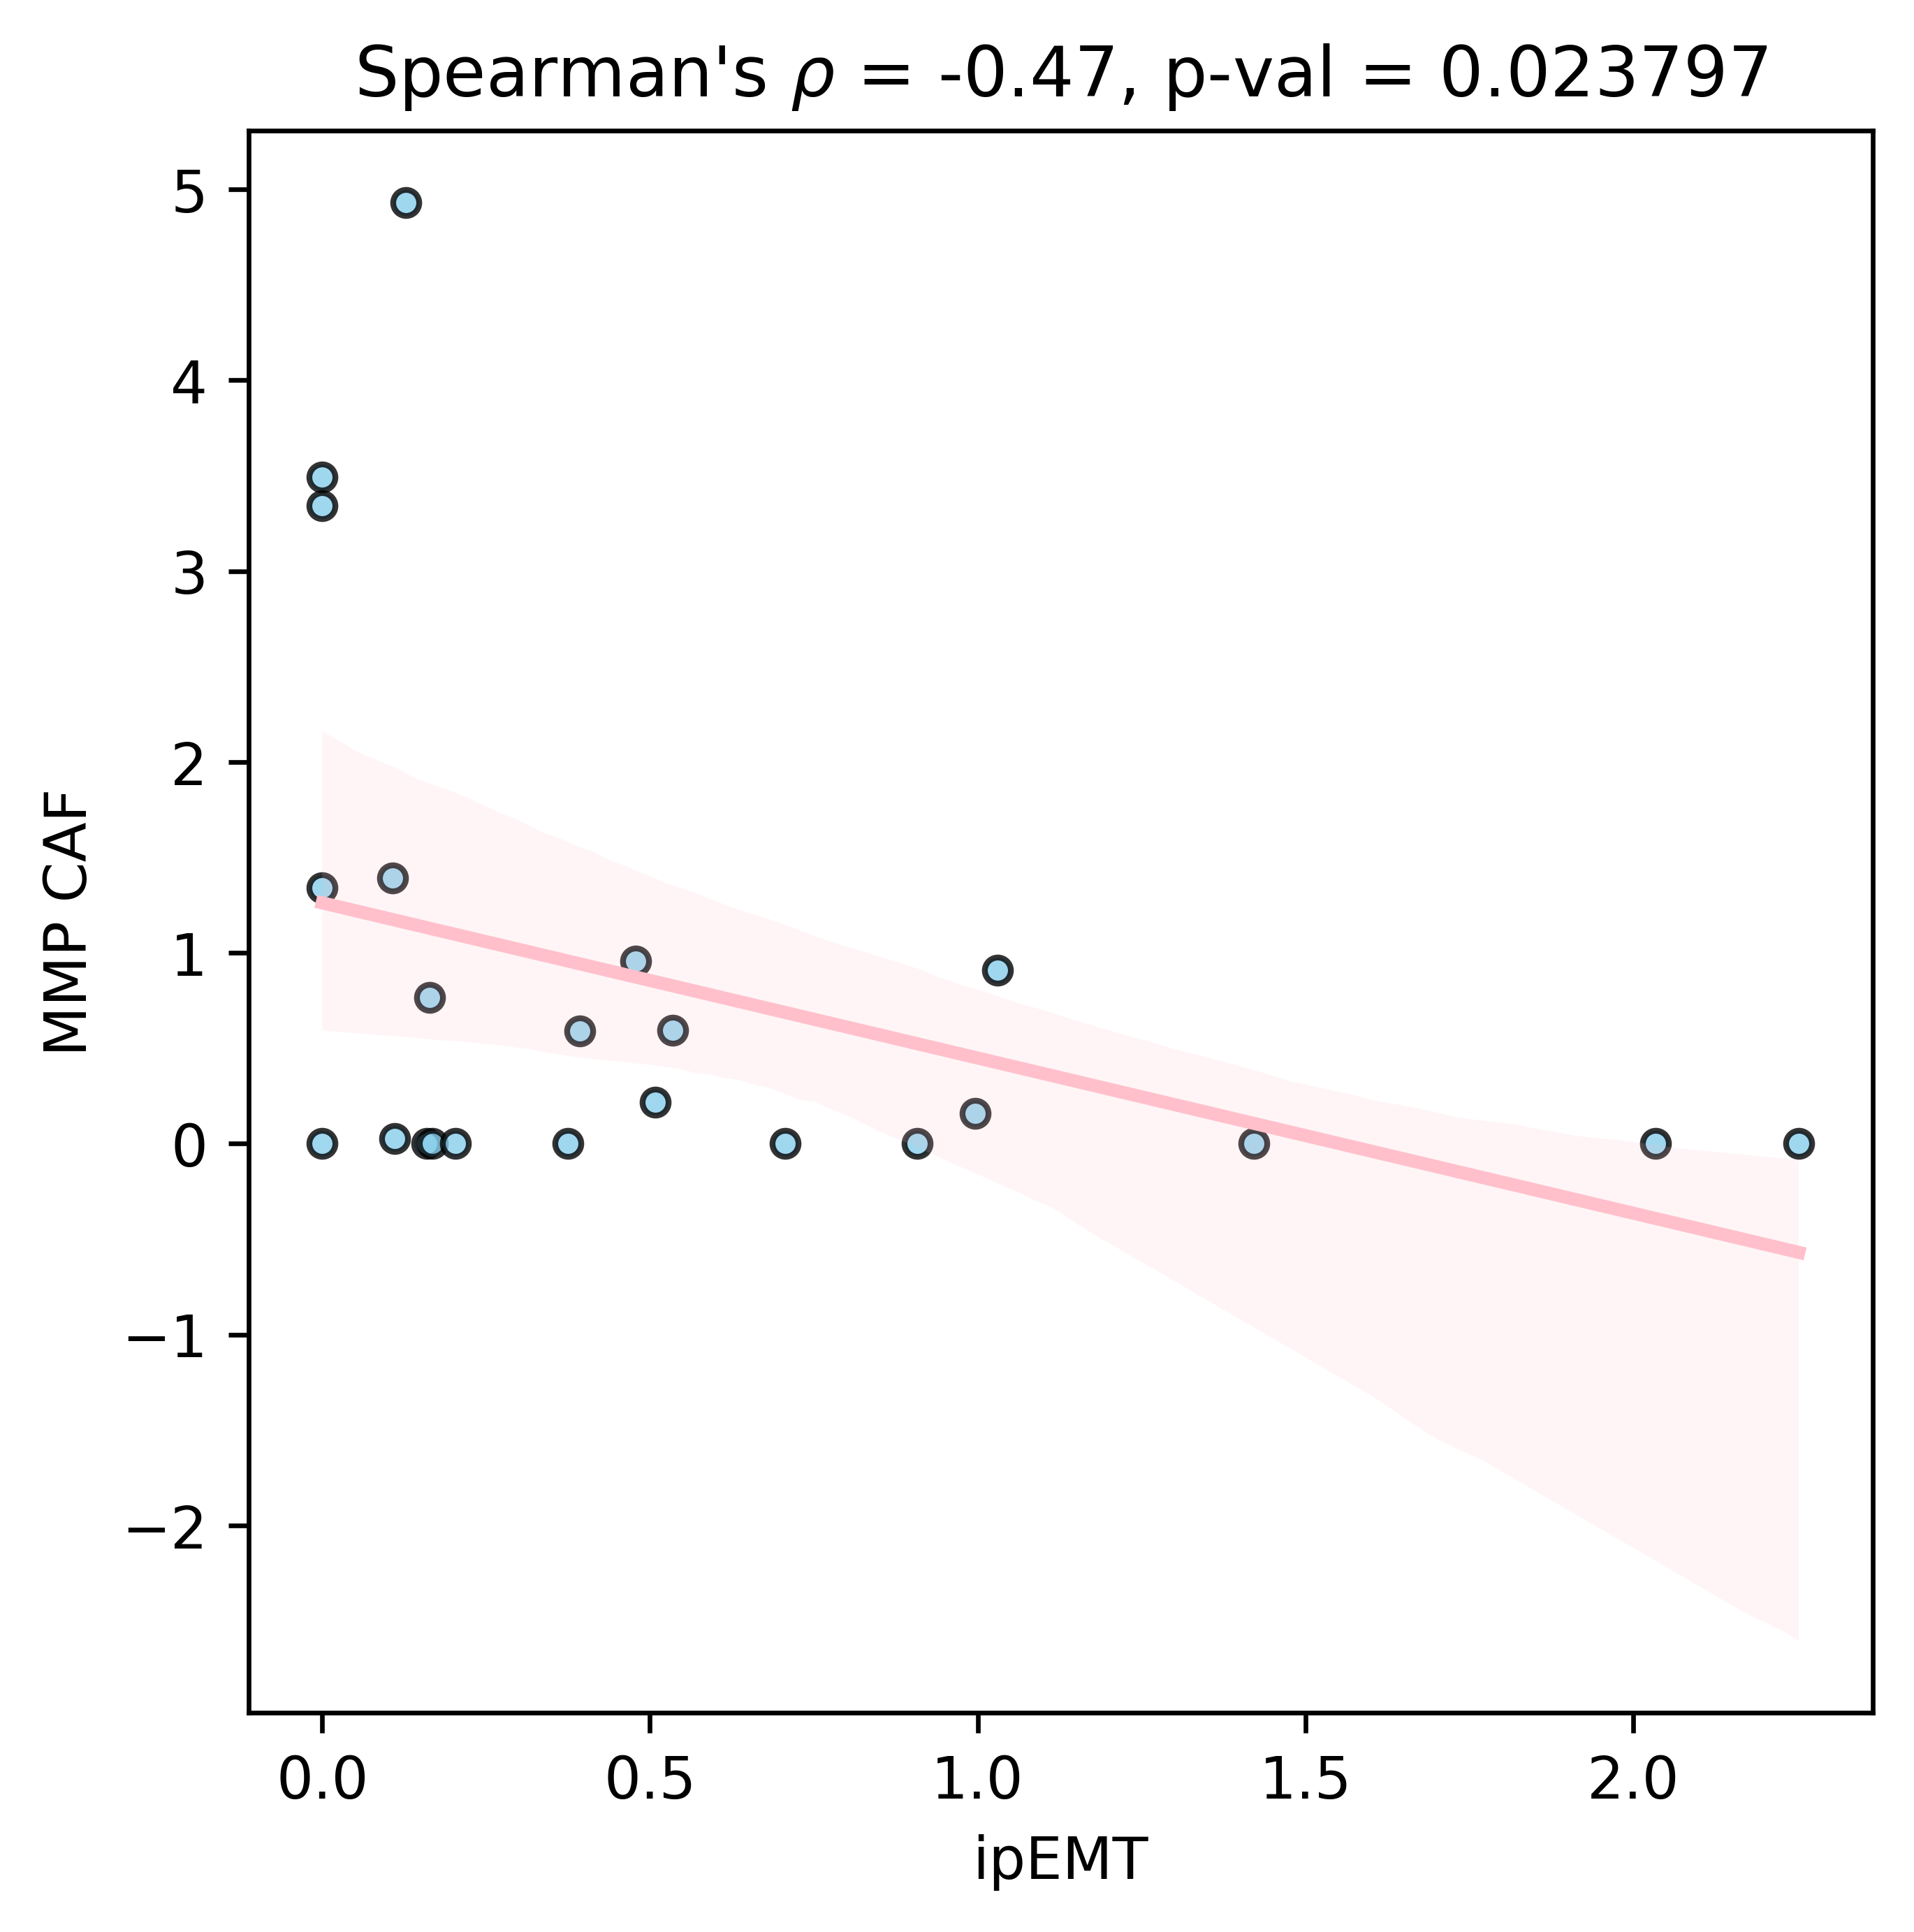

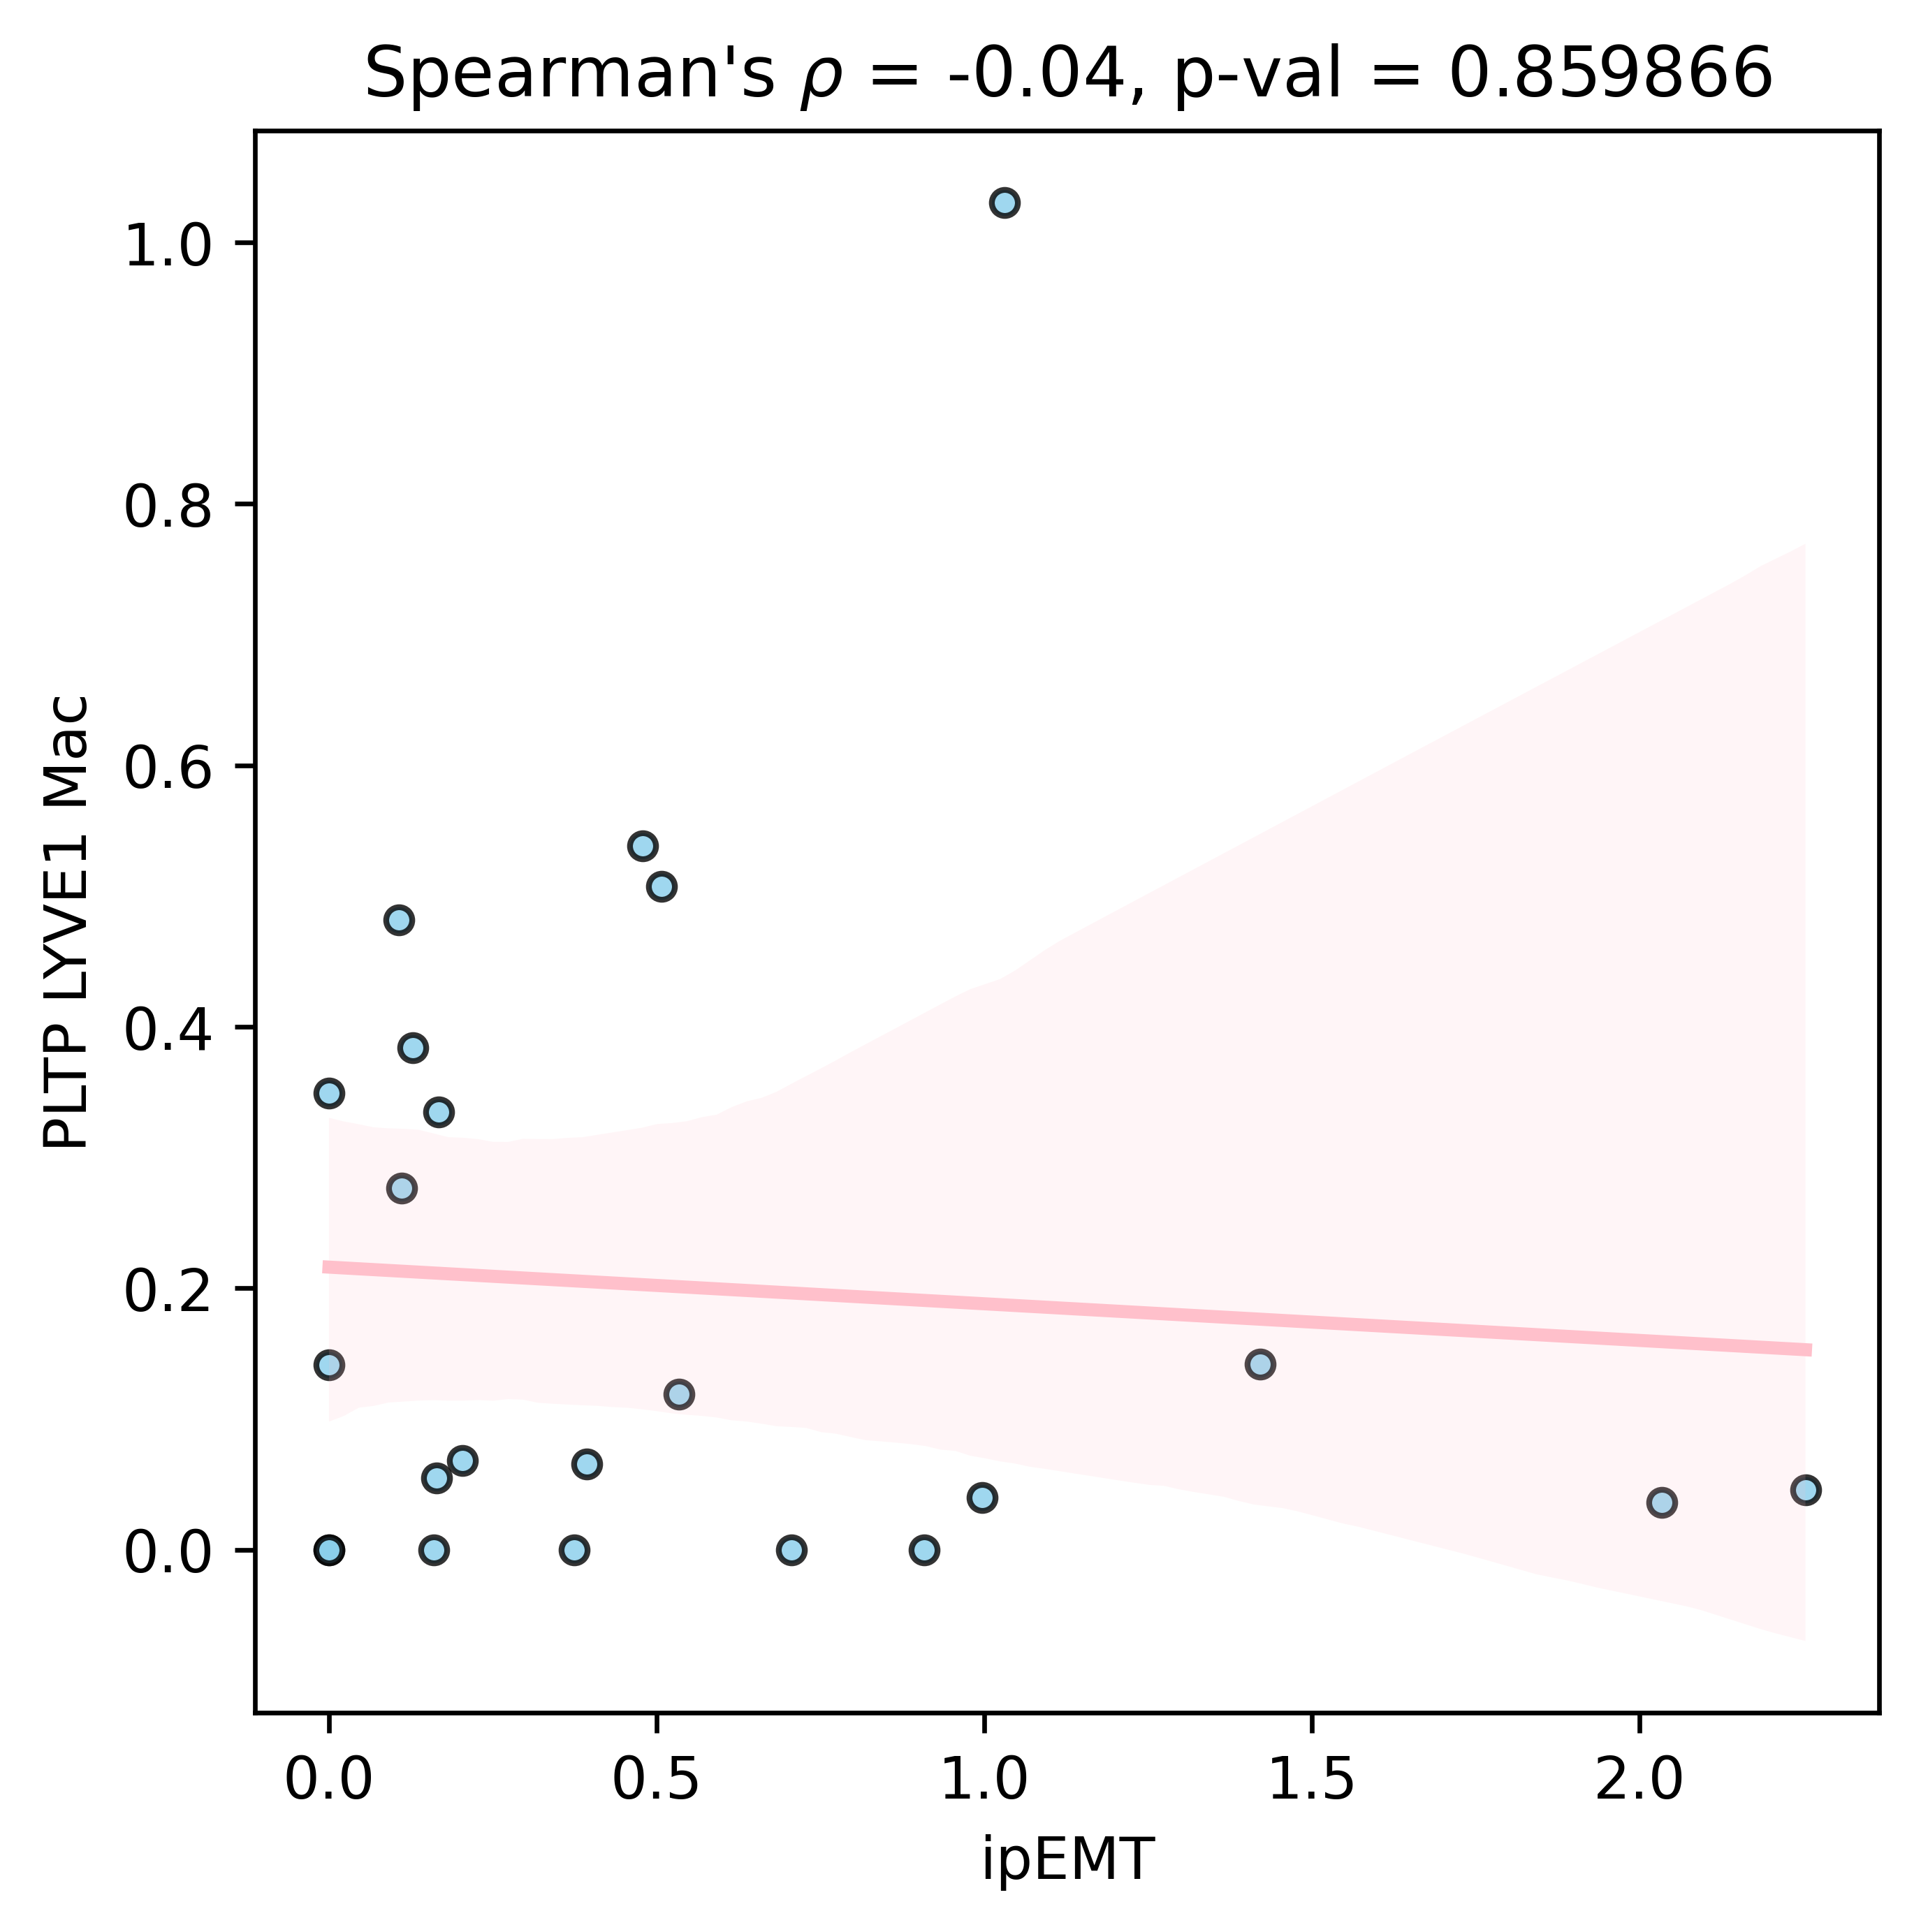

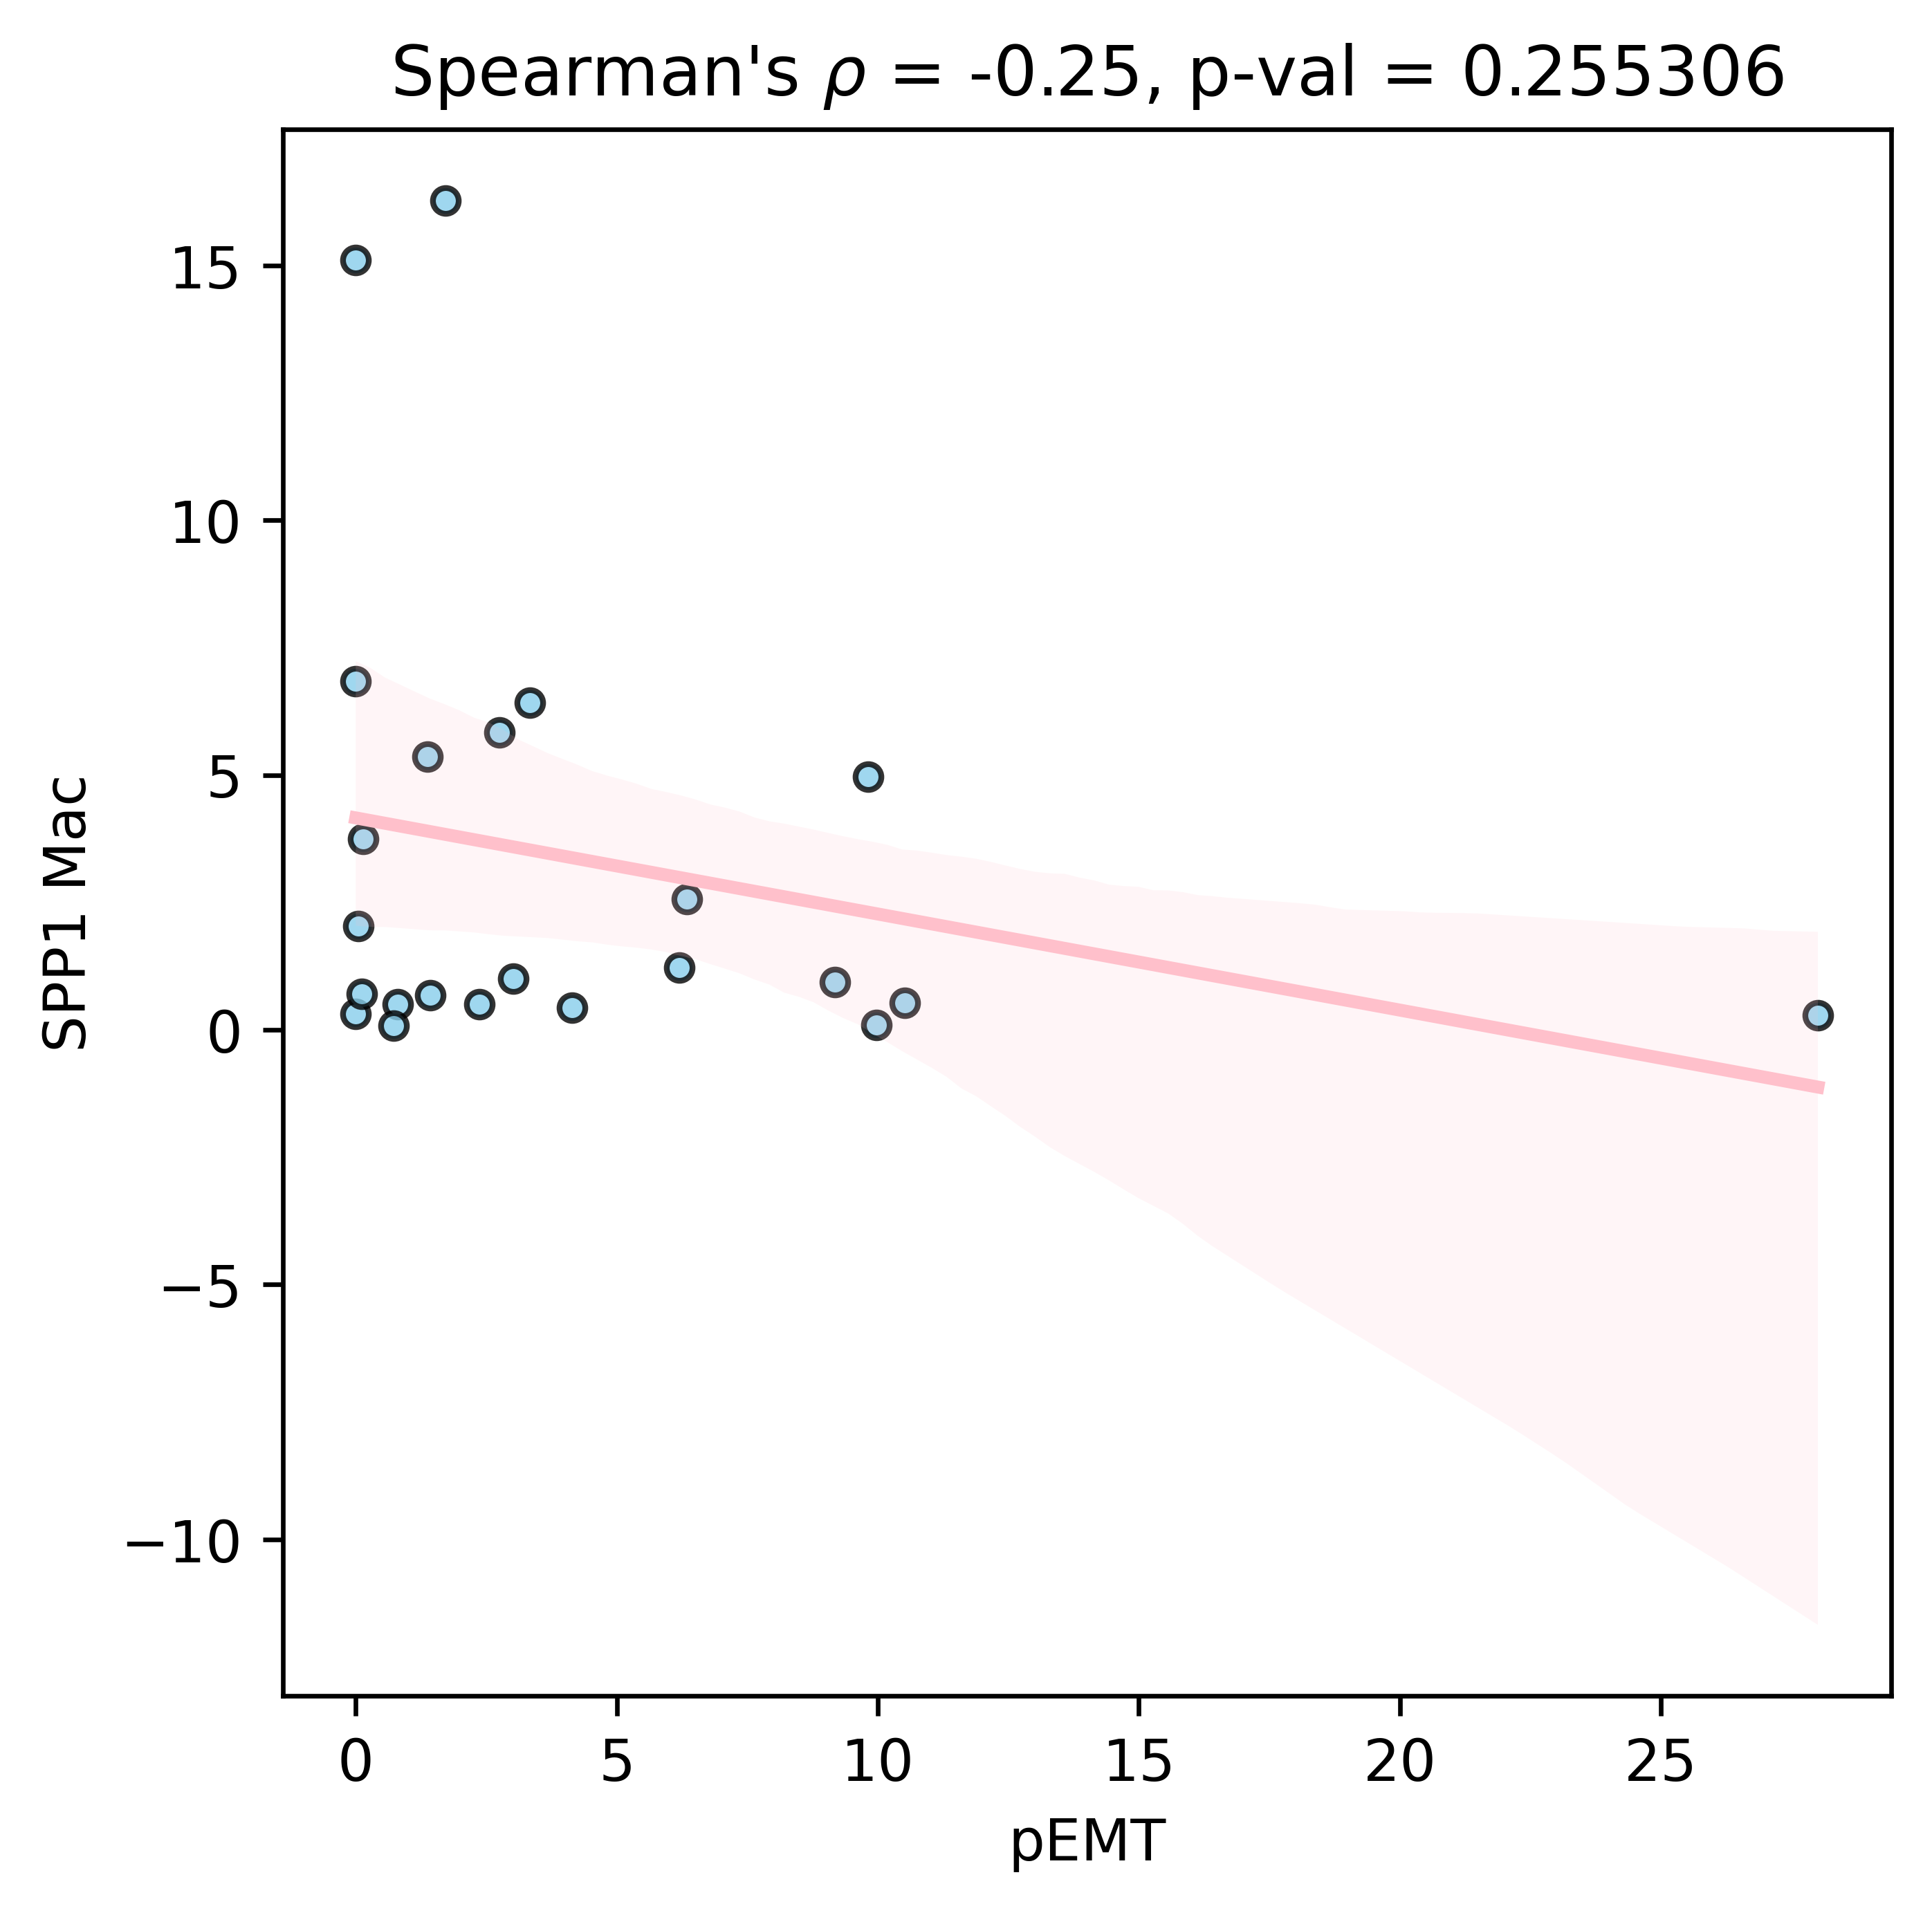

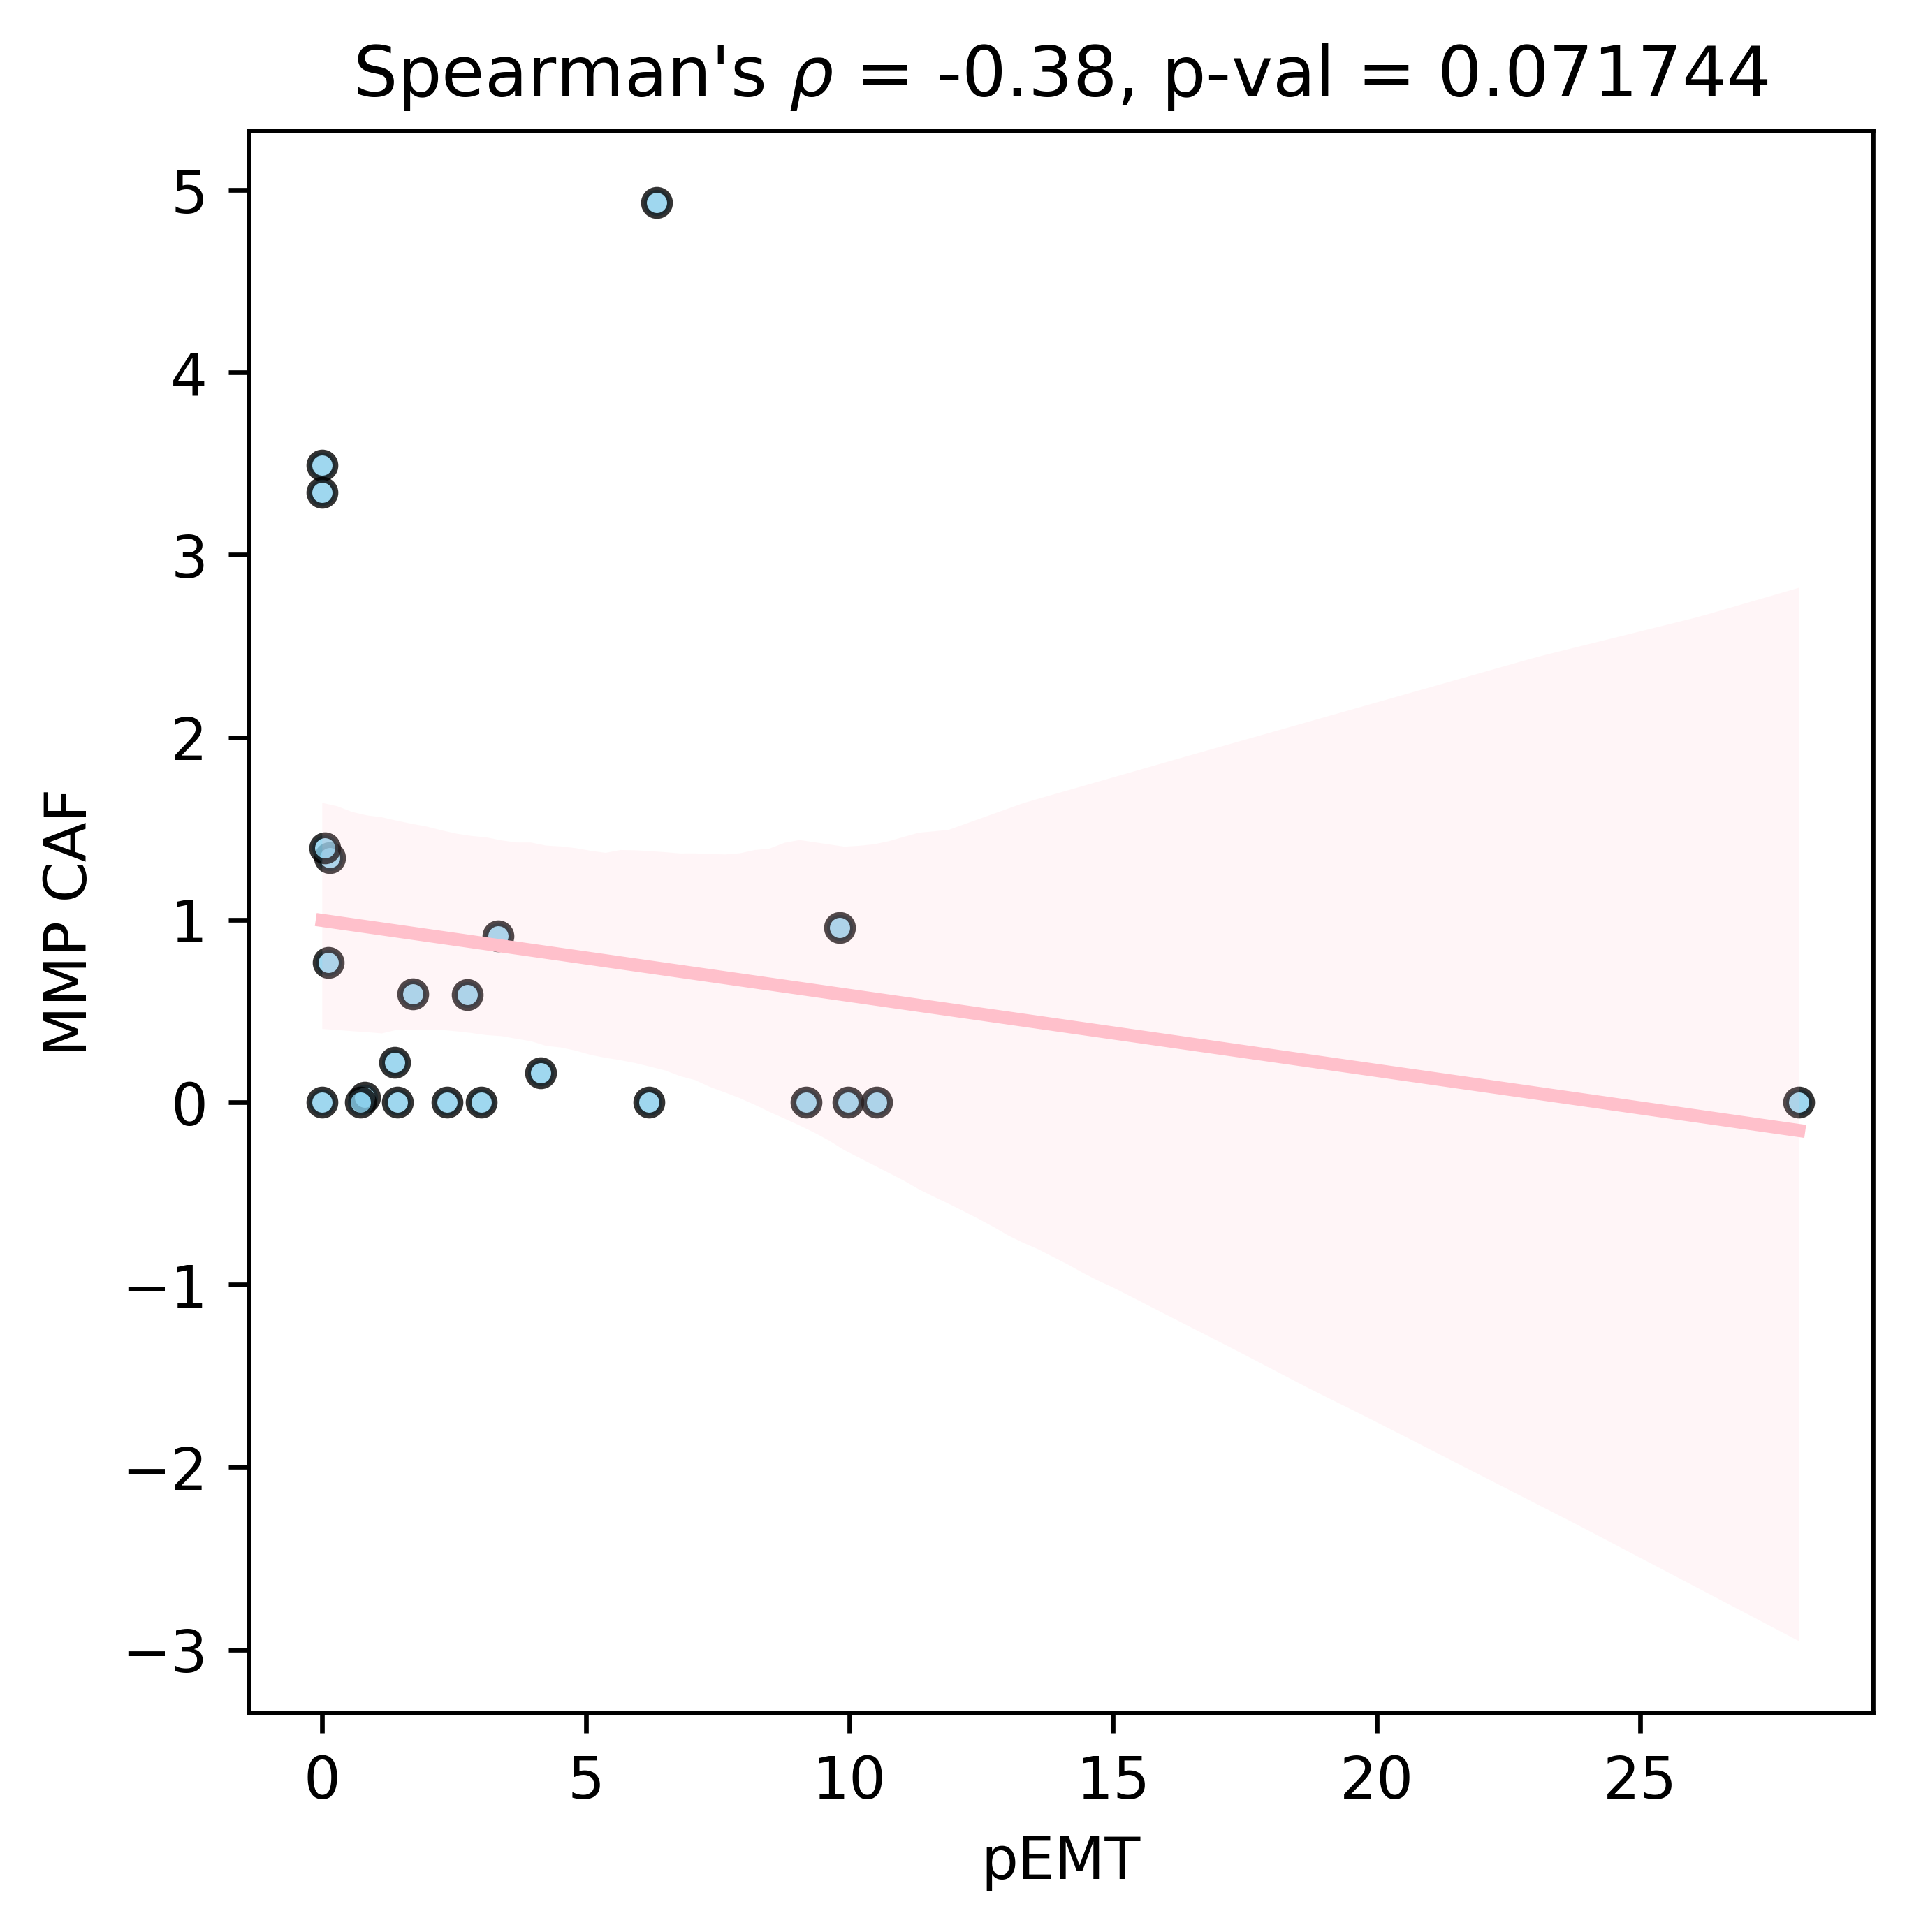

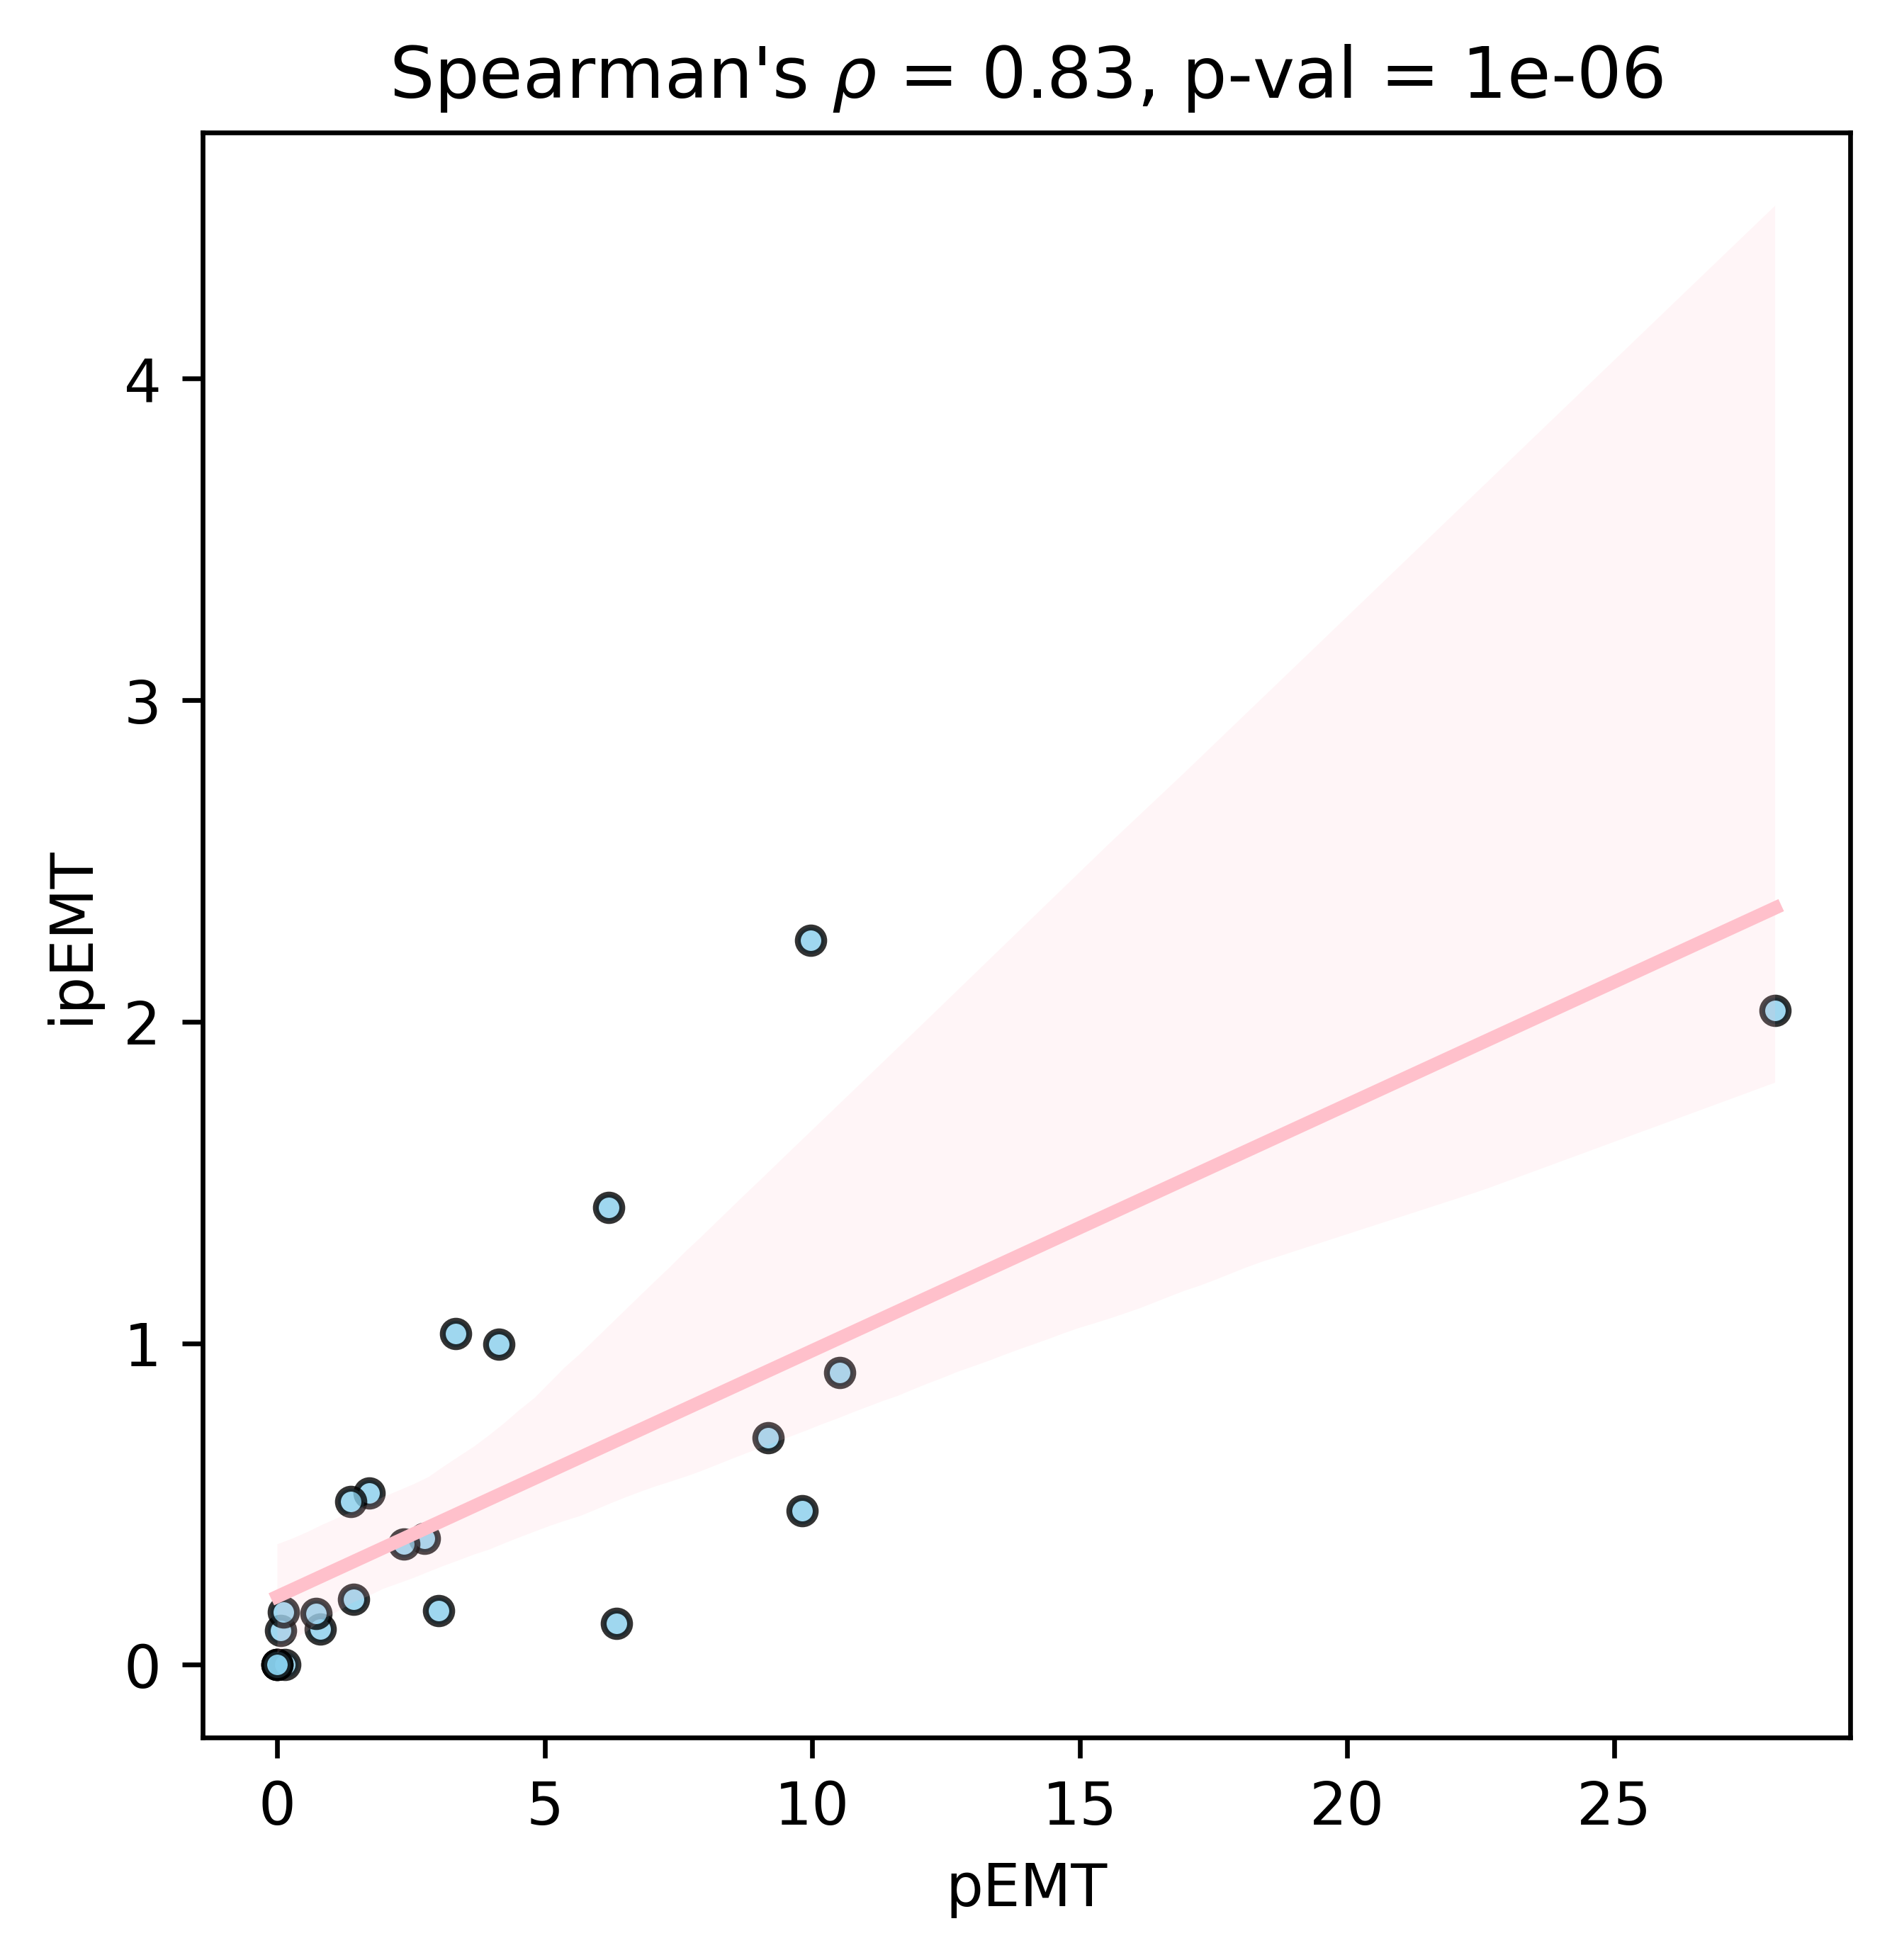

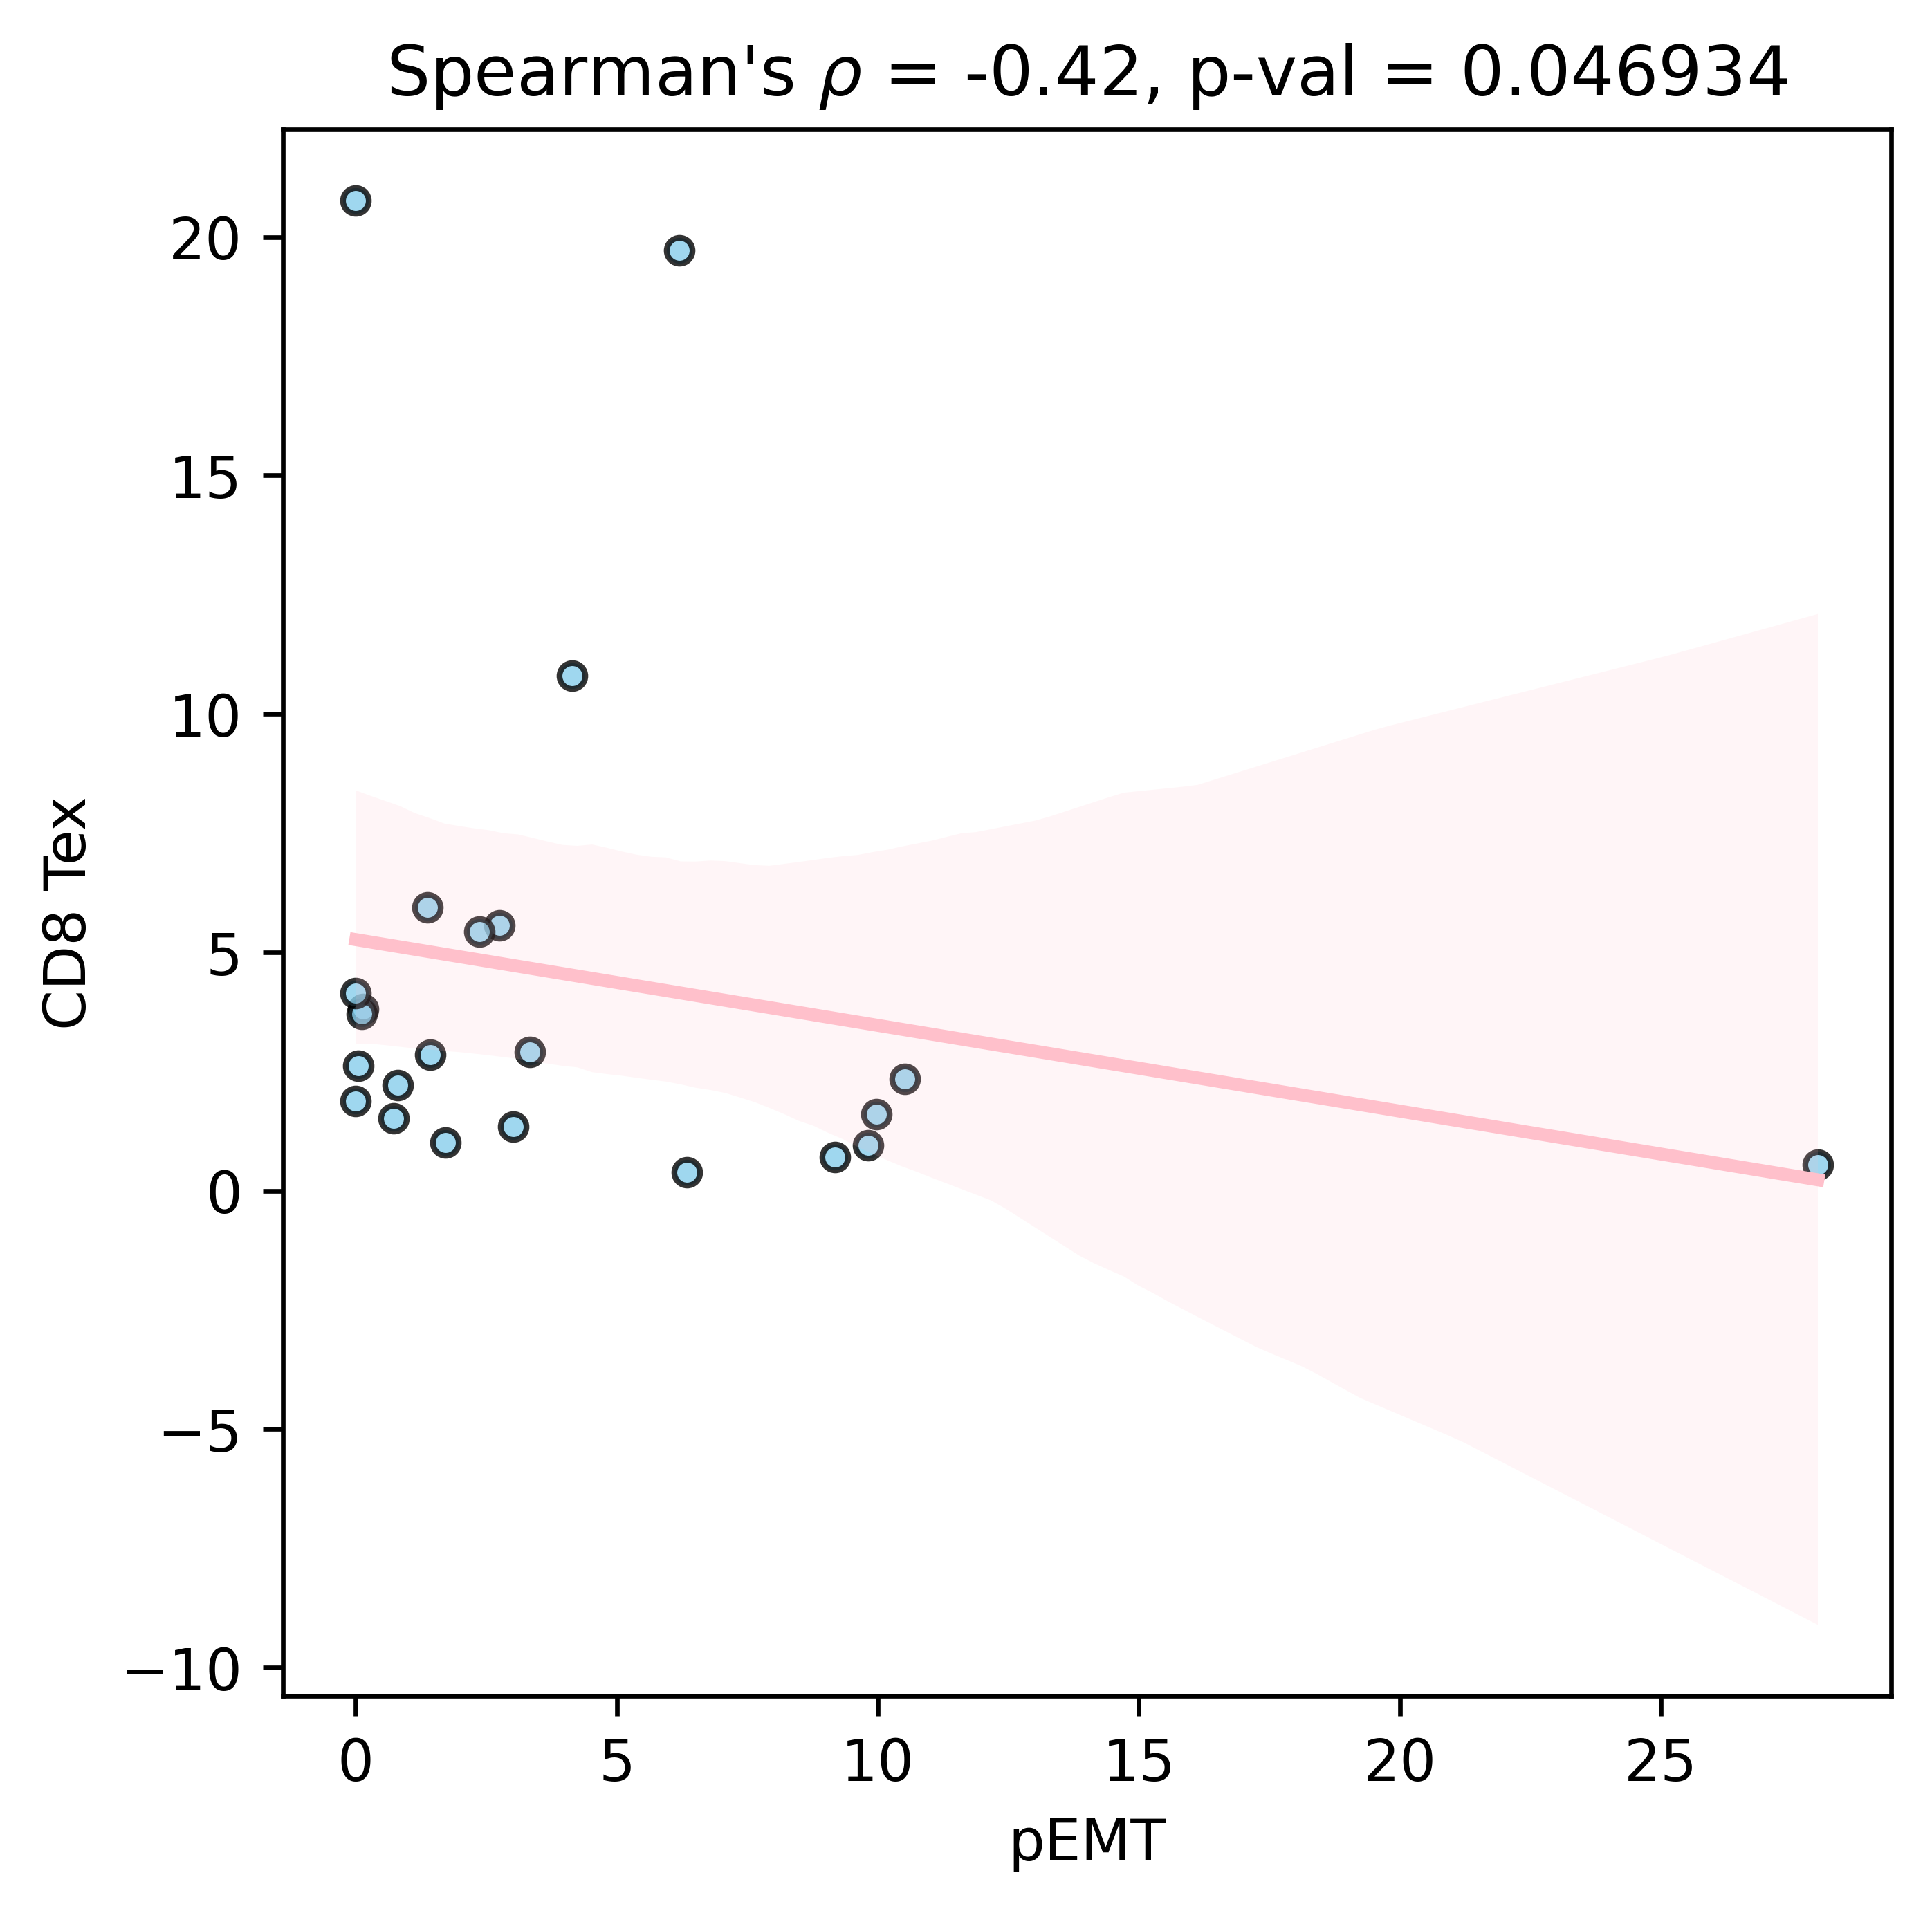

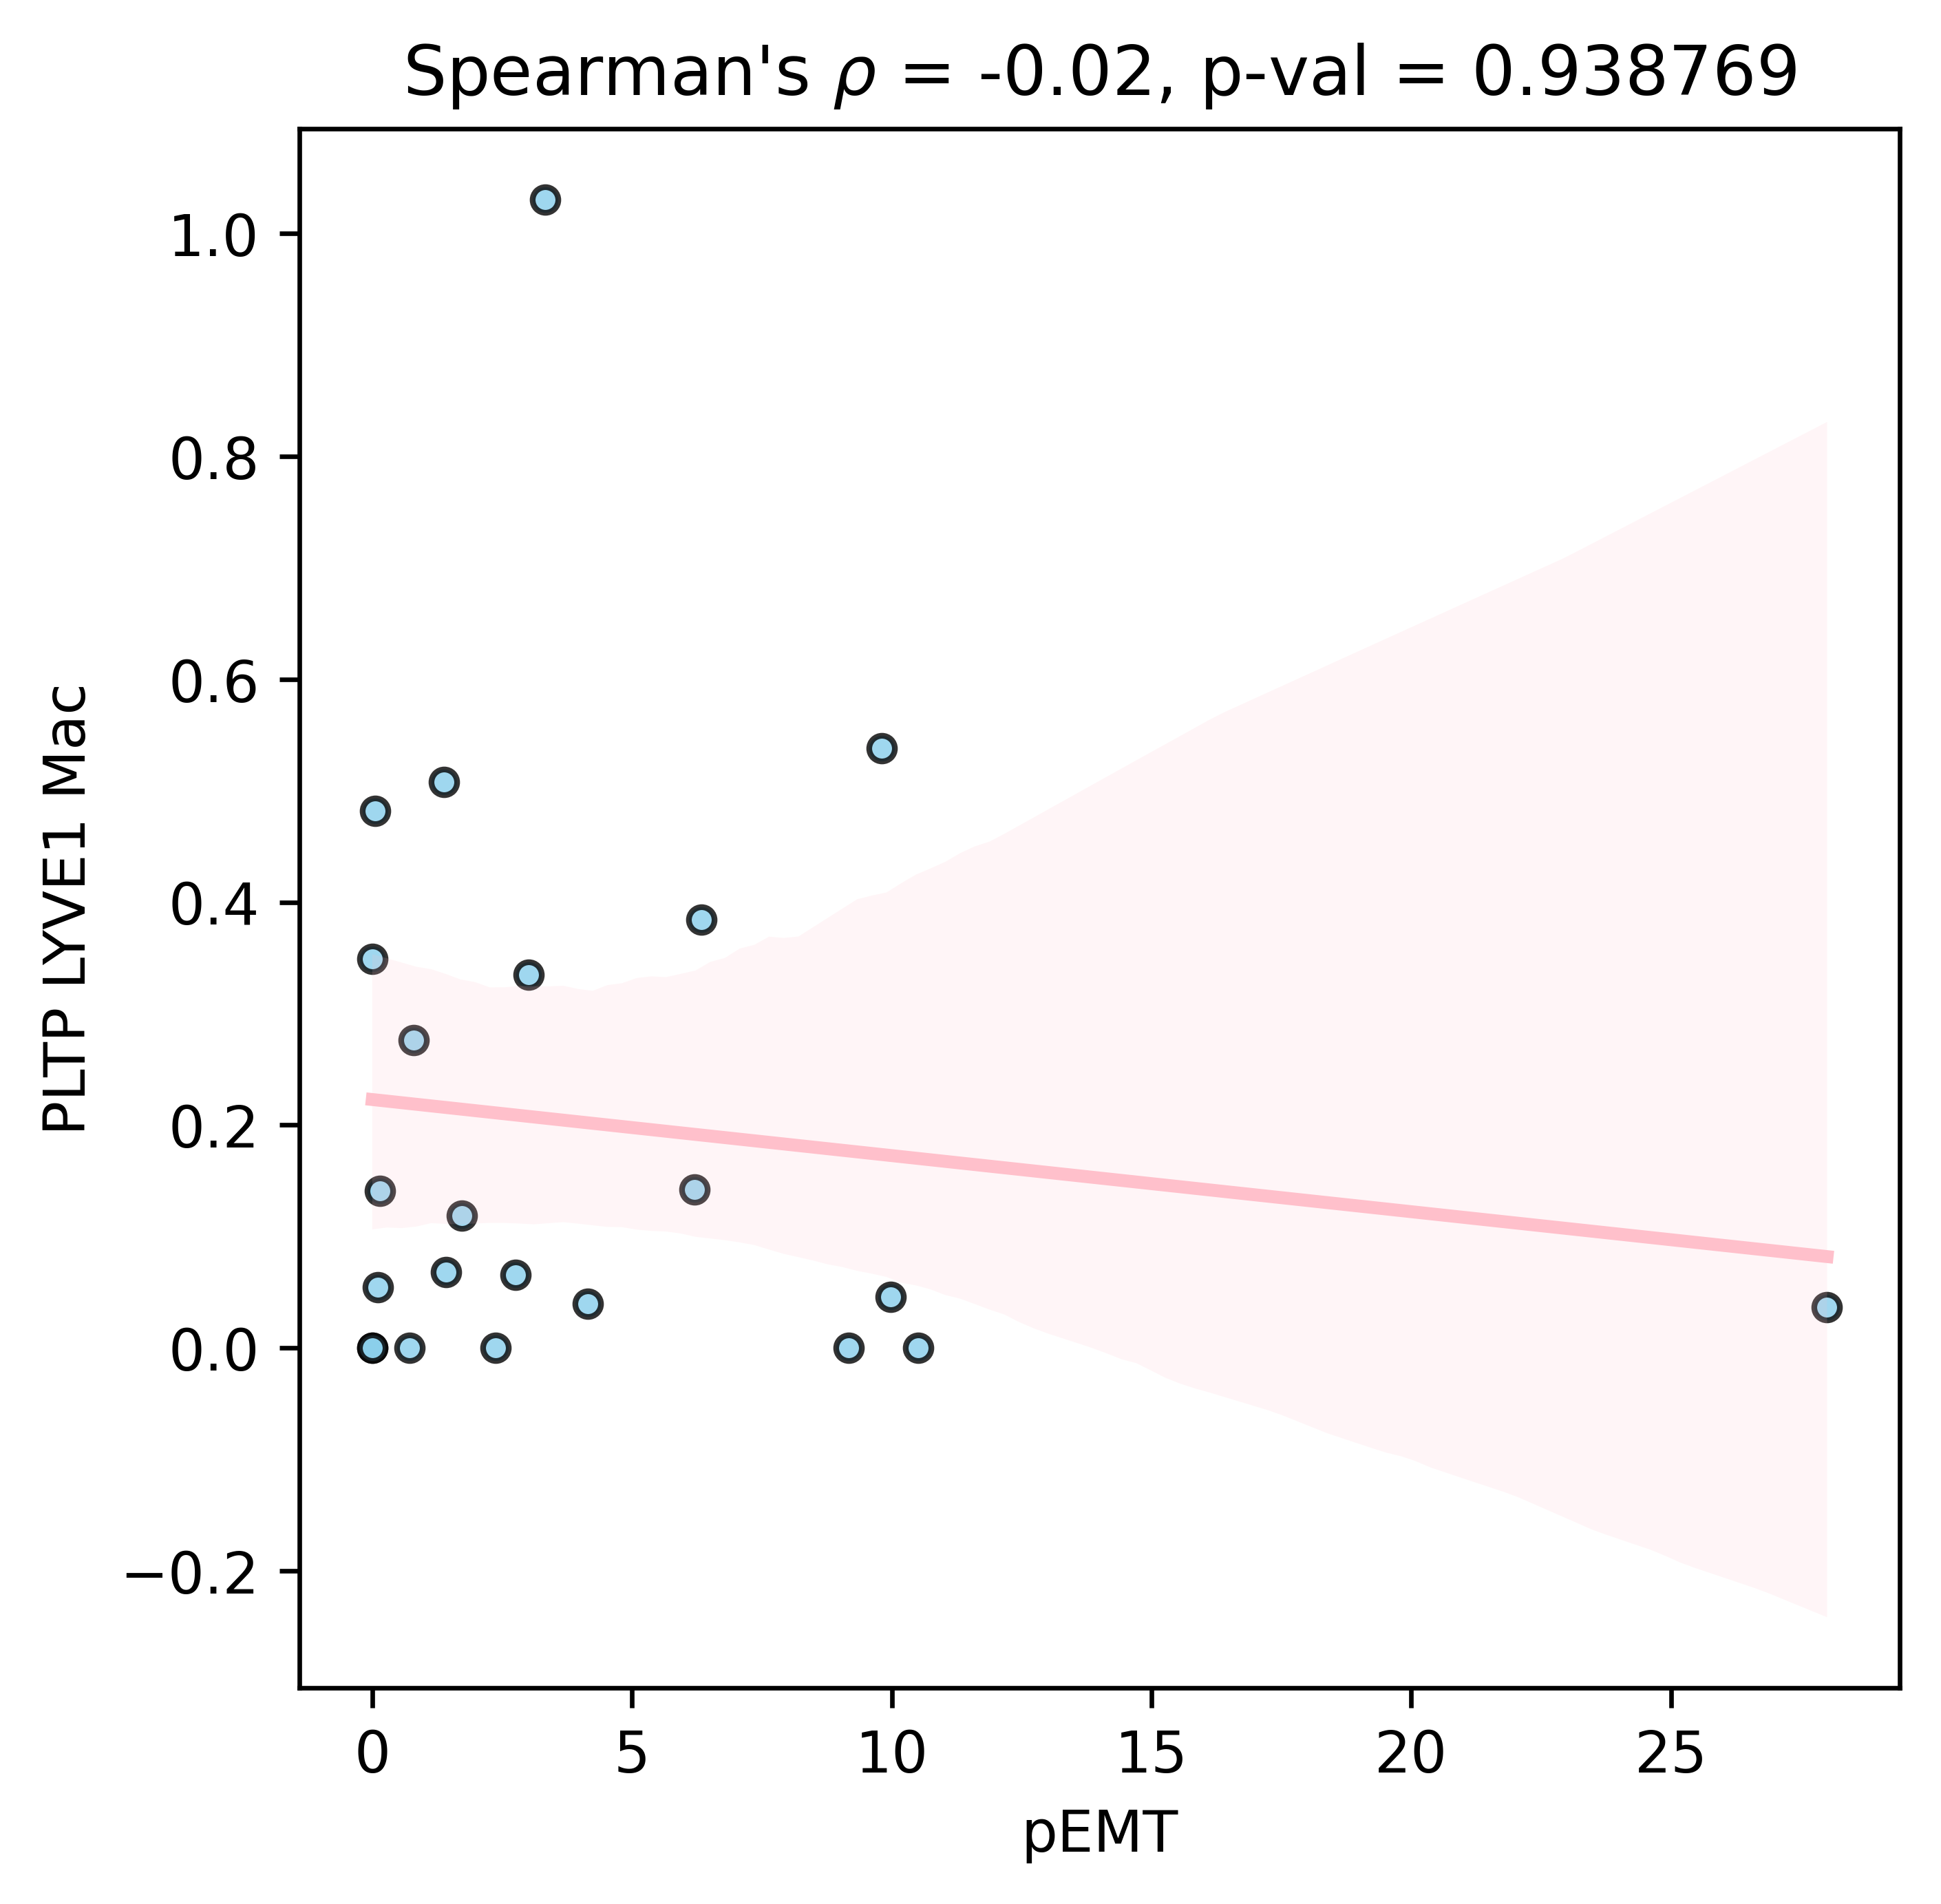

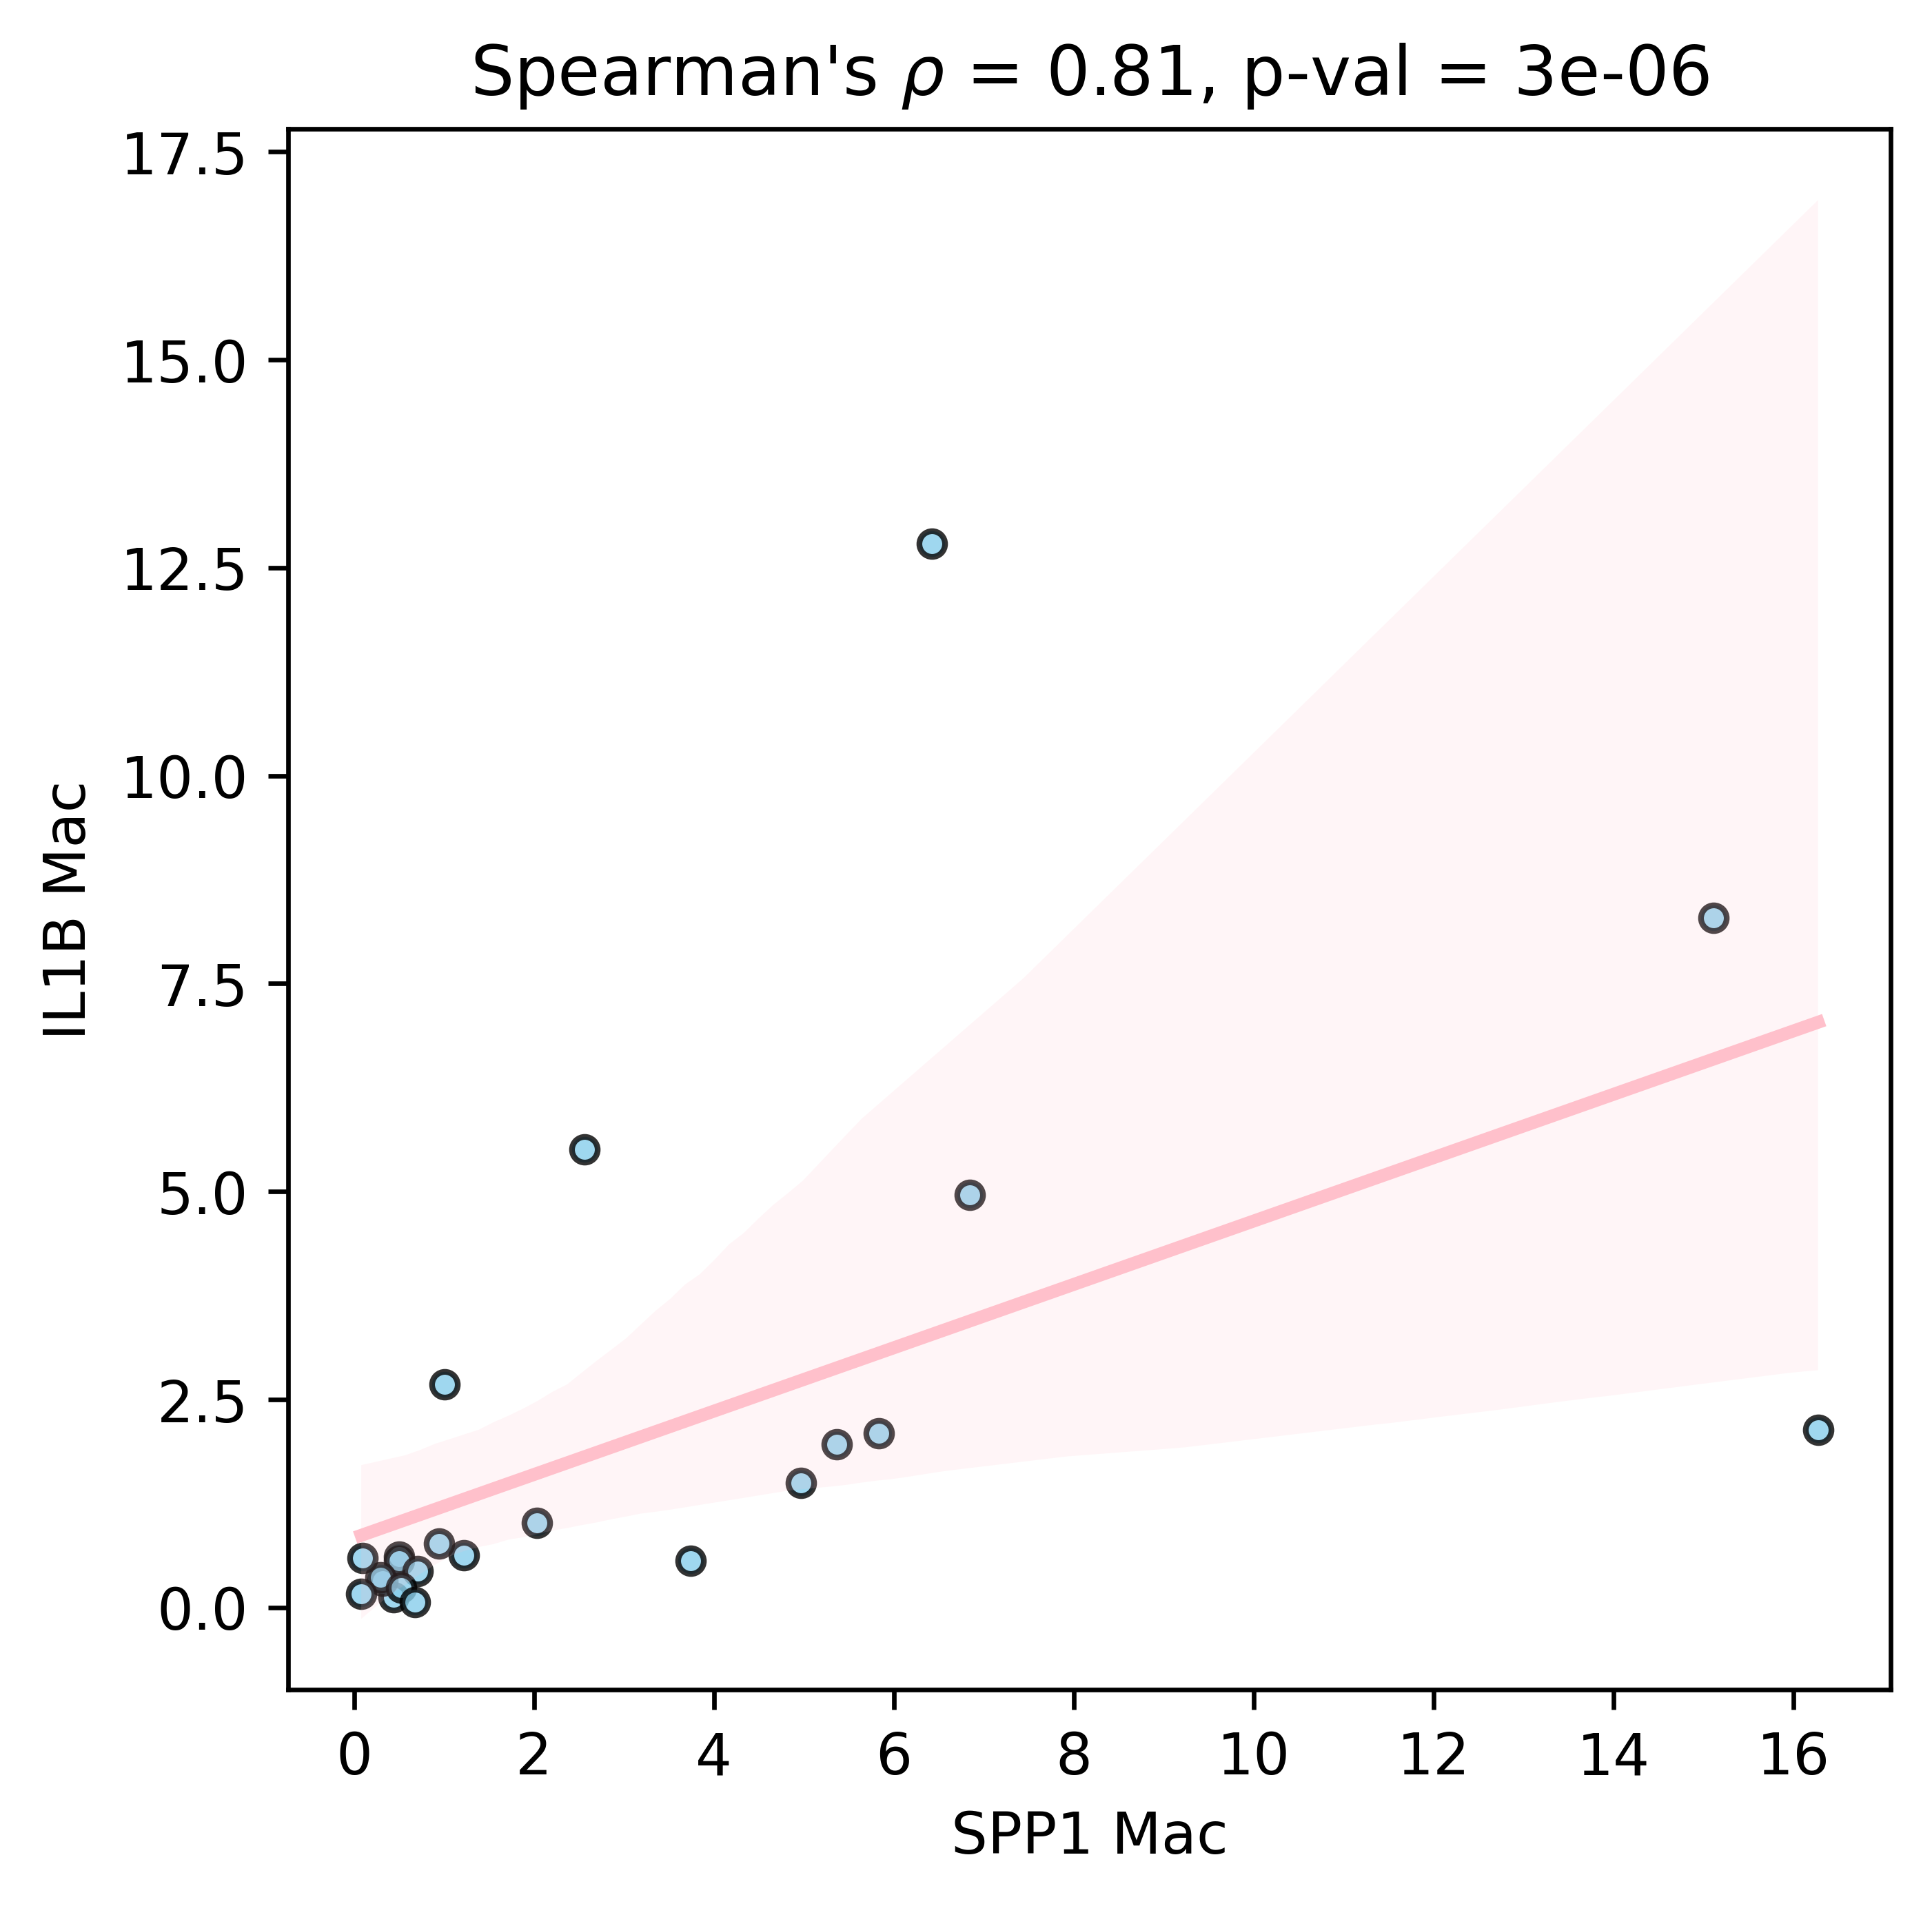

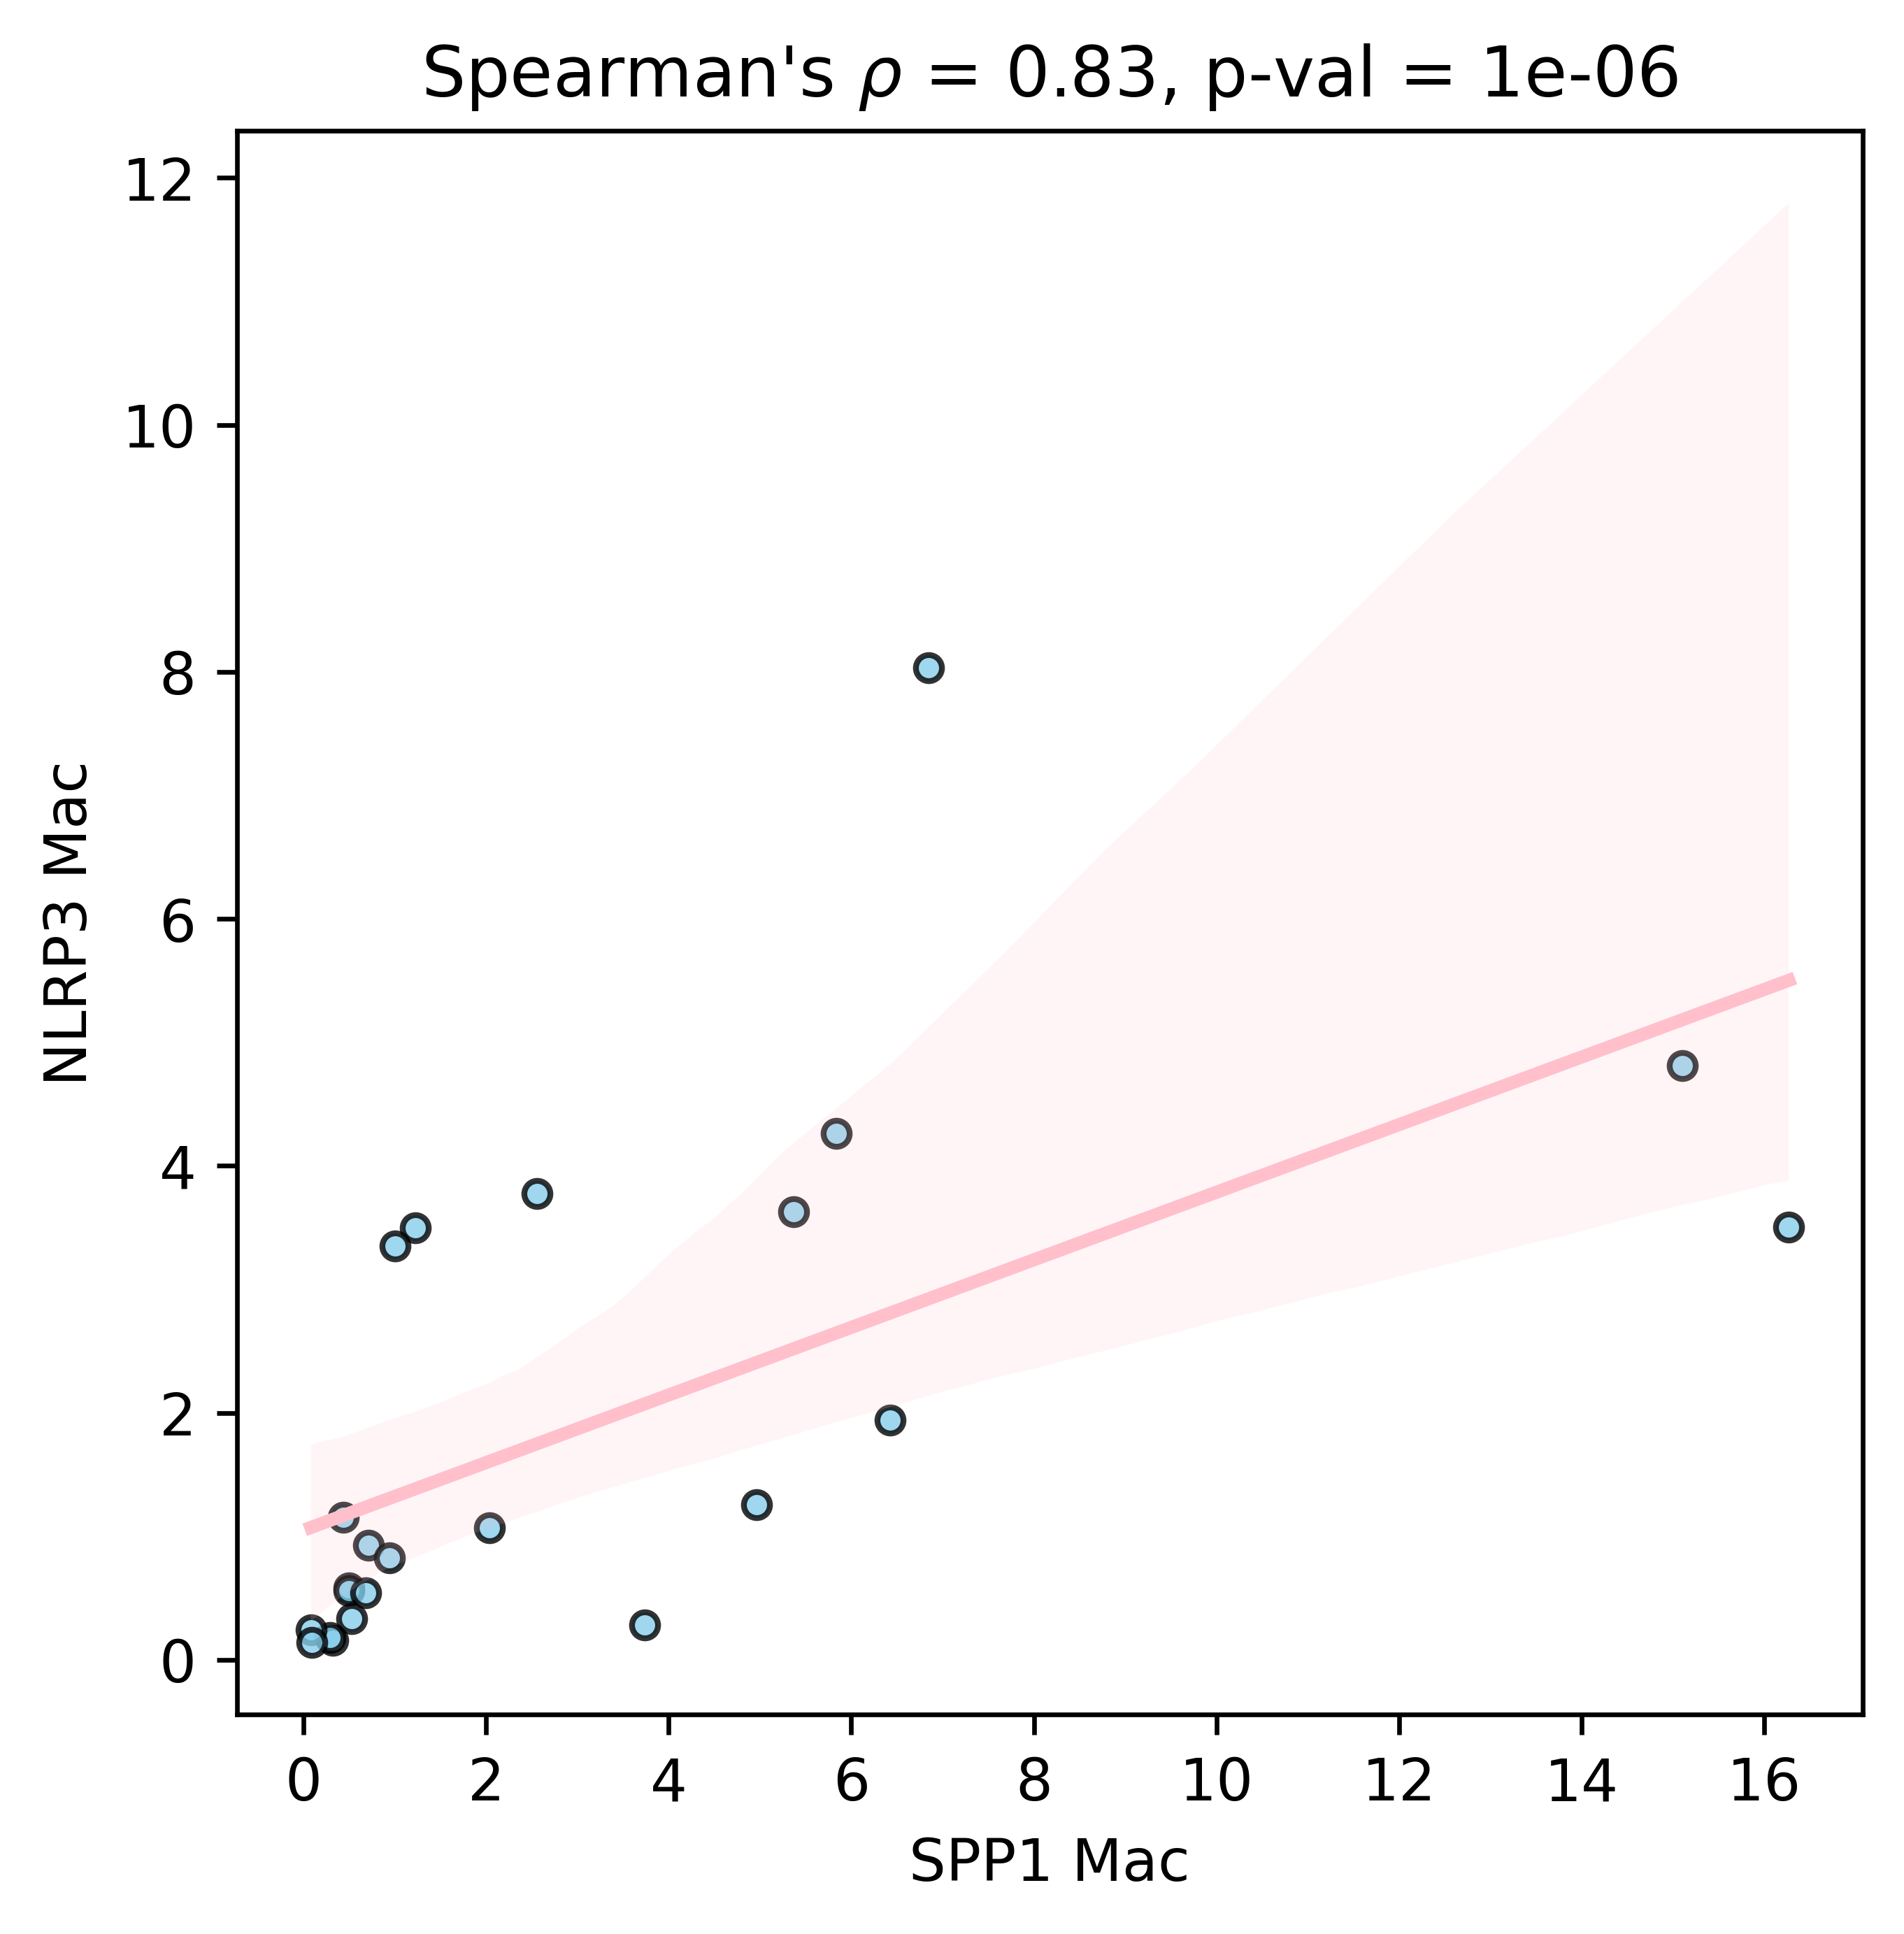

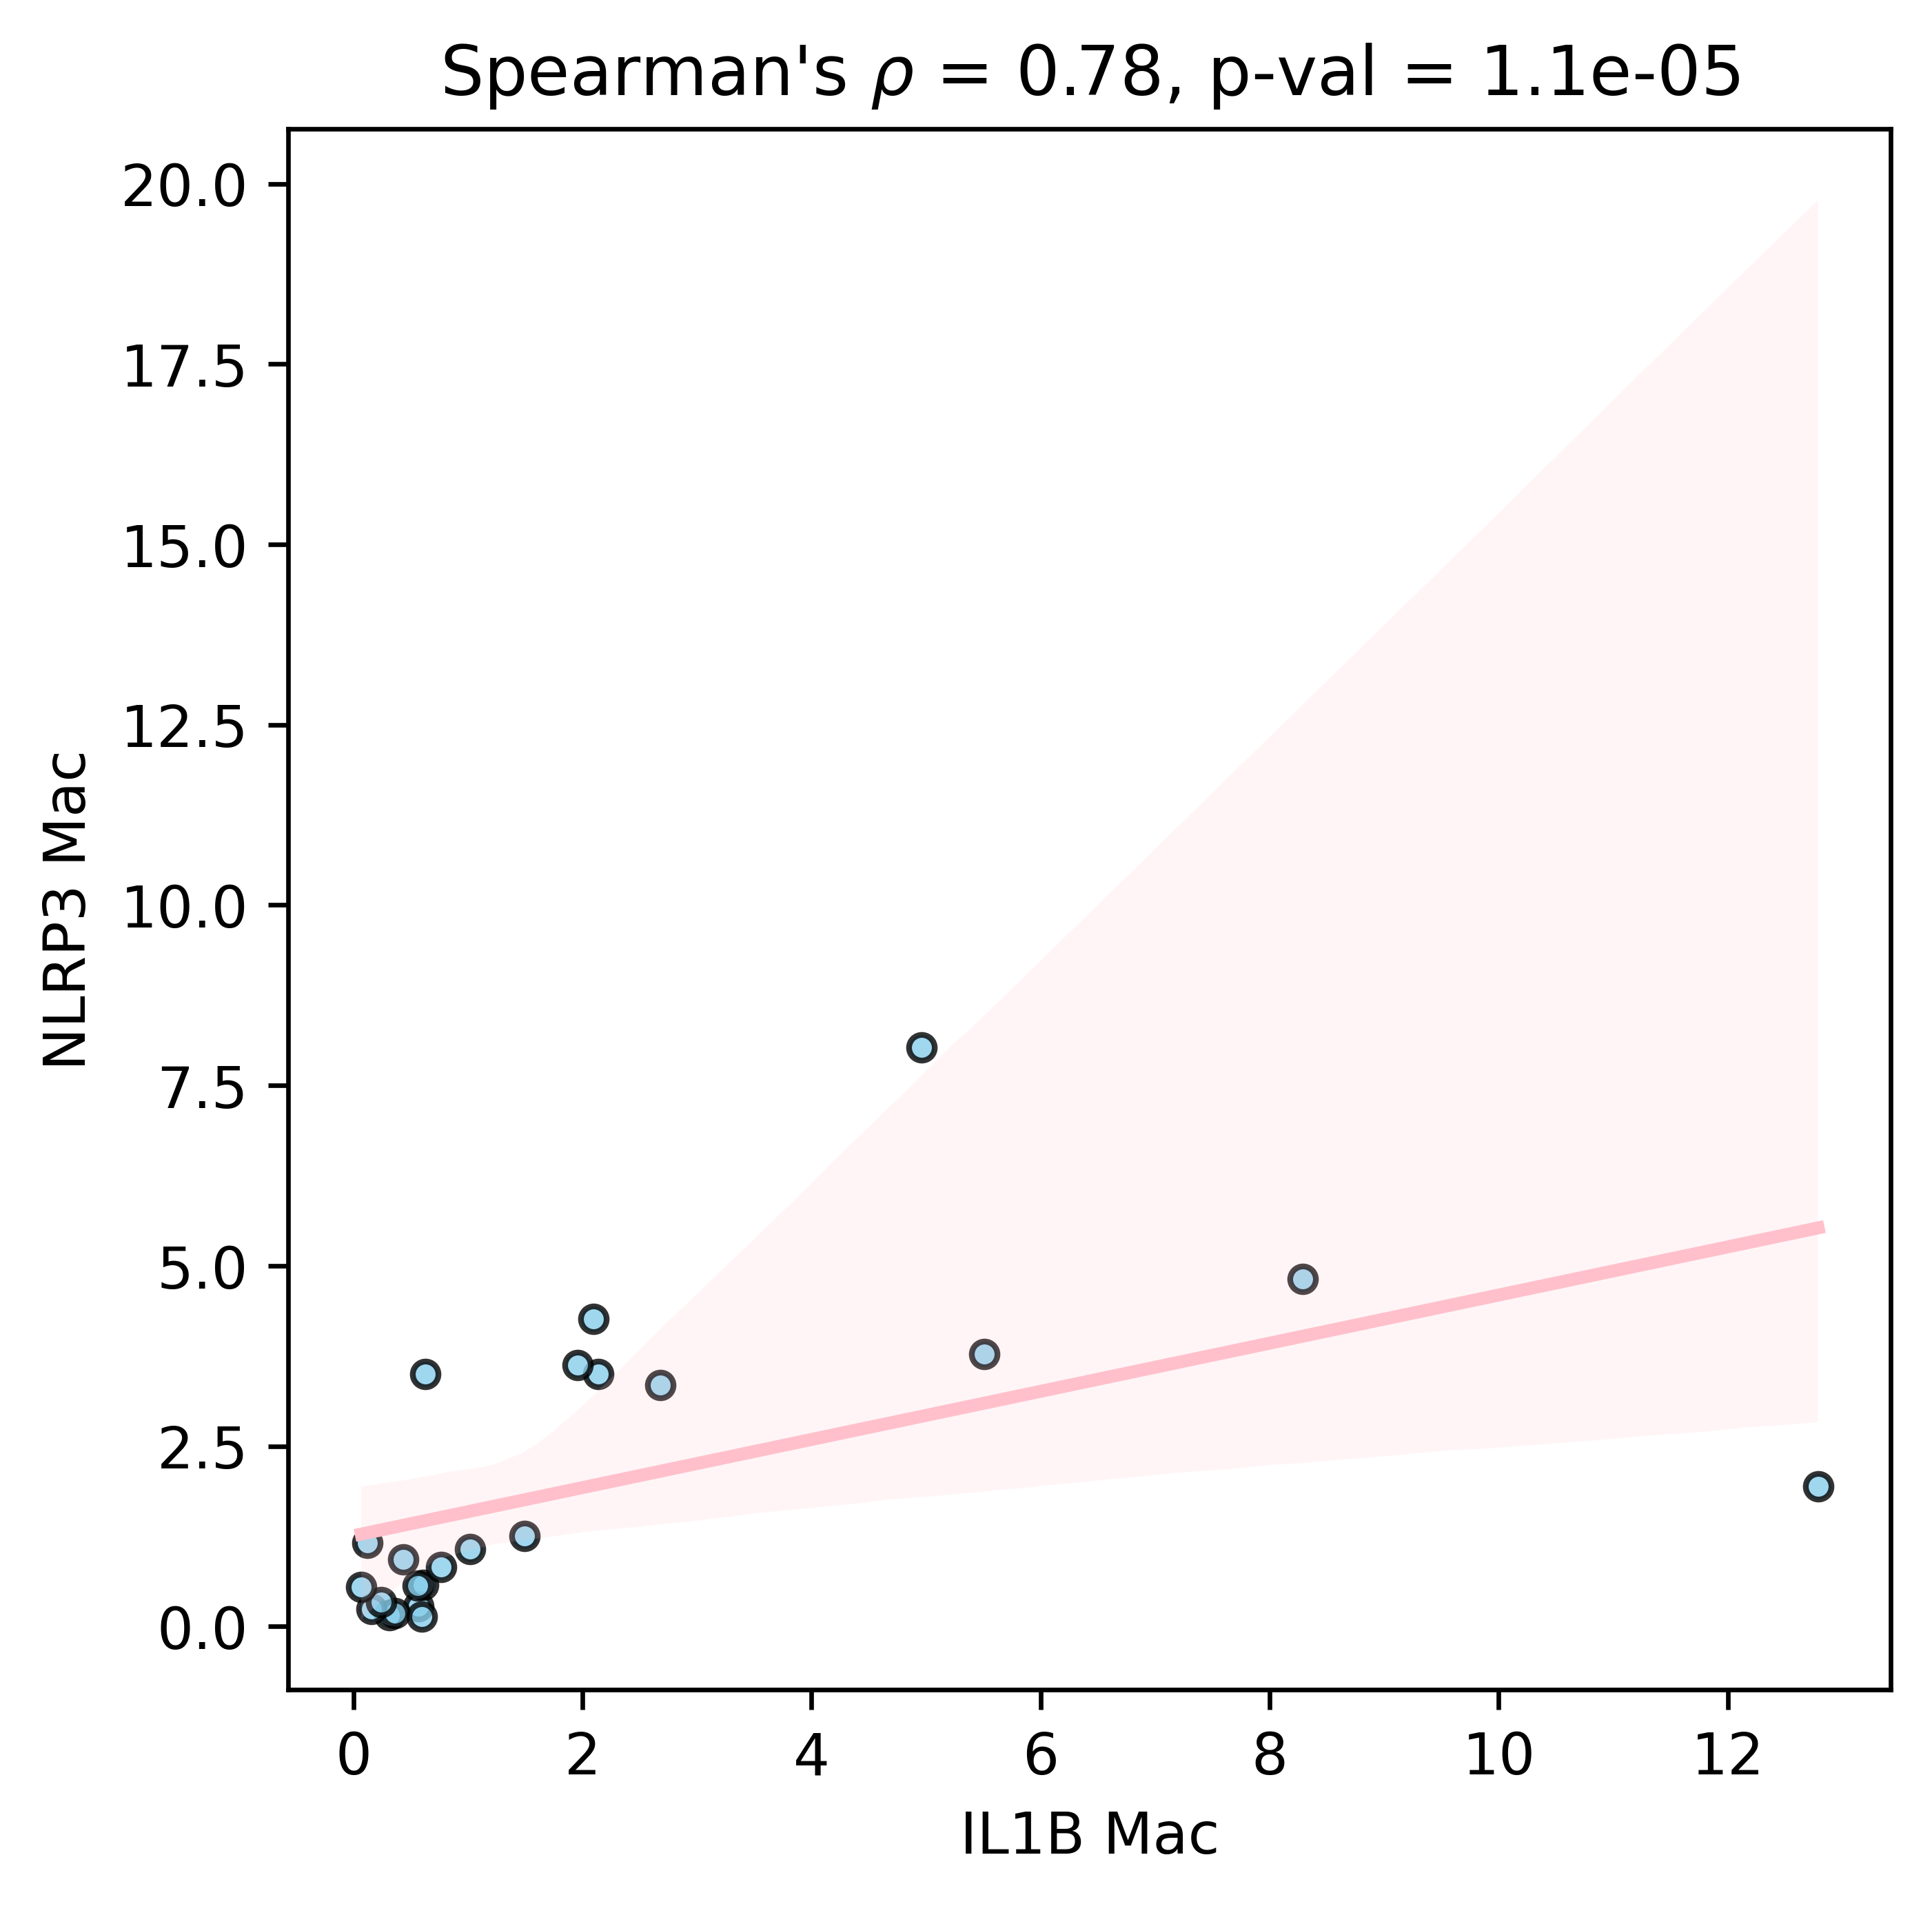

In [43]:
## plot for some subsets the coorelation regplot
from scipy.stats import spearmanr

pairs2plot = [('Stem (NOTUM high)', 'CXCL14 BMP CAF'), ('Stem (NOTUM high)', 'Pericyte'),
              ('Stem (NOTUM high)', 'Plasma'), ('Stem (NOTUM high)', 'Stalk-like endo'),
              ('ipEMT', 'CD8 Tex'), ('ipEMT', 'SPP1 Mac'), ('ipEMT', 'Lymphatic endo'), ('ipEMT', 'Myofibroblast'),
              ('ipEMT', 'MMP CAF'), ('ipEMT', 'PLTP LYVE1 Mac'),
              ('pEMT', 'SPP1 Mac'), ('pEMT', 'MMP CAF'), ('pEMT', 'ipEMT'), ('pEMT', 'CD8 Tex'), ('pEMT', 'PLTP LYVE1 Mac'),
              ('SPP1 Mac', 'IL1B Mac'),
              ('SPP1 Mac', 'NLRP3 Mac'), ('IL1B Mac', 'NLRP3 Mac')
             ]

for pair in pairs2plot:
    
    res = spearmanr(prop_subsets[pair[0]], prop_subsets[pair[1]])

    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False, dpi=DPI, figsize=(5,5))

    sns.regplot(x=prop_subsets[pair[0]], y=prop_subsets[pair[1]], 
                ax=ax, 
                scatter=True, 
                fit_reg=True, 
                scatter_kws={'s':20,'edgecolors':'black',"color": 'skyblue'},
                line_kws={"color": 'pink'})
    ax.set_title(f"Spearman's $\\rho$ = {round(res[0], ndigits=2)}, p-val = {round(res[1], ndigits=6)}")
    
    #plt.ylim(-1, 1)
    #plt.xlim(-1, 1)

    fig.savefig(FIG2SAVE.joinpath(f"{cell_source}_subsets_scatterplot_spearmann_{pair[0]}_{pair[1]}.pdf"), 
                dpi=DPI, 
                format="pdf",
                bbox_inches="tight")

In [ ]:
FIG2SAVE

In [ ]:
from scipy.stats import spearmanr

res = spearmanr(prop_subsets)

In [ ]:
res[0]

In [ ]:
res[1]